# Art Class
Build intuition through creativity

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax

plt.style.use('intuitivebayes.mplstyle')
figsize = (24,12)  

/home/canyon/miniconda3/envs/ib_gp2/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## How to a draw a line
Our data and various ways linear fits


##  How to draw a wiggly line
How we can improve our model with an additional term

## Art a different way
How would we intuitively build a curve

## Similarity Functions
Introducing the concept of a kernel

## Seeing a full Gaussian process
Getting smooth fit of the CO2 data

# How to a draw a line
The first model that everyone tries (probably)

## Mauna Loa 
<center>
  <img src="img/MaunaLoa.jpg" style="height:850px"; />
</center>

Lets first talk about Hawaii, specifically Mauna Loa, which is quite beautiful as you can see here

On this island there is a research facility where they conduct experiments.

## Mauna Loa CO2 Experiment
<br>
<center>
    <div>
       <img src="img/9oyu_2ghf_141031.jpg" style="height:750px";/>
    </div>
</center>

- Been measuring C02 for the last X years
- A key experiment in the study of climate change
- Longest running continuous collection of atmospheric CO2 measurements


## Mauna Loa CO2 dataset


In [2]:
data = pd.read_csv("data/co2_mm_mlo.csv", header=51) # the first 51 lines are metadata about the dataset

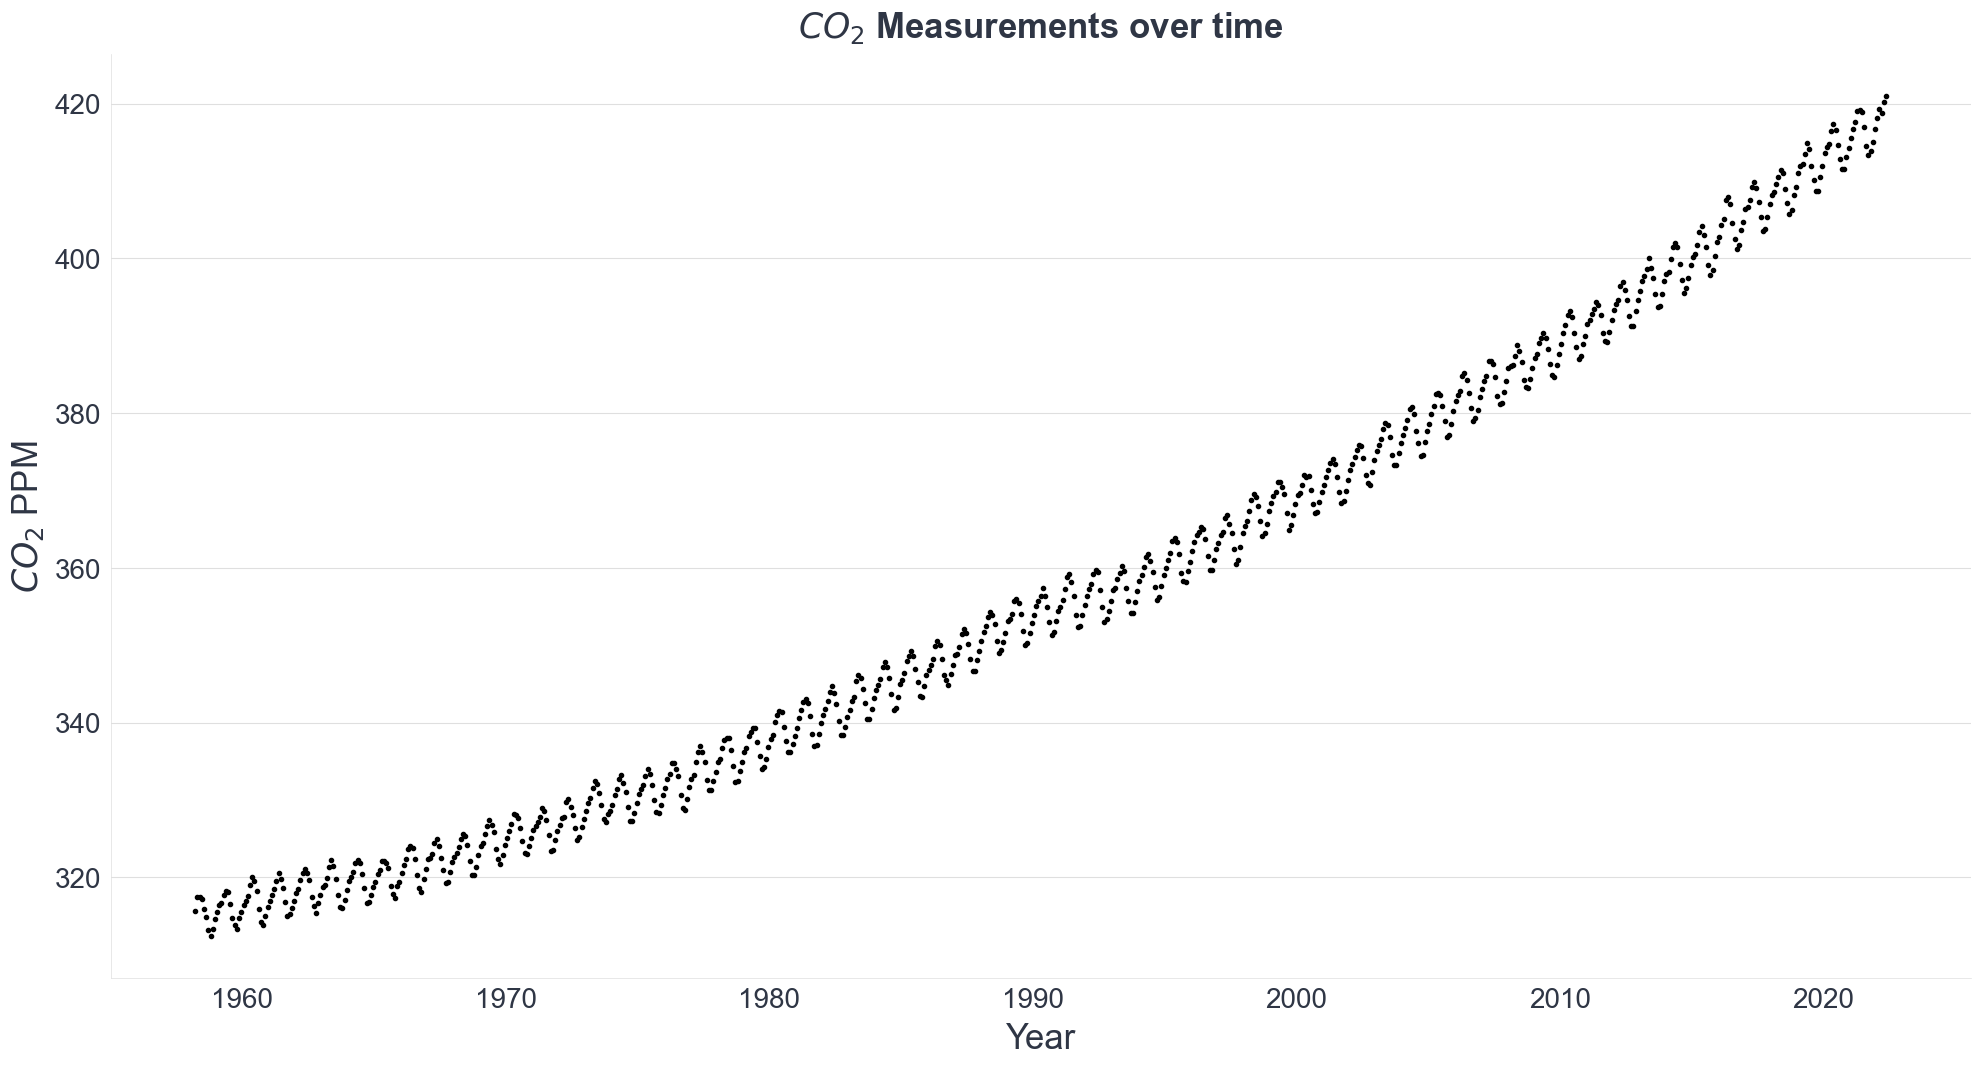

In [3]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
ax.scatter(data["decimal date"], data["average"], color="k")
ax.set_title("$CO_2$ Measurements over time")
ax.set_xlabel("Year"),
ax.set_ylabel("$CO_2$ PPM");

Here's the time series, theres a number of things we can note immediately. Is the trend, at a gance it looks roughly linear but perhaps not quite, it also has a seasonal pattern. Specifically it has some sort of cycle

## Zooming In

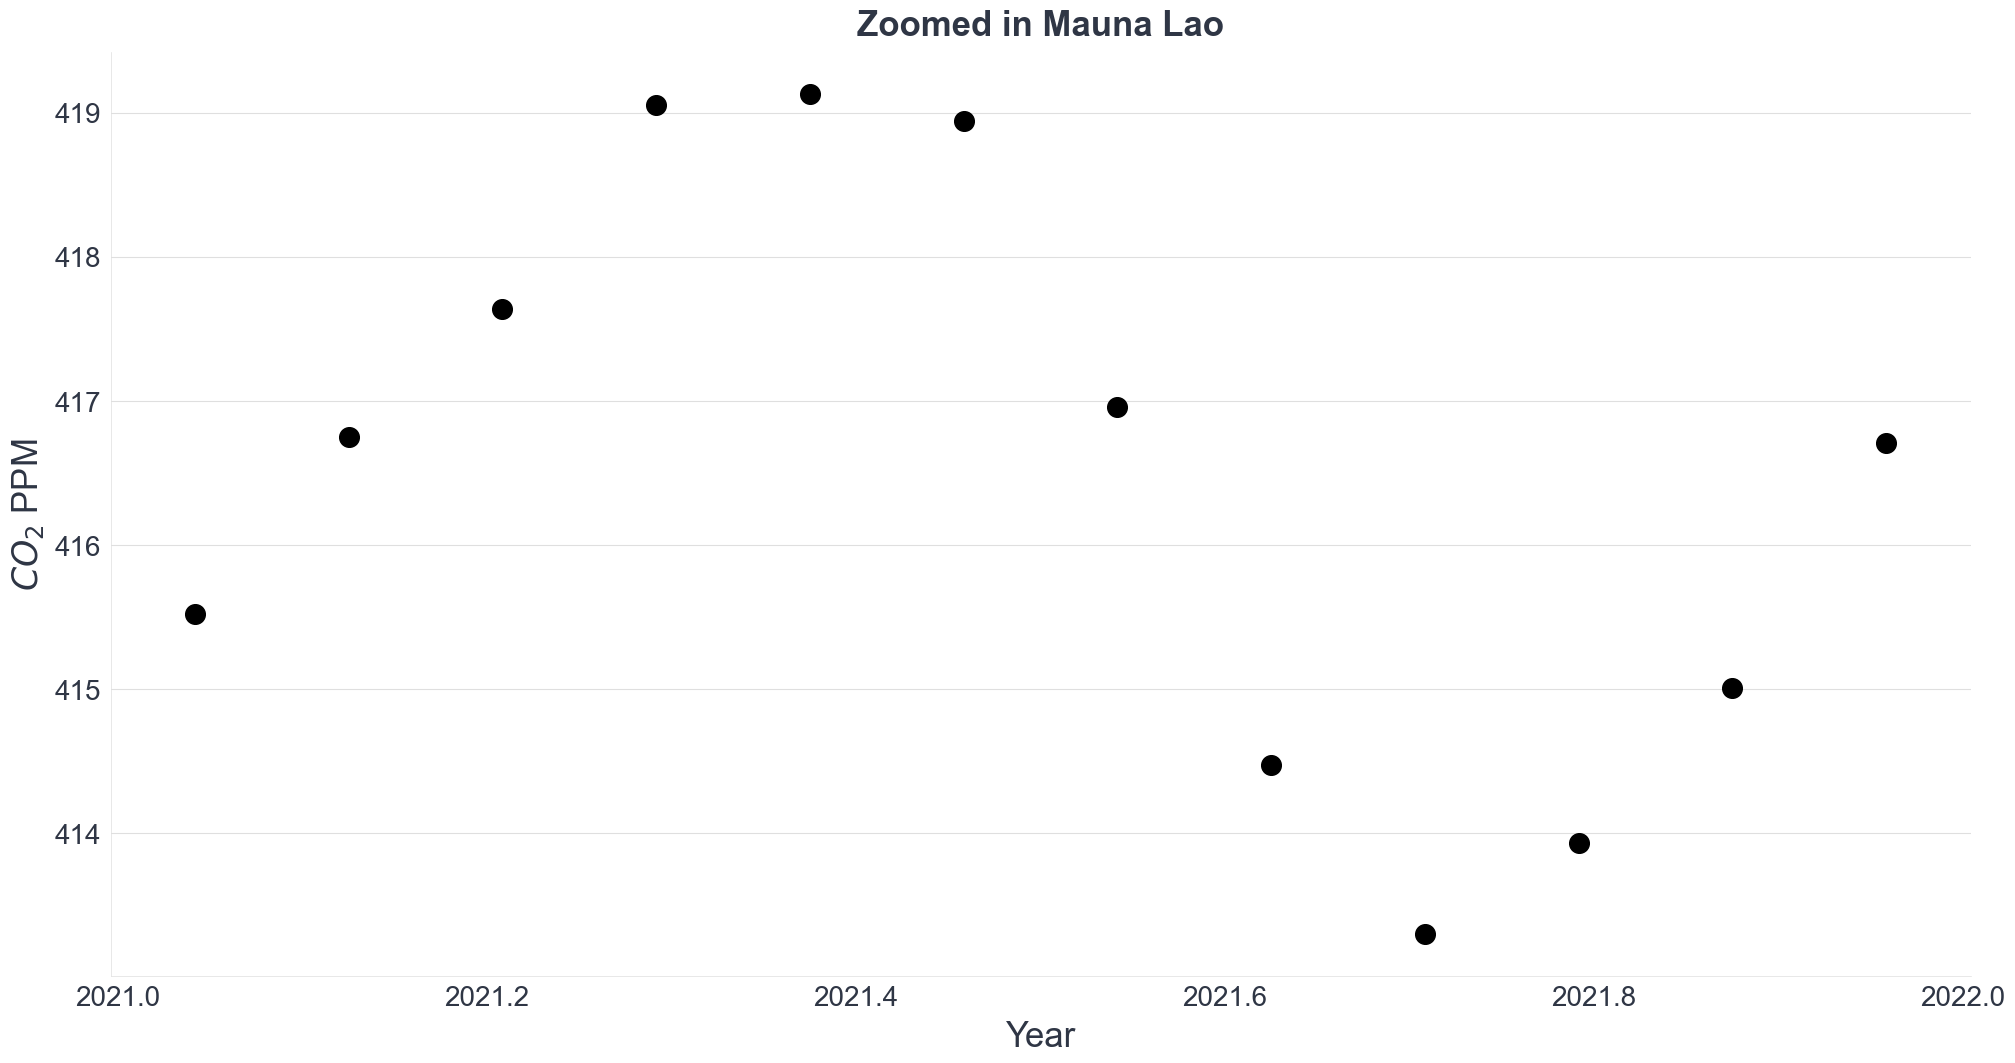

In [4]:
year = data[(data["decimal date"] > 2021) & (data["decimal date"] <= 2022)]

fig = plt.figure(figsize=figsize)
ax = fig.gca()
ax.scatter(year["decimal date"], year["average"], s=800, color="k")
ax.set_title("Zoomed in Mauna Lao")
ax.set_xlabel("Year")
ax.set_ylabel("$CO_2$ PPM");

If we zoom in we can see a couple more features. The data has an an annual cycle which peaks in the spring, lowest in the fall

## Lets create a model
<center>
    <div>
       <img src="img/PyMc.png" height="400" />
    </div>
</center>

We're statisticians so buiding models is what we do. 

##  Lets create a model using a principled workflow

<center>
    <div>
       <img src="img/IB_Bayesian_workflow.jpg" height="200" />
    </div>
</center>


But we're also principled statisticians that follow the bayesian workflow
Let's start simple, and try and increase complexity.
Sometimes it's hard to resist the temptation to reach for the most "advanced" approach you know first.  It's always better to work up in this direction than the opposite.

We'lll

## Modeling the trend with a function

$$\huge{\text{CO2 Level} = f(x)}$$


Mathematical functions are the main tools we use to fit data.  Whether we are extrapolating or forecasting, or interpolating, we need something that given an `x`, outputs a `y`, or the range of plausible `y` values.  


## Linear Function

$$\huge{\text{CO2 Level} = mx + b}$$

Lets start by using familiar function you've seen before but before you skip this slide lets talk through it.

We'll first start simple lets model the trend. We're saying that if we have model parameters m and b, we can estimate C02_level by plugging in a value of X.



## Estimating the  parameters

$$\huge{\text{CO2 Level} = \overbrace{m}^{\text{Slope}}x + \overbrace{b}^{\text{Intercept}}} $$

Now we still need to figure out what m and b should be to get make out estimate

## *A* way to pick an intercept


In [5]:
intercept = data.sort_values(["decimal date"])["average"].head(1)
intercept  

0    315.7
Name: average, dtype: float64

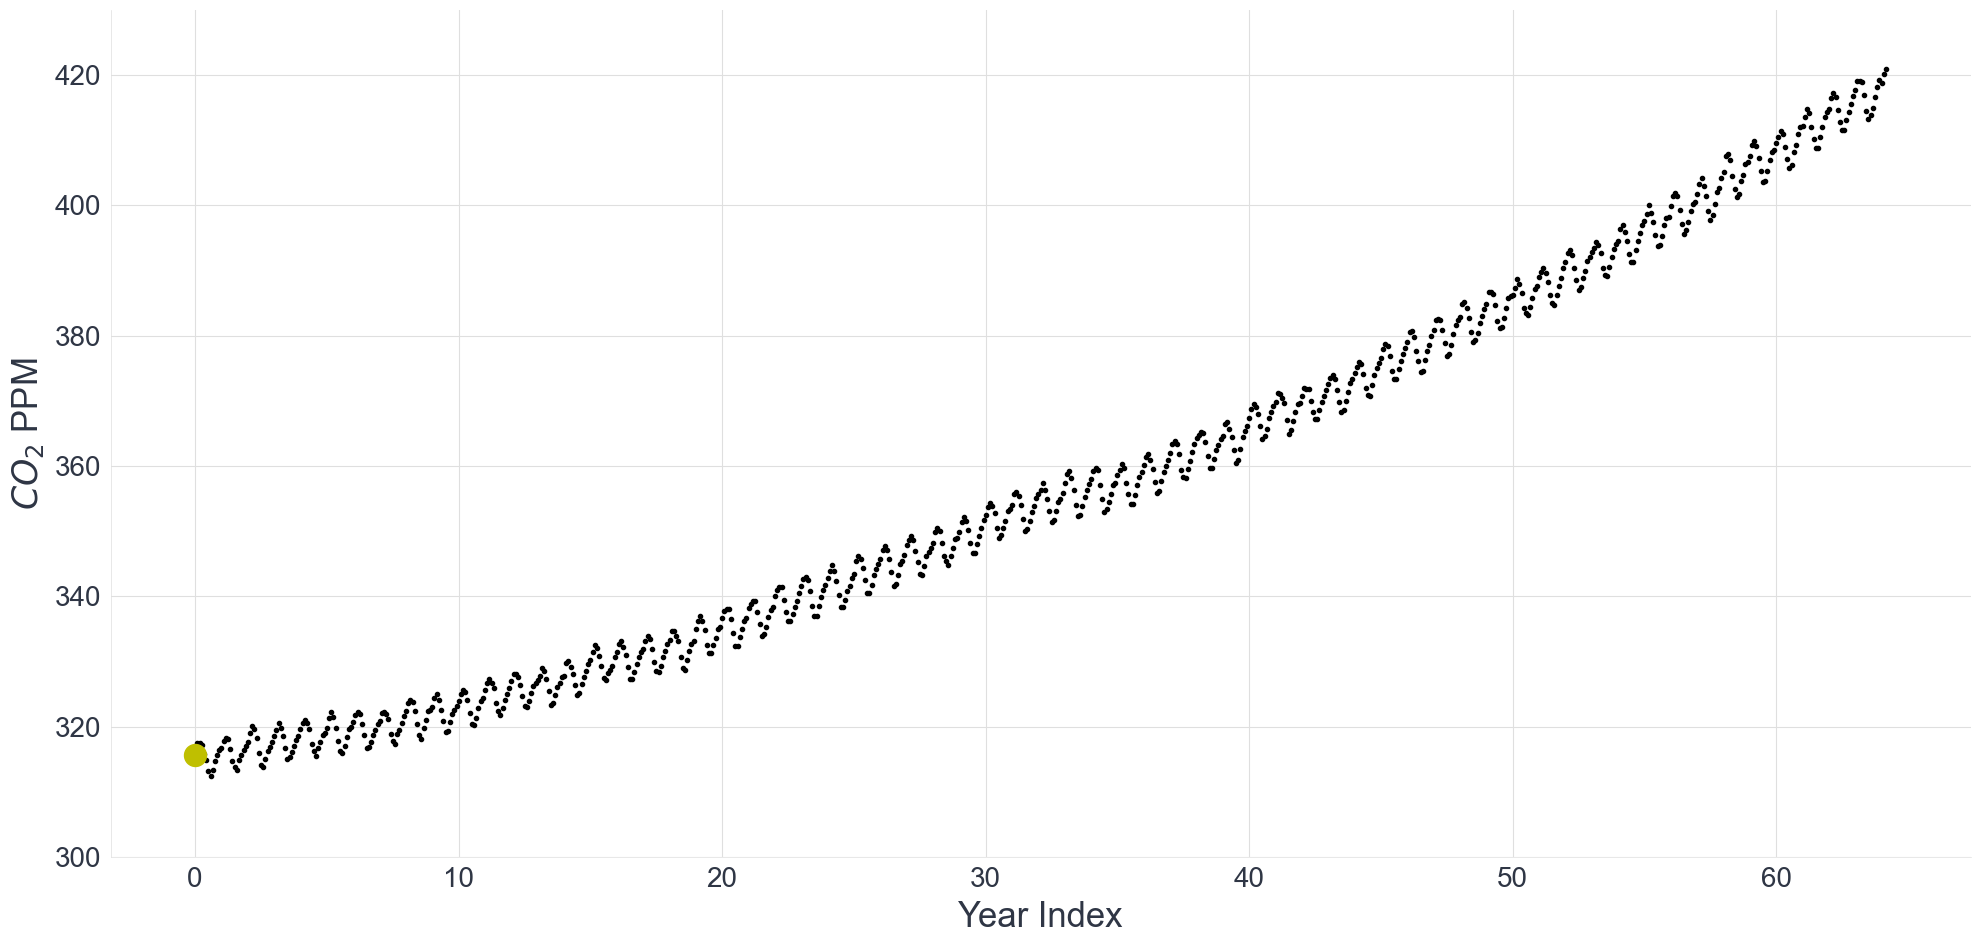

In [6]:
fig = plt.figure(figsize=(24, 11))
ax = fig.gca()

ax.scatter(data["decimal date"] - data["decimal date"].min(), data["average"], color="k");
ax.scatter(0, intercept.values, s=1000, color="y")

ax.grid(True)
ax.set_ylim([300, 430])
ax.set_xlabel("Year Index")
ax.set_ylabel("$CO_2$ PPM");

Let's just say we decide the intercept is where the first data point is. Remember we can make an estimate however we want, and in this case we're choosing to eye it out. As modelers we pick both our model and our estimation technique.



## *A* way to pick a slope

In [7]:
xl = np.linspace(0, 70, 200)
possible_line1 = 315.7 + 1.5 * xl

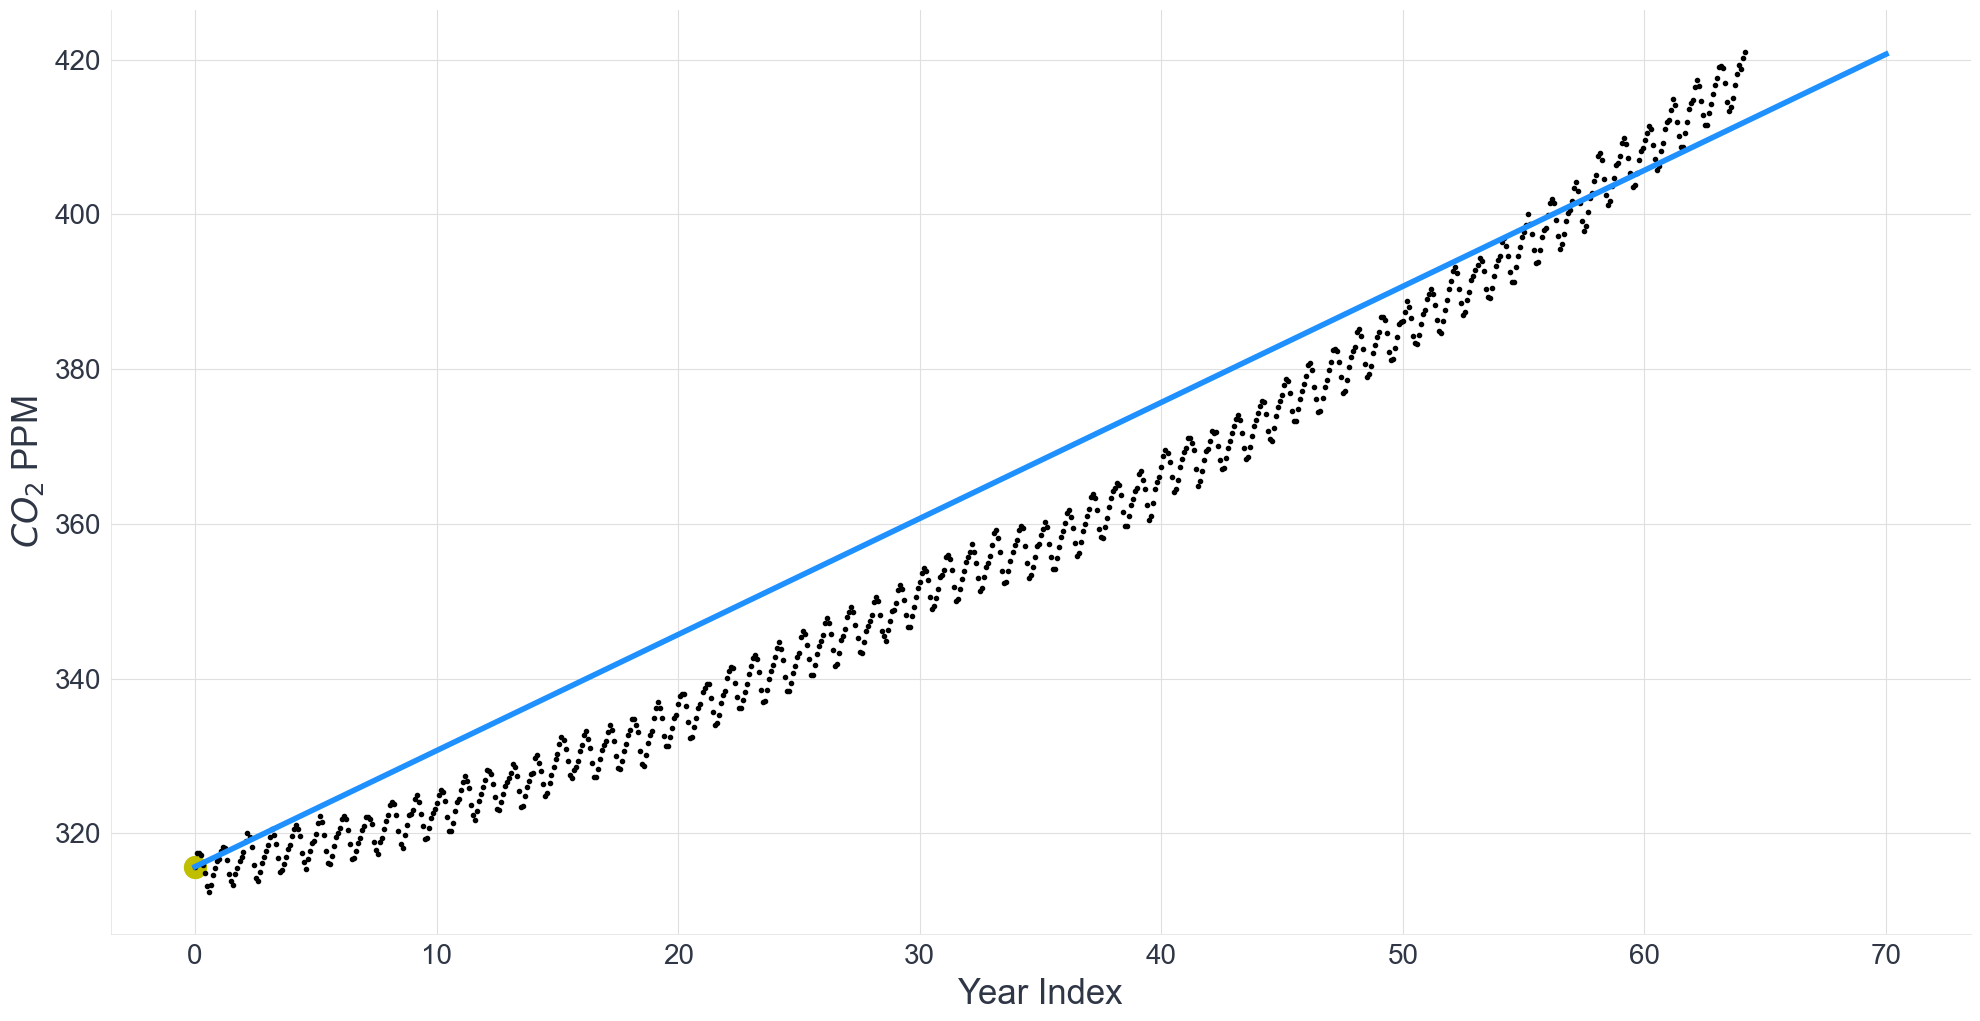

In [8]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

ax.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.")
ax.scatter(0, intercept.values, s=1000, color="y")

ax.grid(True)
ax.plot(xl, possible_line1, "dodgerblue")
ax.set_xlabel("Year Index")
ax.set_ylabel("$CO_2$ PPM");

Now that we've picked an intercept all we need to do is pick a slope. Lets use rise over run

The slope parameter `m` might be a little easier.  Slope is defined as "rise over run", so lets try calculating. We might as well use that as one of our guesses.  Eyeballing it with upward curve makes this a bit tricky, but lets also try 300, and 290.   

The slope parameter `m` might be a little easier.  Slope is defined as "rise over run", so lets try calculating that at a few spots.  

## Multiple Estimations

In [9]:
xl = np.linspace(0, 70, 200)

possible_line1 = 315.7 + 1.5 * xl
possible_line2 = 300.0 + 2.0 * xl
possible_line3 = 290.0 + 2.0 * xl

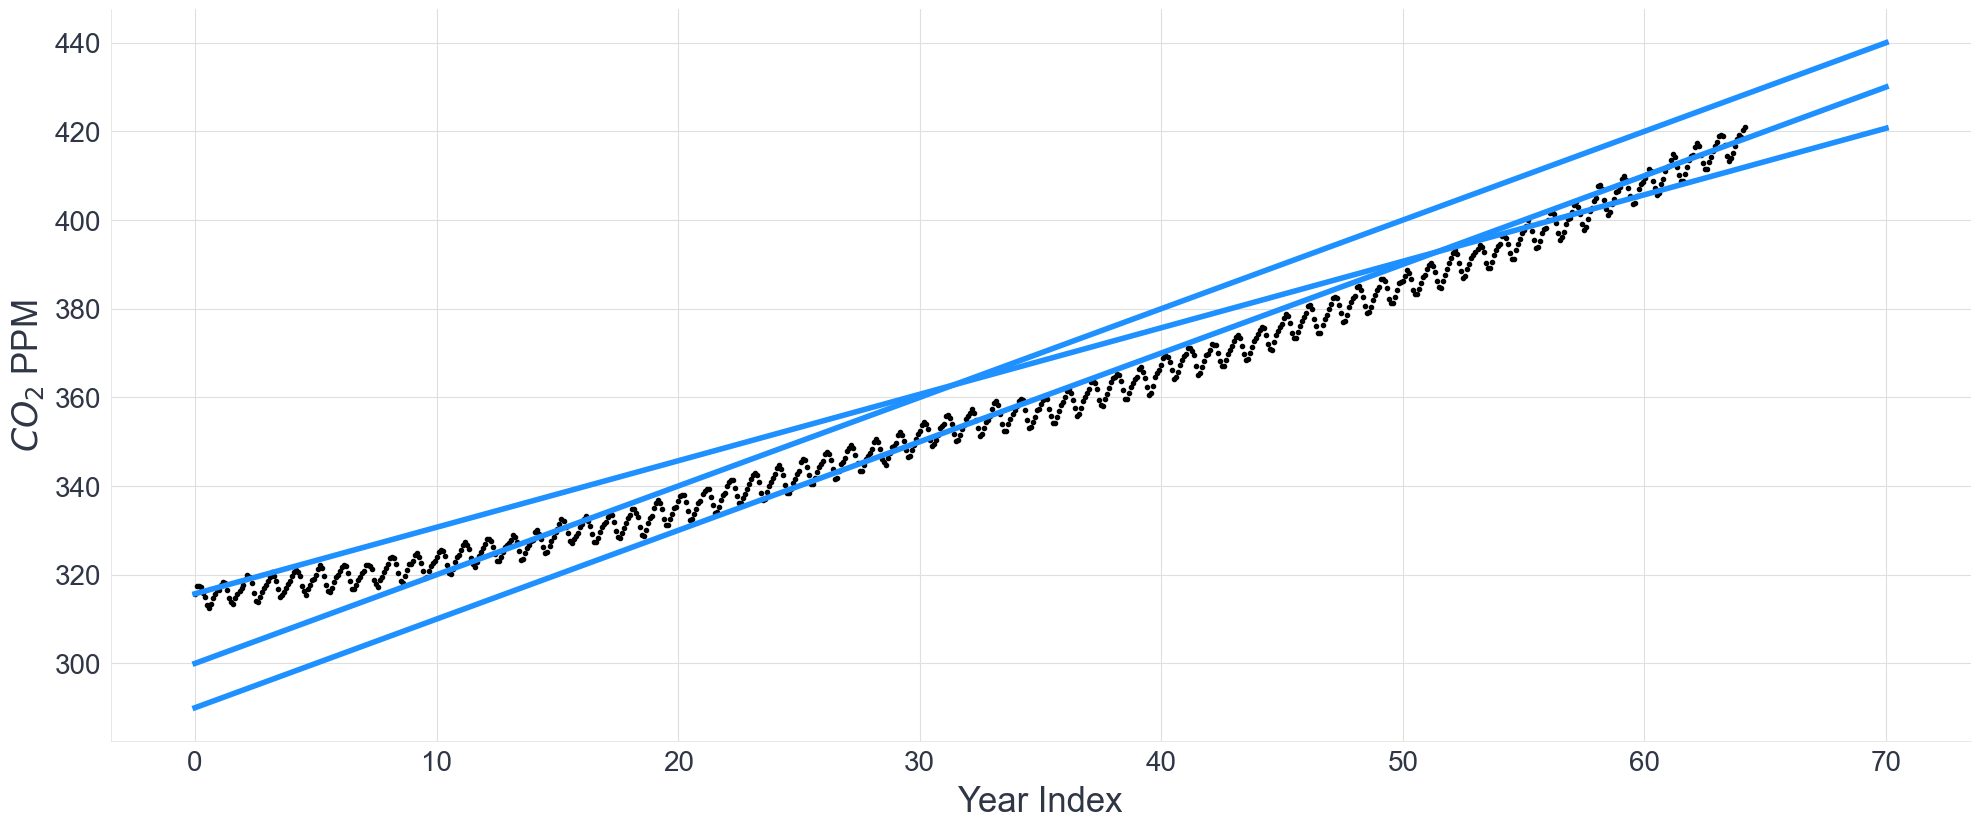

In [10]:
fig = plt.figure(figsize=(24, 9.5))
ax = plt.gca()

ax.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.");
ax.plot(xl, possible_line1, "dodgerblue")
ax.plot(xl, possible_line2, "dodgerblue")
ax.plot(xl, possible_line3, "dodgerblue")

ax.grid(True)
ax.set_xlabel("Year Index")
ax.set_ylabel("$CO_2$ PPM");

We can pick a couple more data points and repeat this process
- Lets start from year 10 to year 30:  Looking at the chart, at year 10, CO2 is about 320.  At year 30 CO2 is about 350.  That gives $\frac{350 - 320}{30-10} = 1.5$. - Year 30 to year 60: $\frac{410 - 350}{60-30} = 2.0$
- Year 40 to year 50: $\frac{385 - 370}{50-40} = 2.0$

Lets plug in our guesses and plot a few lines.

These are clearly pretty rudimentary guesses, but they at least look plausible?

How can we be more rigorous mathematically though? 

## OLS Regression

In [11]:
x = data["decimal date"].values - data["decimal date"].min()
X = np.vstack((np.ones(len(x)), x)).T 

y = data["average"].values

((b_est, m_est), _, _, _) = np.linalg.lstsq(X, y, rcond=None)
b_est, m_est

(305.59123653340896, 1.6081969456682896)

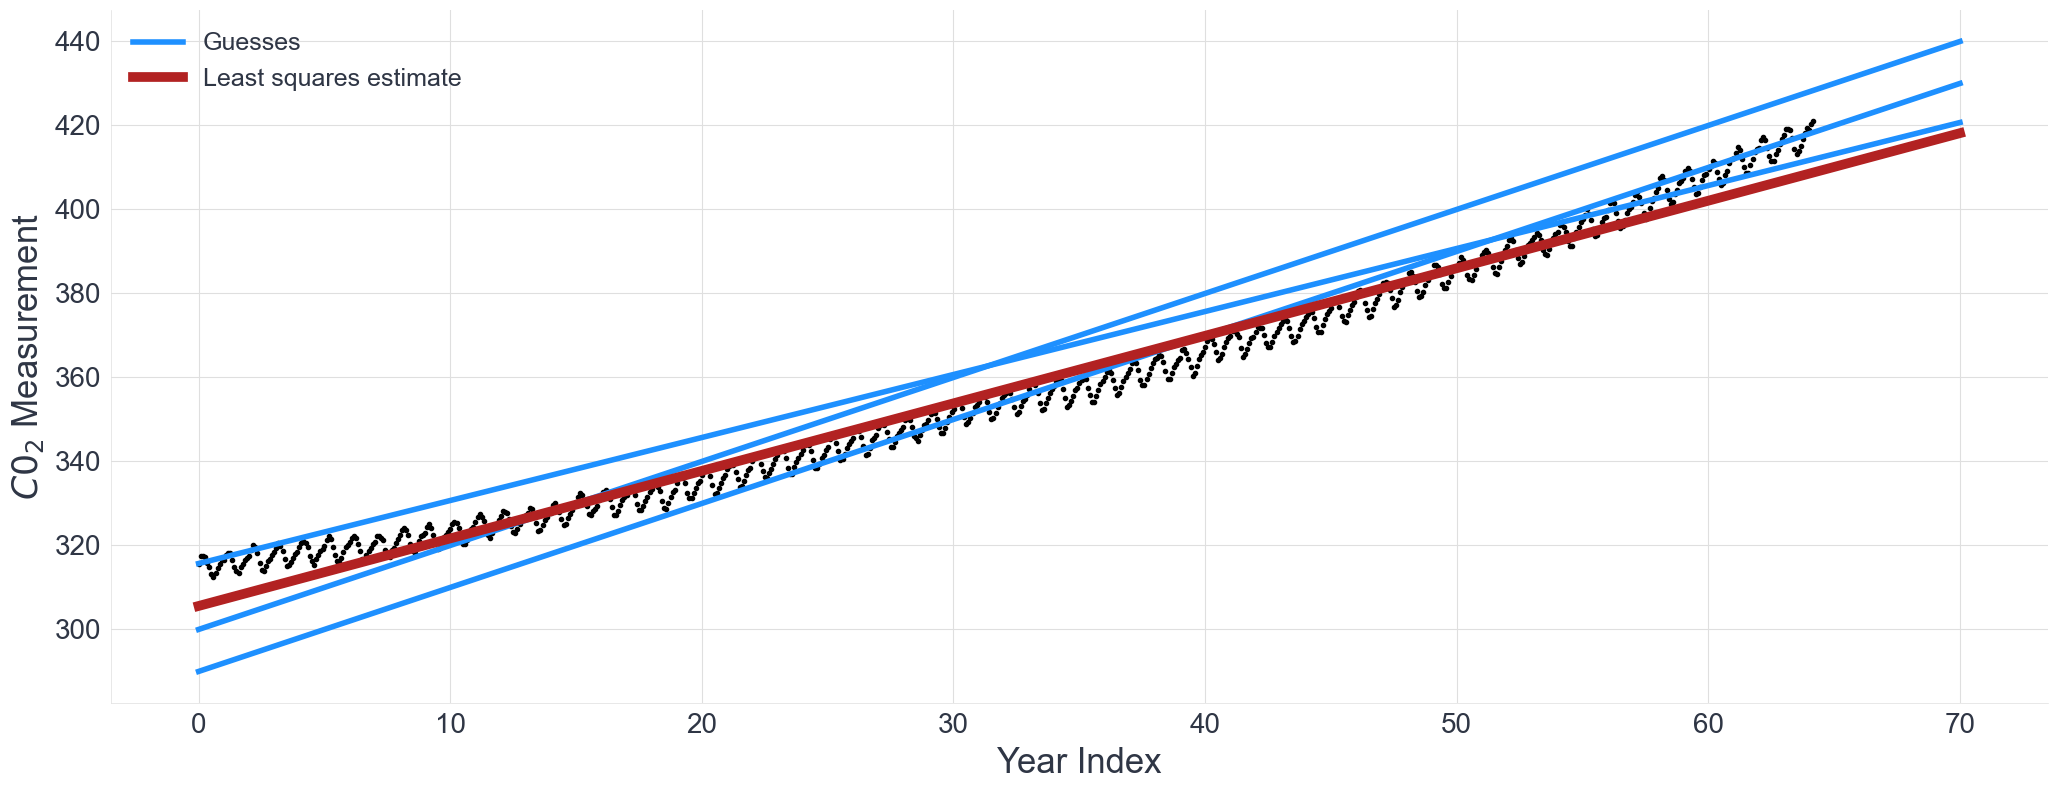

In [12]:
fig = plt.figure(figsize=(25, 9))
ax = fig.gca()

# plot data
ax.scatter(data["decimal date"] - data["decimal date"].min(), data["average"], color="k");

# plot guesses
ax.plot(xl, possible_line1, "dodgerblue")
ax.plot(xl, possible_line2, "dodgerblue")
ax.plot(xl, possible_line3, "dodgerblue", label="Guesses")

# plot least squares estimate
ax.plot(xl, b_est + m_est * xl, color="firebrick", lw=7, label="Least squares estimate");

ax.grid(True)
ax.legend()
ax.set_xlabel("Year Index")
ax.set_ylabel("$C0_2$ Measurement");

We can use least squares using the OLS method for fun.

The least squares estimates for the y-intercept is 305.6, and for the slope its 1.6, which are pretty close to our previous guesses.

## Bayesian Regression

In [13]:
with pm.Model() as model:
    b = pm.Normal("b", mu=300, sigma=100)
    m = pm.Normal("m", mu=0.0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    x_ = pm.MutableData("x", data["decimal date"] - data["decimal date"].min())
    mu = pm.Deterministic("mu", m * x_ + b)
    
    pm.Normal("y", mu=mu, sigma=sigma, observed=data["average"])

But we're bayesian here, and we know how powerful this estimation method can be not to get one line, but all lines. Lets go ahead and use PyMC to get all possible lines **and** their relative plausability.

## Fit the model in PyMC

In [14]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8825, but should be close to 0.8. Try to increase the number of tuning steps.


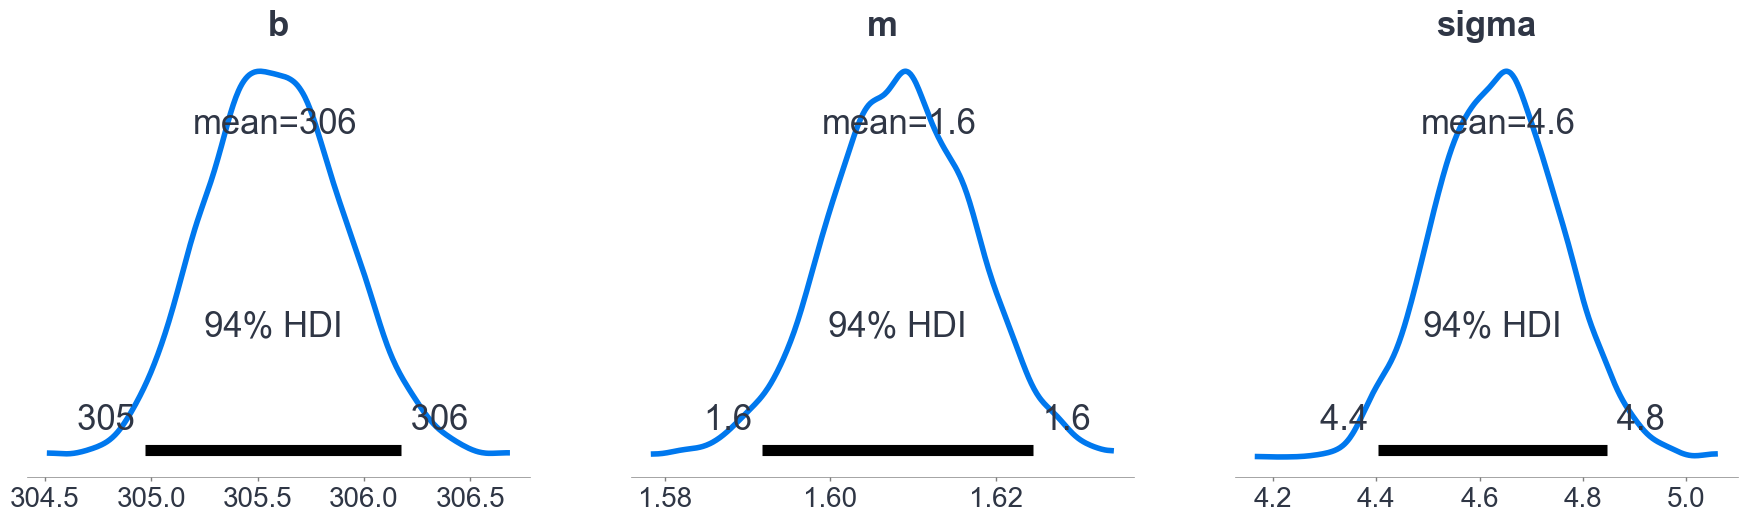

In [15]:
az.plot_posterior(idata.posterior, var_names=["b", "m", "sigma"]);

We can see that with a Bayesian approach, we can let the model produce guesses, and associate each guess with a "plausibility score", or a posterior probablity. 


## Making Predictions using the posterior predictive

In [16]:
x.shape, xl.shape

((771,), (200,))

In [19]:
with model:
    pm.set_data({'x': xl})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])
    idata.extend(ppc)

We also can make predictions about future observations themselves

## Plotting the Posterior Predictive

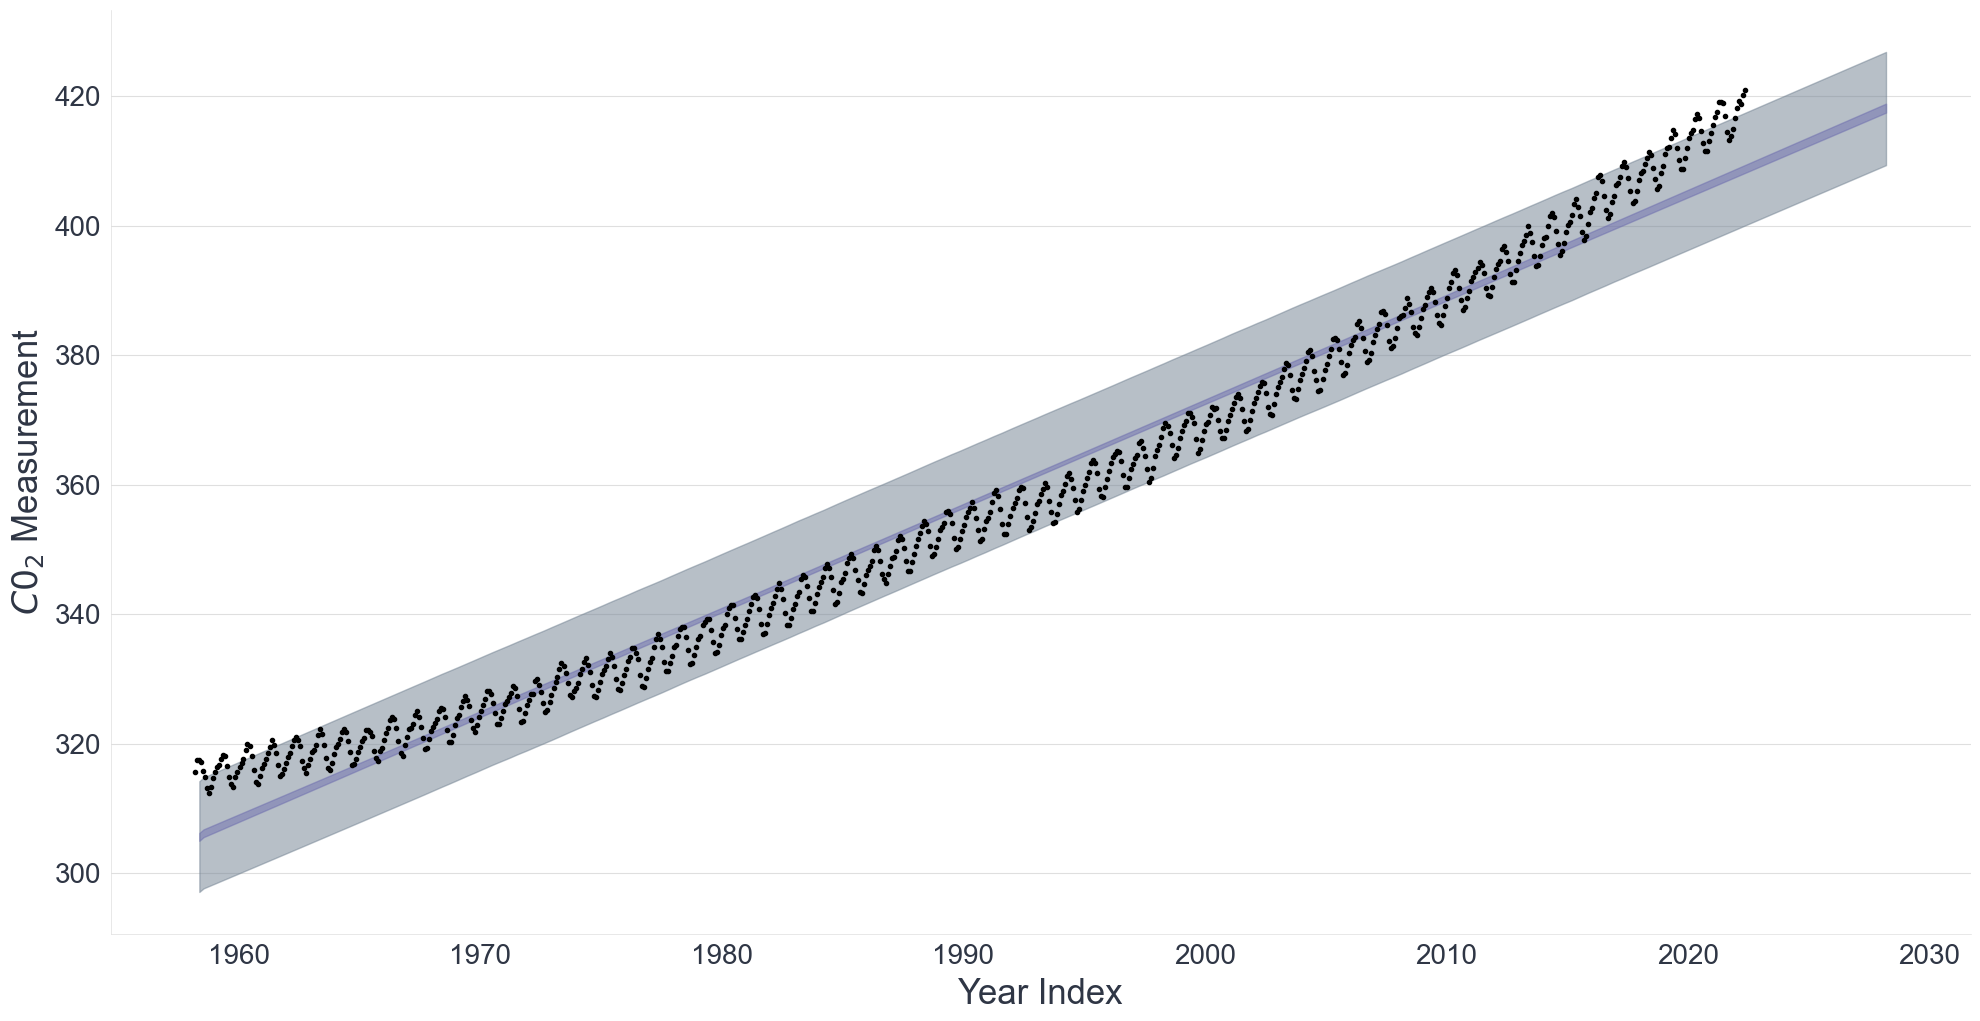

In [20]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu),
            ax=ax, color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y),
            ax=ax, color="slategray")

ax.scatter(data["decimal date"], data["average"], color="k");

# ax.legend()
ax.set_xlabel("Year Index")
ax.set_ylabel("$C0_2$ Measurement");

- Our guesses were pretty good, but PyMC's guesses are better.
- Blue shaded is posterior predictive estimate of the line.  Since we have so much data, PyMC is pretty confident about this.
- Gray shaded is posterior predictive estimate of the data generated by the line.  It's wide enough to cover most of the data.

## Could we do better though?

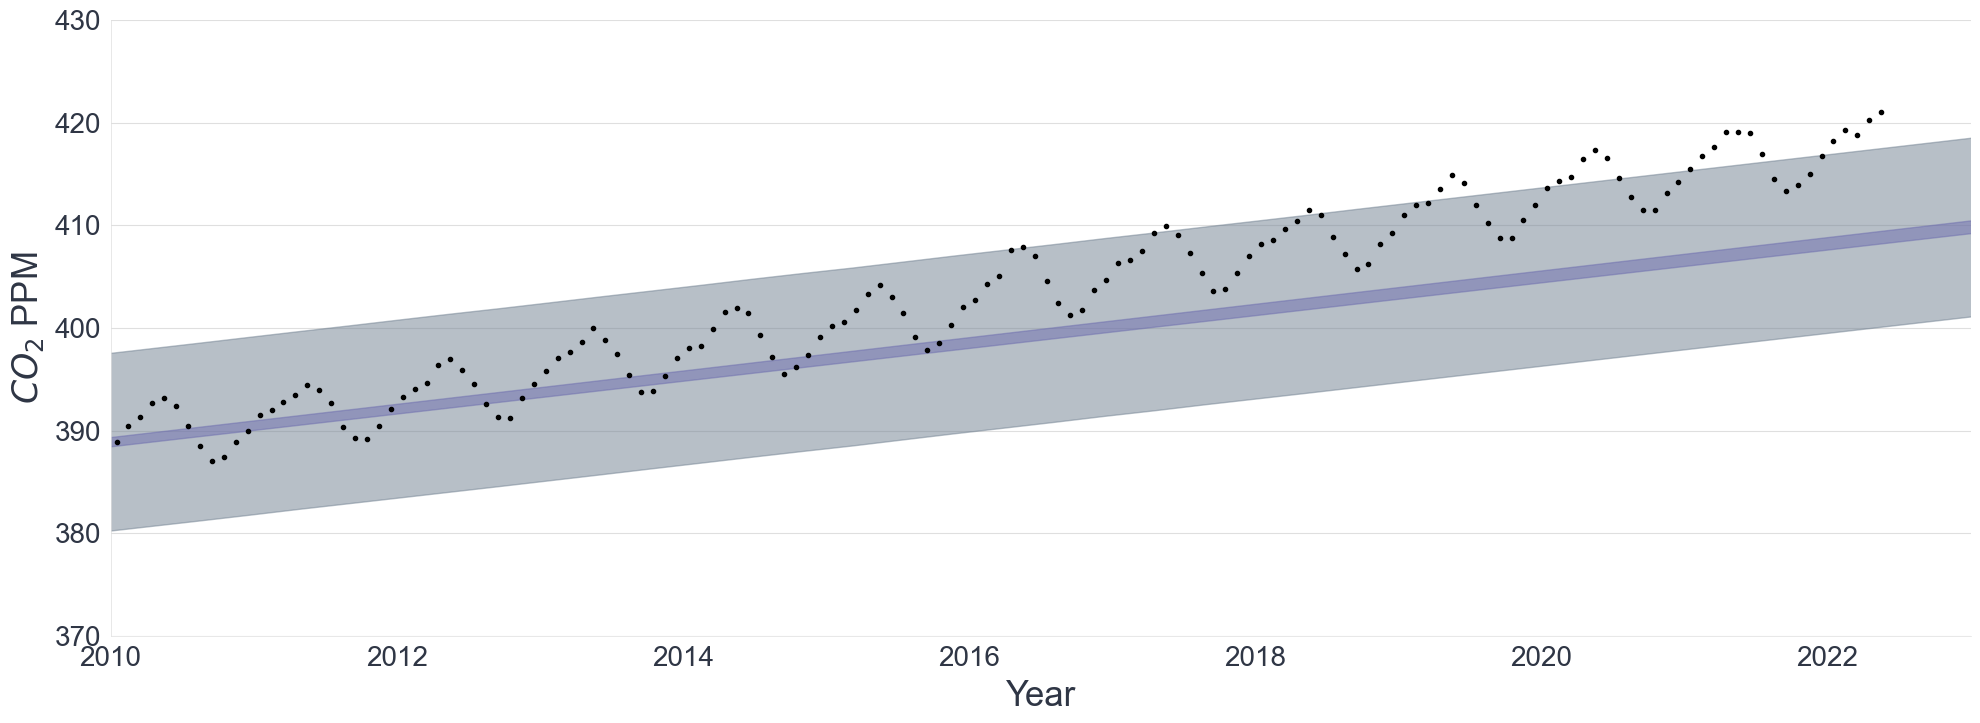

In [21]:
fig = plt.figure(figsize=(24,8))
ax = fig.gca()

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), ax=ax, color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), ax=ax, color="slategray")

ax.plot(data["decimal date"], data["average"], "k.");
ax.set_xlim(2010, 2023)
ax.set_ylim(370, 430)

ax.set_xlabel("Year")
ax.set_ylabel("$CO_2$ PPM");

If we zoom in again though we can more clearly see that there's an additional pattern missing. In the next sections we'll address this as well. For now let's talk through our section recap

## Section Recap
* Drew a single line using 
  * a elementary school method
  * Ordinary Least Square Regression
* Drew many lines using Bayesian Regression

</br>
</br>

### Key takeaways
* Functions take inputs and provide us estimates
  * Needed to estimate the parameters of the function
* We *assumed* a functional form mx+b
  * This strongly constrains how our function can fit the data


# A wiggly line
Adding more nuance

## Our Function and Plot

$$\text{CO2 Level} = mx + b$$

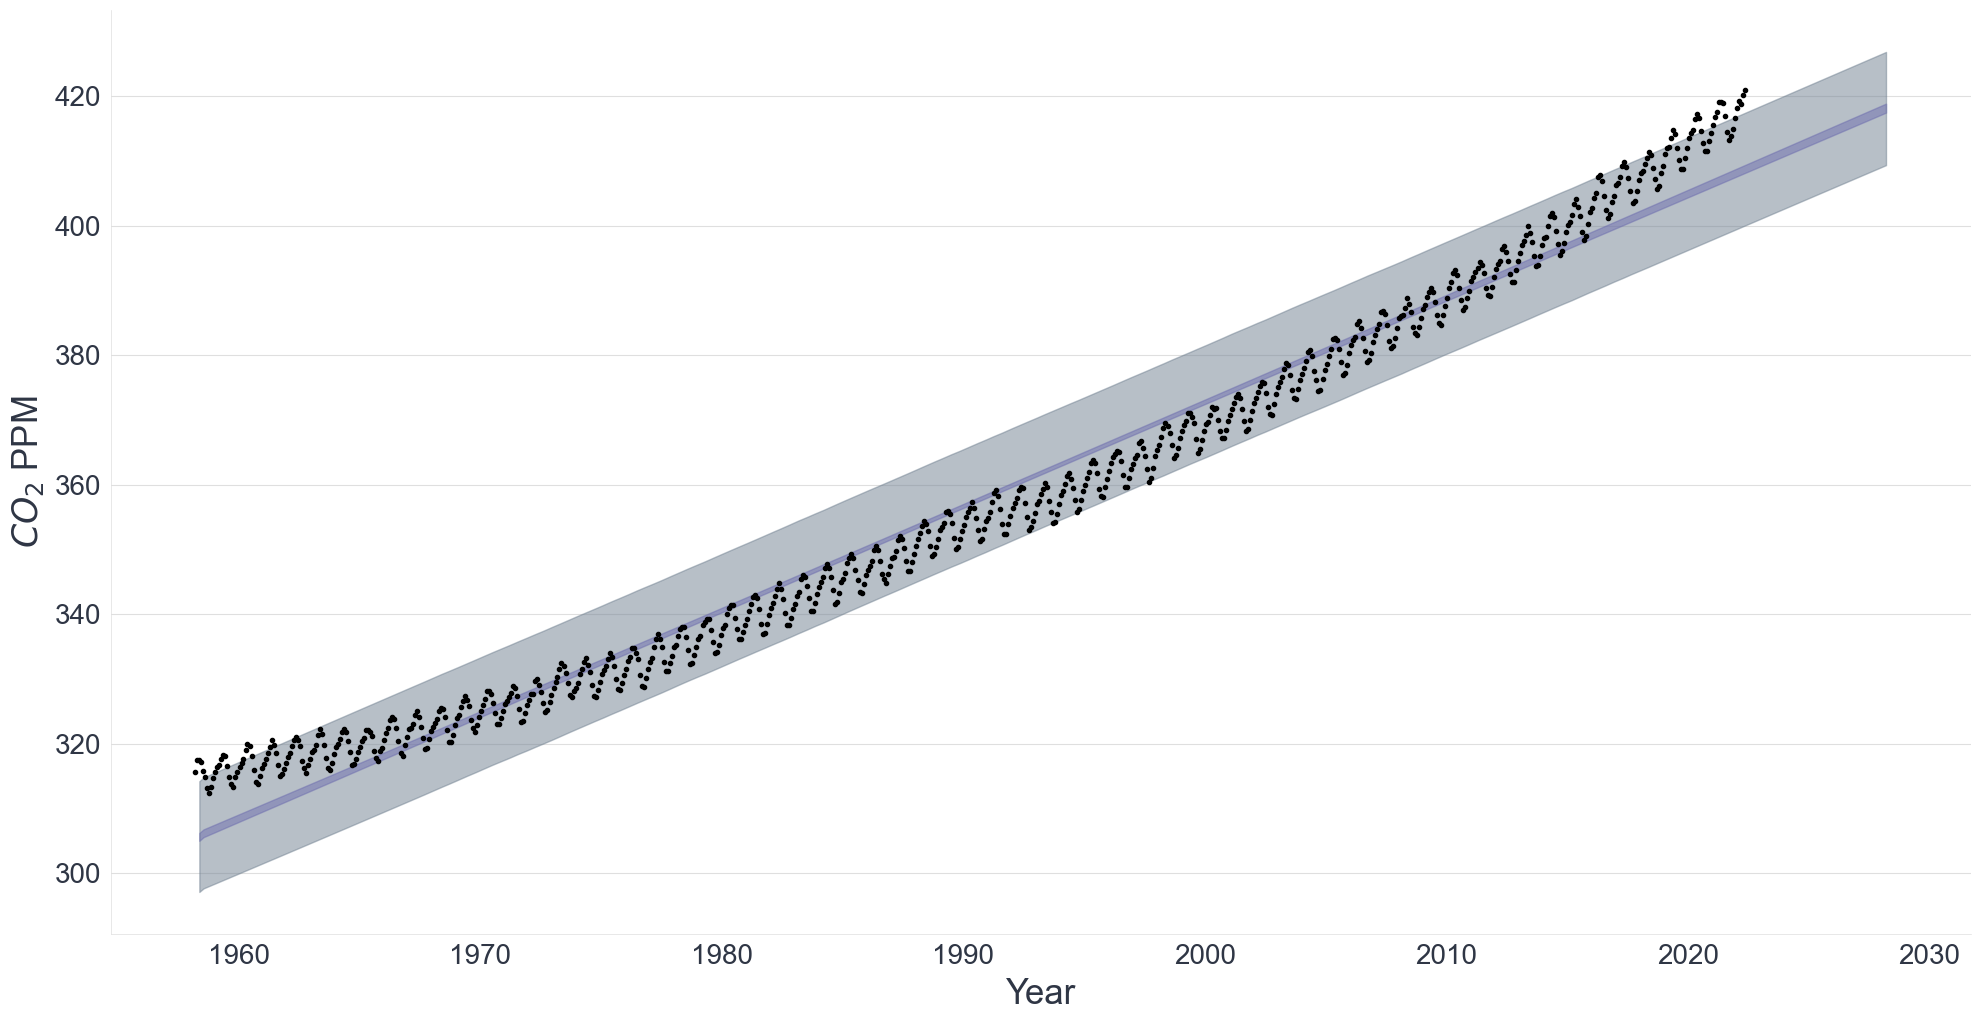

In [22]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

ax.scatter(data["decimal date"], data["average"], color="k");

ax.set_xlabel("Year")
ax.set_ylabel("$CO_2$ PPM");

In the last section we roughly we defined a linear model to capture the trend. We were able to estimate the parameters of that linear model using Bayesian methods. However because our model only defined a line, we can only get back different plausible straight lines.

## What about all periodicity?

After the rise, the annual cycle is the next most prominent feature.

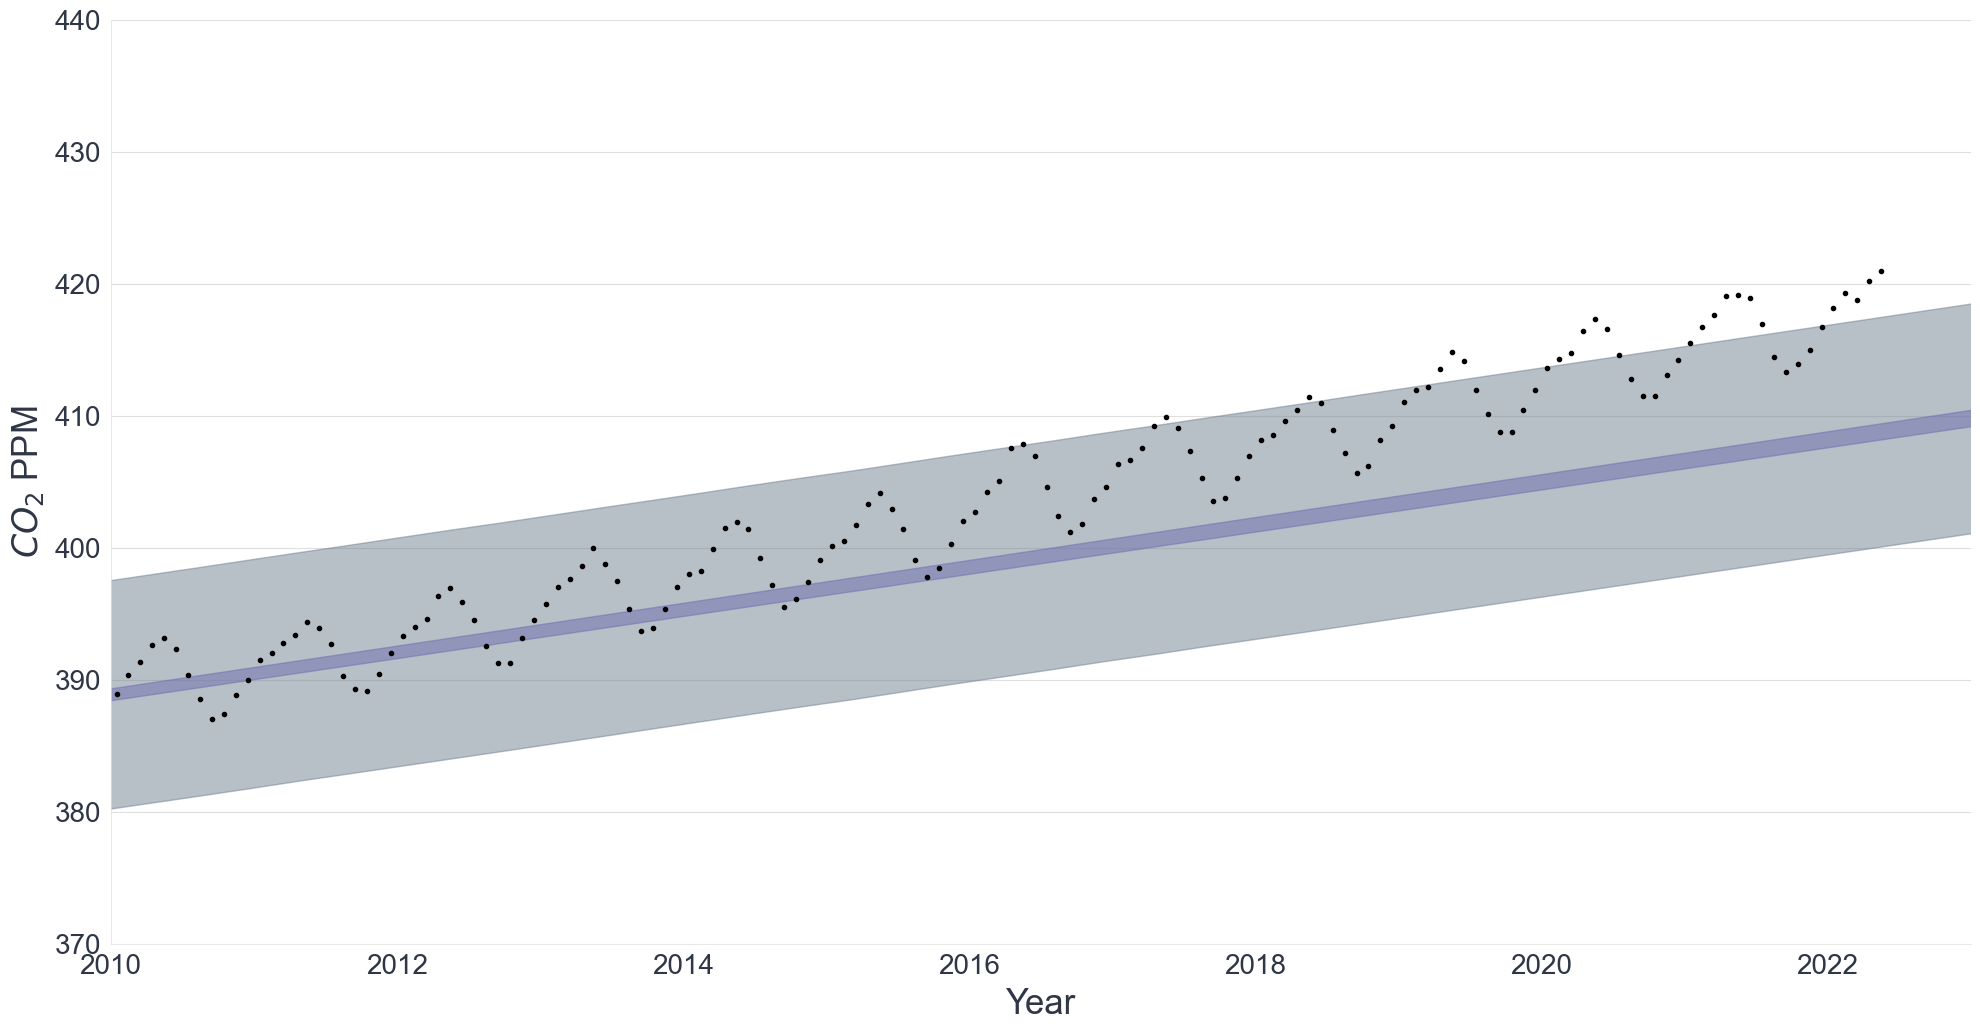

In [23]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), ax=ax, color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), ax=ax, color="slategray")

ax.scatter(data["decimal date"], data["average"], color="k");
ax.set_xlim(2010, 2023)
ax.set_ylim(370, 440)

ax.set_xlabel("Year")
ax.set_ylabel("$CO_2$ PPM");

We say that were missing the squigliness though, more specifically referred to are periodicity.

## Zooming in on one period, or cycle

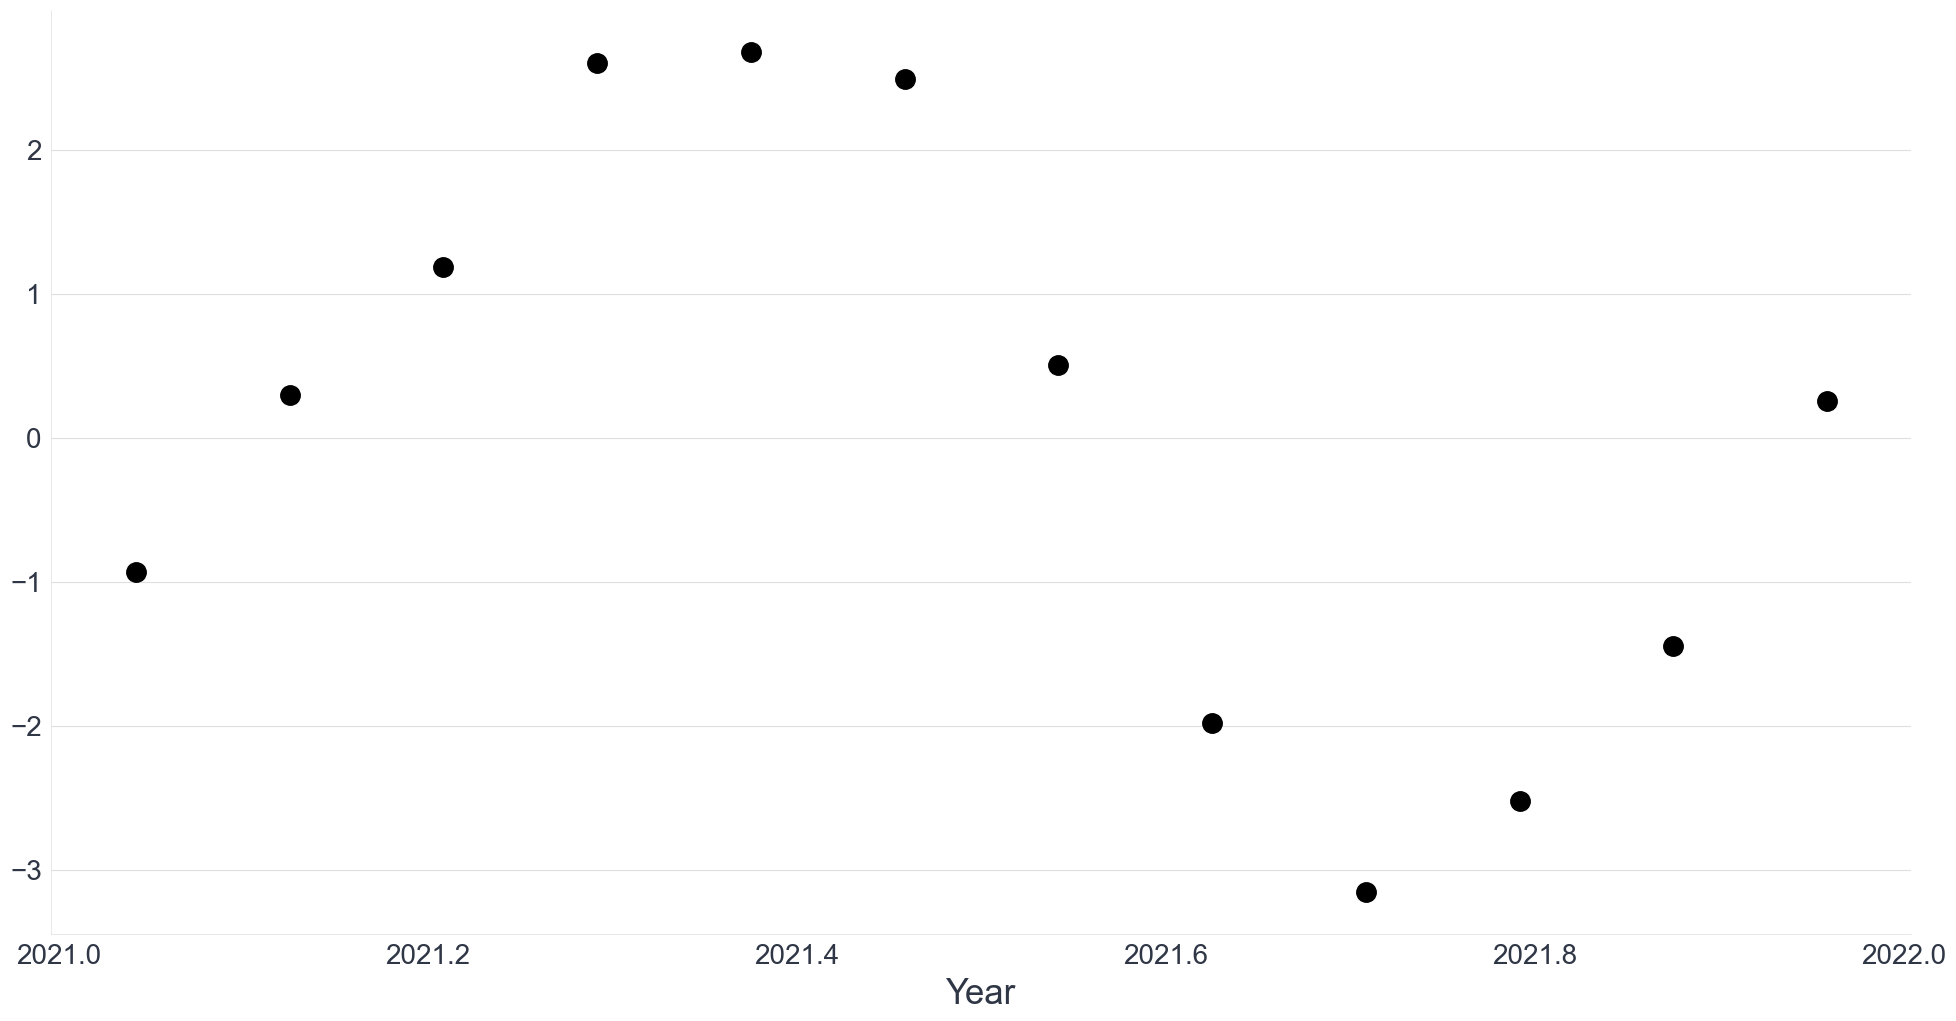

In [24]:
year = data[(data["decimal date"] > 2021) & (data["decimal date"] <= 2022)]

fig = plt.figure(figsize=figsize)
ax = fig.gca()

ax.plot(year["decimal date"], year["average"] - year["average"].mean(), "ko", markersize=14);
ax.set_xlabel("Year");

By inspecting these points up close we can see a familiar function. Try guessing what it is. We'll pause for a second to give a moment to think.

Did you say sine? Or did you guess cosine? Either way you're right

## Overlaying our random guess

$$\text{CO2 Level} = A \cos(2\pi f x + \phi)$$

In [25]:
year = data[(data["decimal date"] > 2021) & (data["decimal date"] <= 2022)]
A, f, ϕ = 3.0, 1.0, .7*np.pi
xl = np.linspace(year["decimal date"].min(), year["decimal date"].max(), 10000)
estimate = A*np.cos(2 * np.pi * f * xl - ϕ)

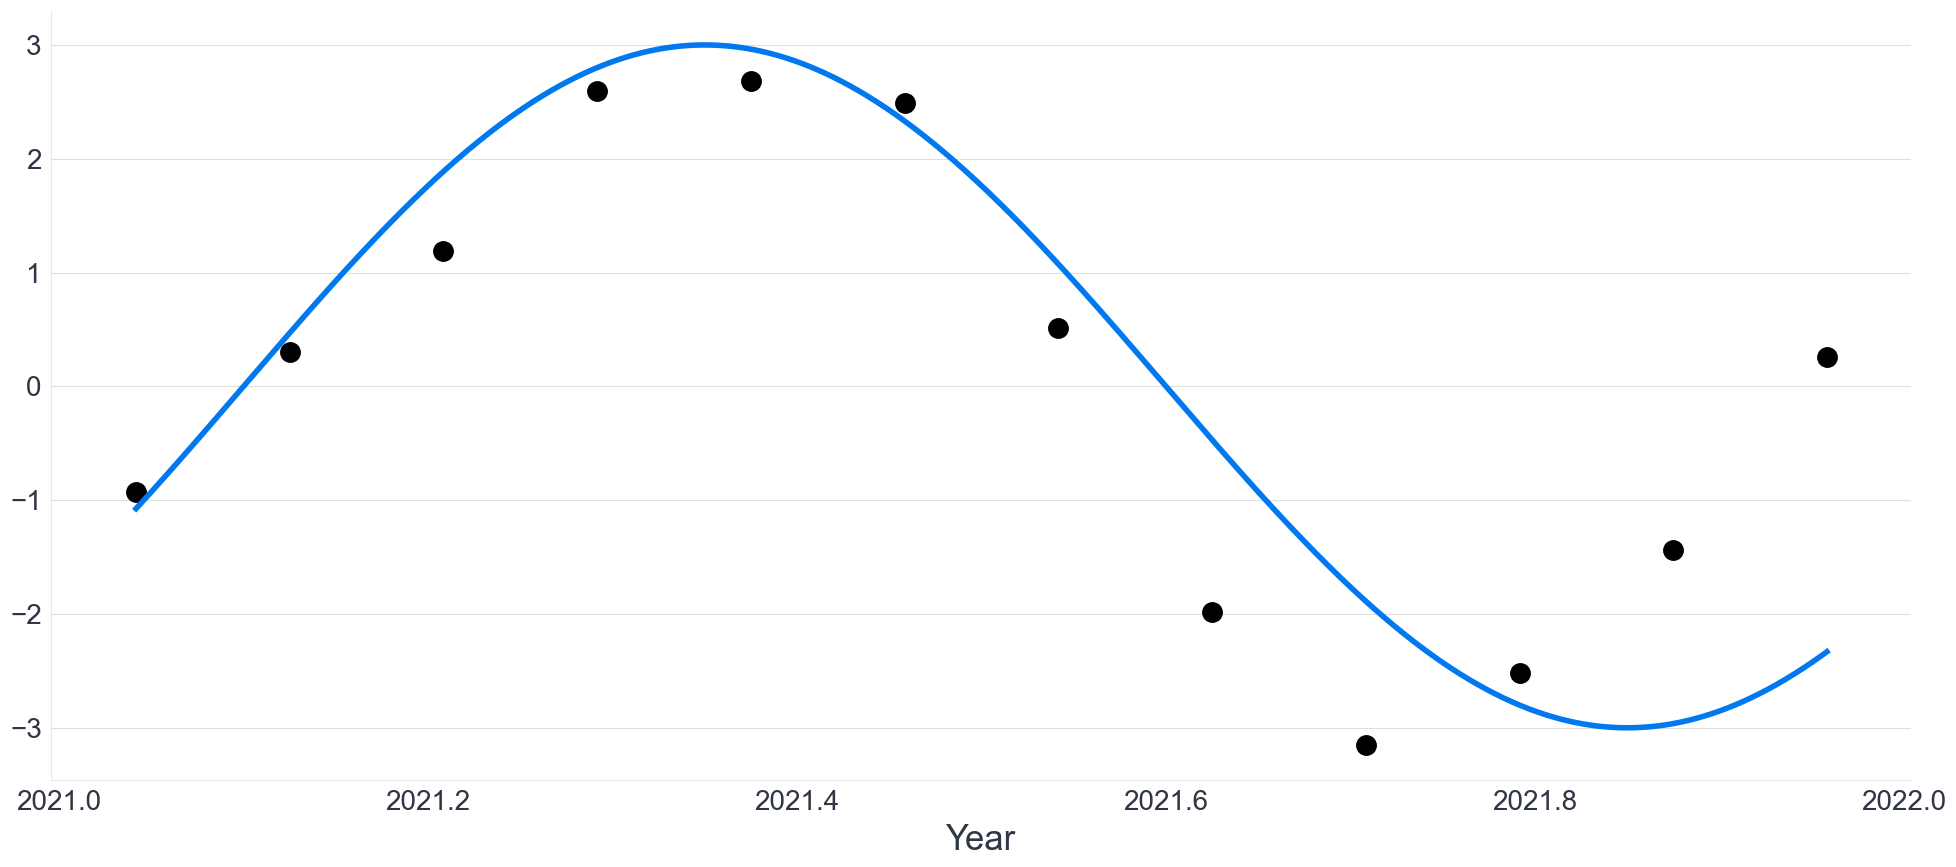

In [26]:
fig = plt.figure(figsize=(24,10))
ax = fig.gca()

ax.plot(year["decimal date"], year["average"] - year["average"].mean(), "ko", markersize=14);

ax.plot(xl, estimate)
ax.set_xlabel("Year");

Like our trend we can use use the cosine function parameterized by x, or year in this case, to model our data.

We guessed some parameters like before but it's great, there's certainly room for improvement.  This does give us some OK starting points though, and we can use these to help us set priors for our PyMC model.

- frequency $f$: 1 (cycle per year)
- amplitude $A$: 3.  After normalizing the observed data by subtracting the mean, we can see the cycle goes up and down from about -3 to 3. 
- phase $\phi$: $-\frac{\pi}{2}$, this gets cosine to start at zero and increase first, which sort of matches the data, but should be a free parameter in the model.

## Sine waves don't go up

In [27]:
data["decimal date"]
sin_component = 3*np.cos(2 * np.pi * xl),

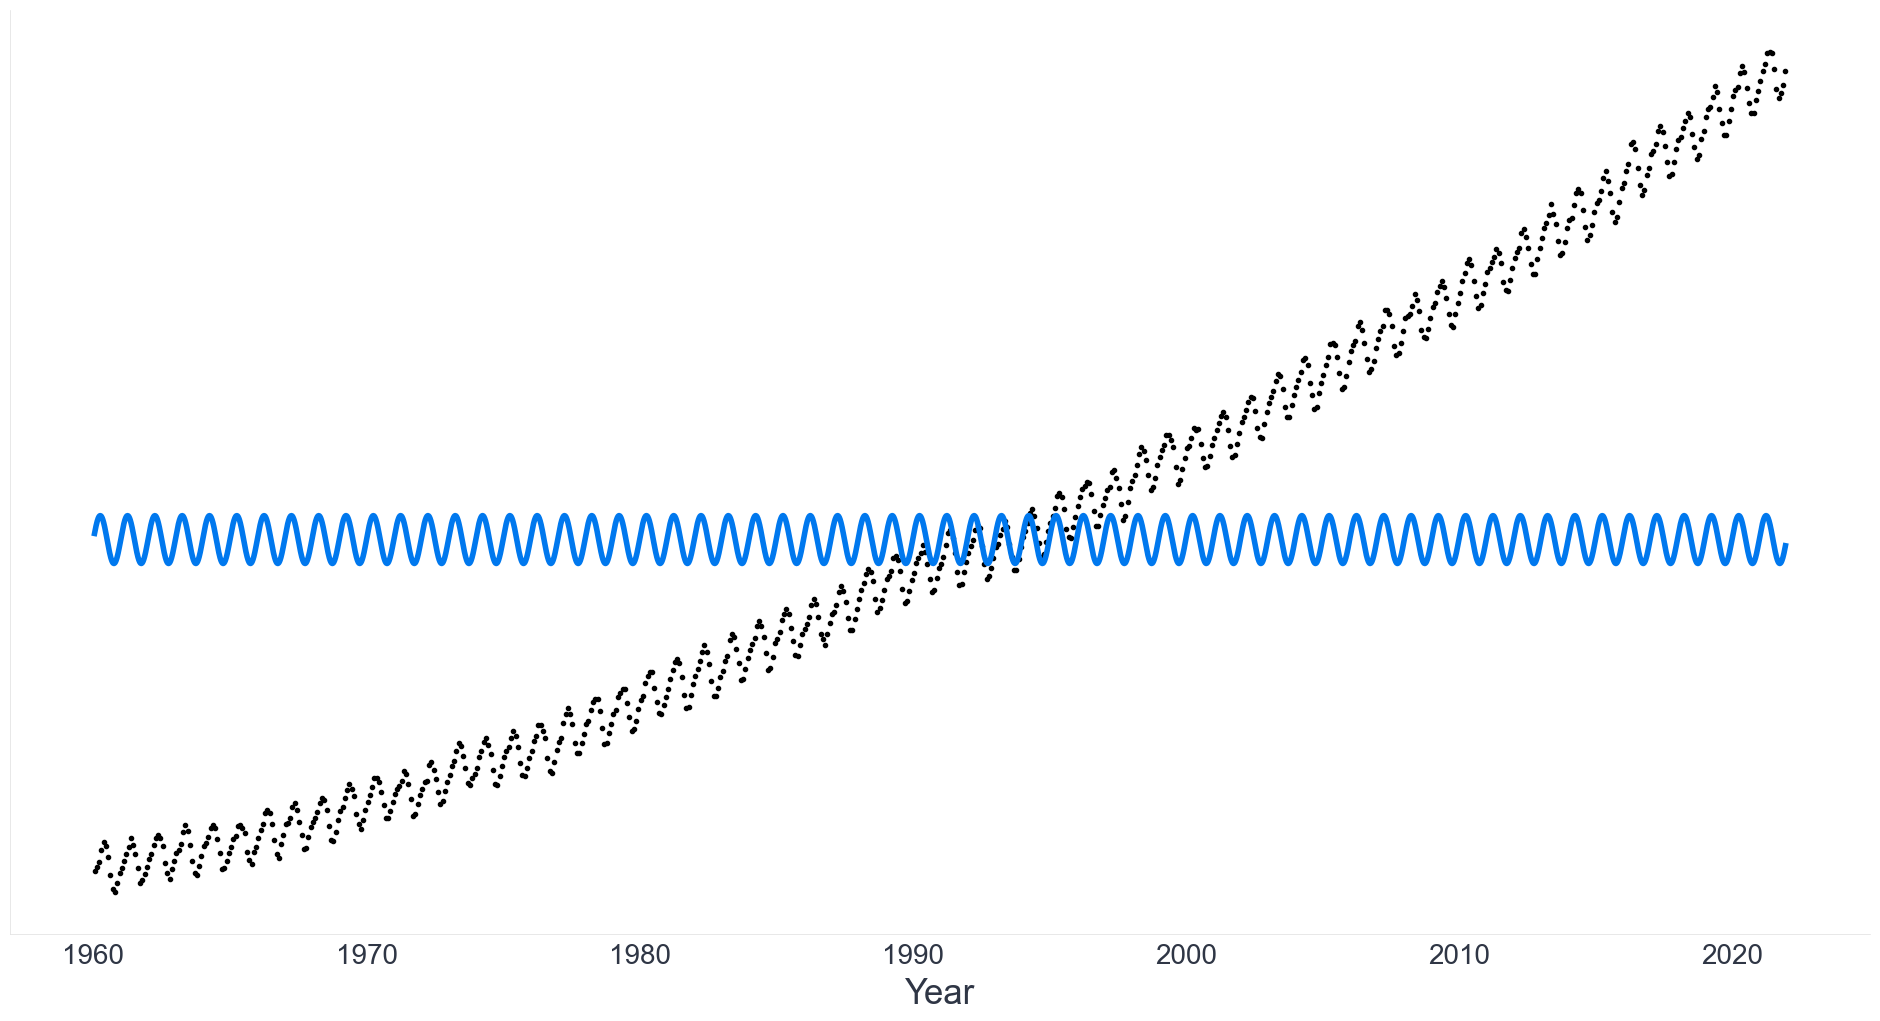

In [28]:
year = data[(data["decimal date"] > 1960) & (data["decimal date"] <= 2022)]

fig = plt.figure(figsize=figsize)
ax = plt.gca()

ax.scatter(year["decimal date"], year["average"] - year["average"].mean(), color="k");

xl = np.linspace(year["decimal date"].min(), year["decimal date"].max(), 10000)
ax.plot(xl, 3*np.cos(2 * np.pi * xl * 1.0 - 0.5 * np.pi))

ax.set_yticks([]);
ax.set_xlabel("Year");

We have another problem though, sine waves don't go up but we have a solution for that

## Additive models

In [29]:
xl = np.linspace(year["decimal date"].min(), year["decimal date"].max(), 10000)

sin_component = 3*np.cos(2 * np.pi * xl * 1.0 - 0.5 * np.pi)

# We got these from the Bayesian estimation
m, b = 1.6, 306
linear_component = m*(xl-year["decimal date"].min()) + b

squiggly_line = linear_component + sin_component   

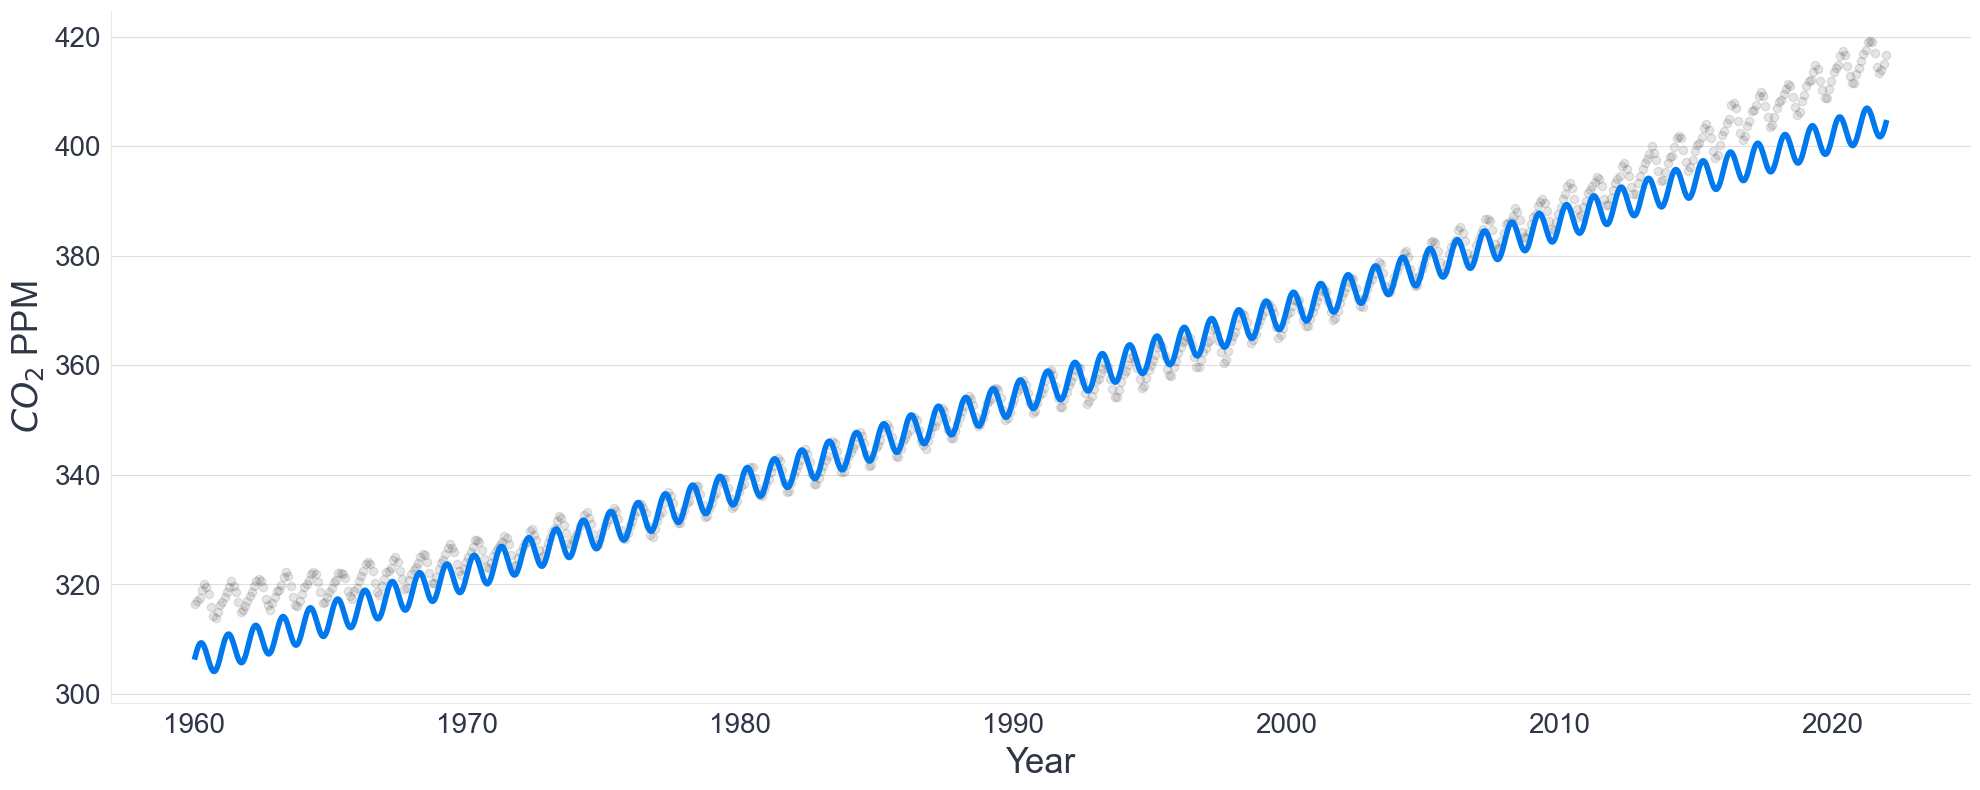

In [30]:
fig = plt.figure(figsize=(24,9))
ax = plt.gca()

ax.plot(year["decimal date"], year["average"], "ko", alpha=.1);
ax.plot(xl, squiggly_line)

ax.set_ylabel("$CO_2$ PPM")
ax.set_xlabel("Year");

What we could do is add our linear term and our sin wave together to create a new model. Now we get the effects of both together.  Instead of guessing parameters let's use Bayesian methods to estimate our parameters again.

## Bayesian Additive model

In [31]:
with pm.Model() as model:
    b = pm.Normal("b", mu=300, sigma=100)
    m = pm.Normal("m", mu=0.0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    x_ = pm.MutableData("x", data["decimal date"] - data["decimal date"].min())
    mu_linear = pm.Deterministic("mu_linear", m * x_ + b)
    
    # Additional terms for cosine component
    A = pm.HalfNormal("A", sigma=5)
    phi = pm.Normal("phi", mu=-np.pi / 2, sigma=0.1)
    freq = pm.Normal("freq", mu=1.0, sigma=0.1)
    mu_periodic = pm.Deterministic("mu_periodic", A * pm.math.cos(2 * np.pi * x_ * freq + phi))
    
    # Add the two together
    mu = pm.Deterministic("mu", mu_linear + mu_periodic)
    
    pm.Normal("y", mu=mu, sigma=sigma, observed=data["average"])
    
    
with model:
    idata = pm.sample(tune=2000, chains=2, target_accept=0.98, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m, sigma, A, phi, freq]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 44 seconds.


You'll notice a couple of extra terms now to model the periodic component

## Our parameter estimates for the linear component

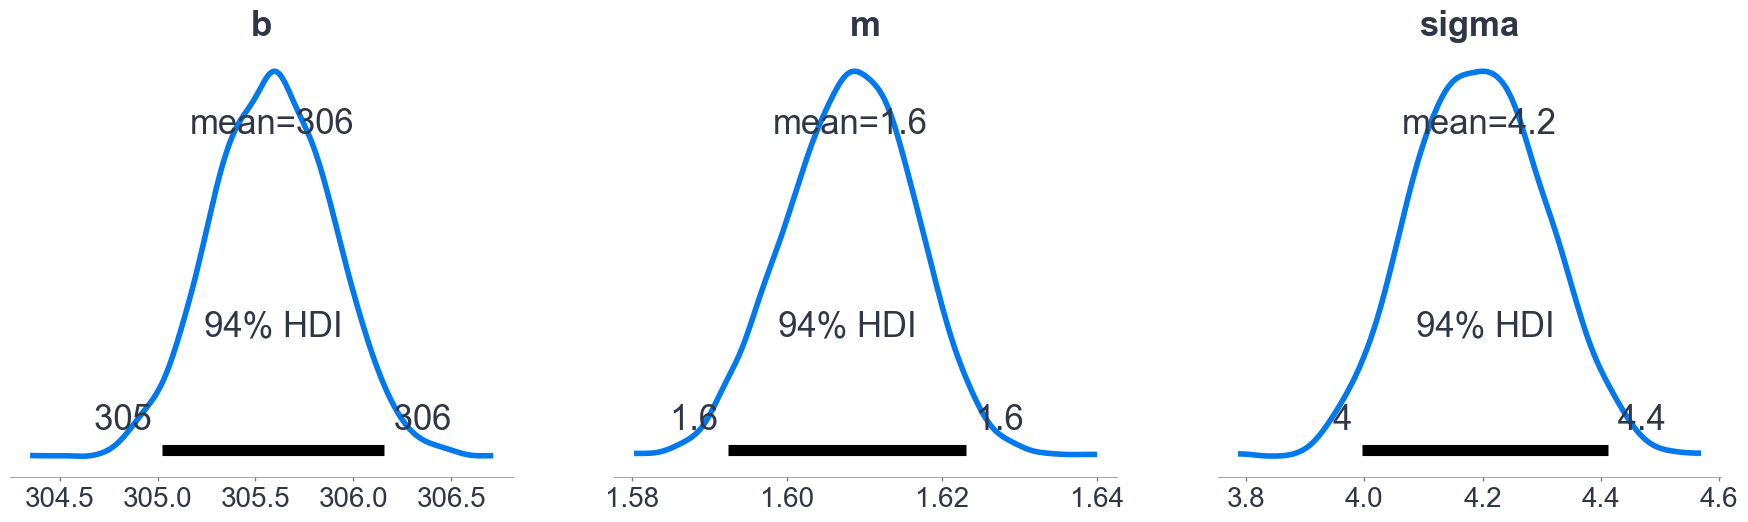

In [32]:
az.plot_posterior(idata.posterior, var_names=["b", "m", "sigma"]);


## Our parameter estimates for the period component

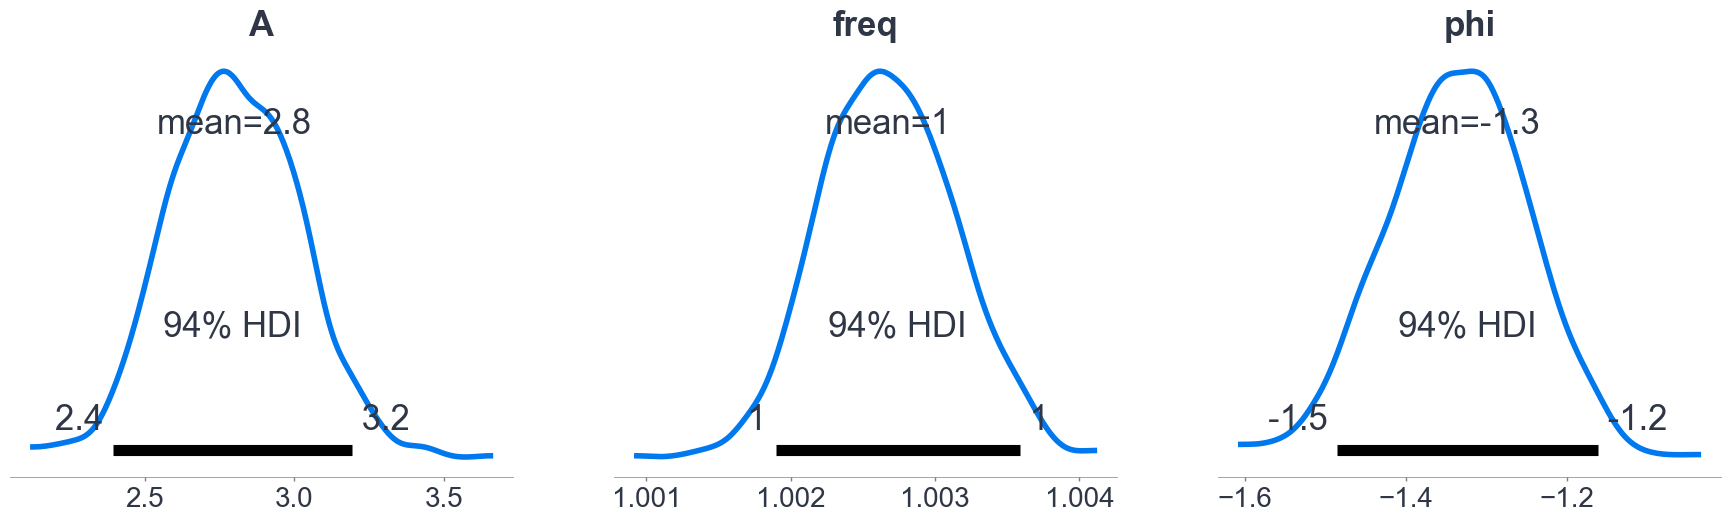

In [33]:
az.plot_posterior(idata.posterior, var_names=["A", "freq", "phi"]);

Now using ArviZ let's plot the posterior 

- It was a bit tricky to get the sampler to converge, but now it looks like the results are sensible.  The parameter estimates are also somewhat in line with our guesses.  
- Now lets look at the posterior predictive and draw some samples

## Making predictions

In [34]:
xl = np.linspace(0, 70, 1000)

with model:
    pm.set_data({'x': xl})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])
    idata.extend(ppc)

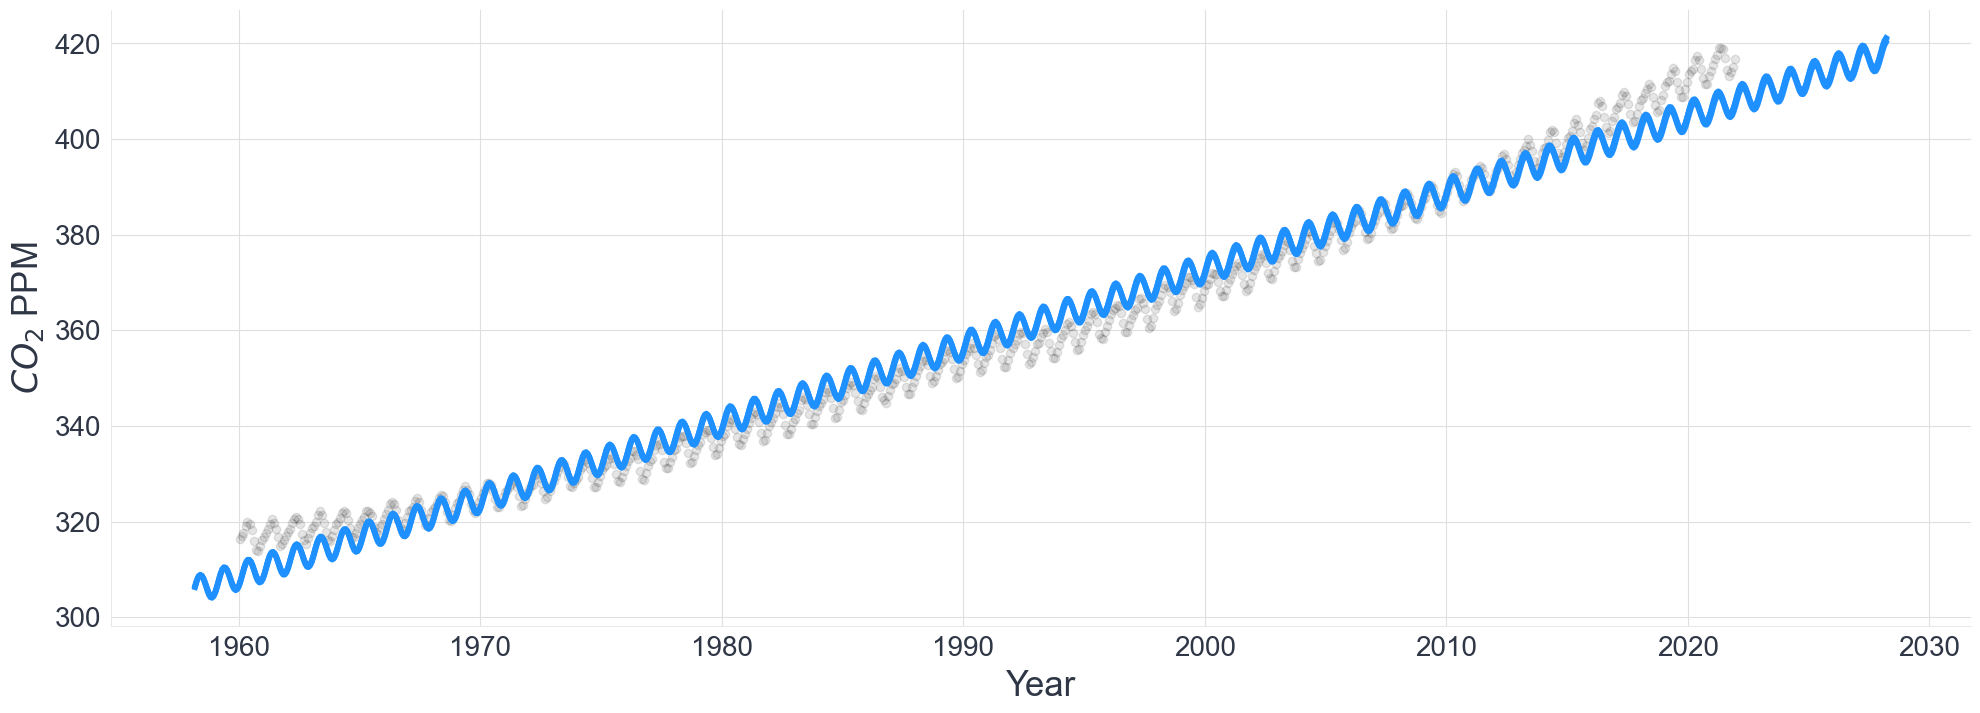

In [35]:
fig = plt.figure(figsize=(24,8))
ax = plt.gca()

mu_samples = idata.posterior_predictive.mu.stack(sample=["chain", "draw"]).isel(sample=[1,2,3]).values

ax.plot(year["decimal date"], year["average"], "ko", alpha=.1);
ax.plot(xl + data["decimal date"].min(), mu_samples, color='dodgerblue')

ax.grid(True)
ax.set_ylabel("$CO_2$ PPM")
ax.set_xlabel("Year");

 - The results look similar to the straight line model, except when we look at individual samples of `mu` we can see the seasonal pattern reflected. 
- Lets zoom in also and look at the small scale structure

## Zooming into our posterior predictive

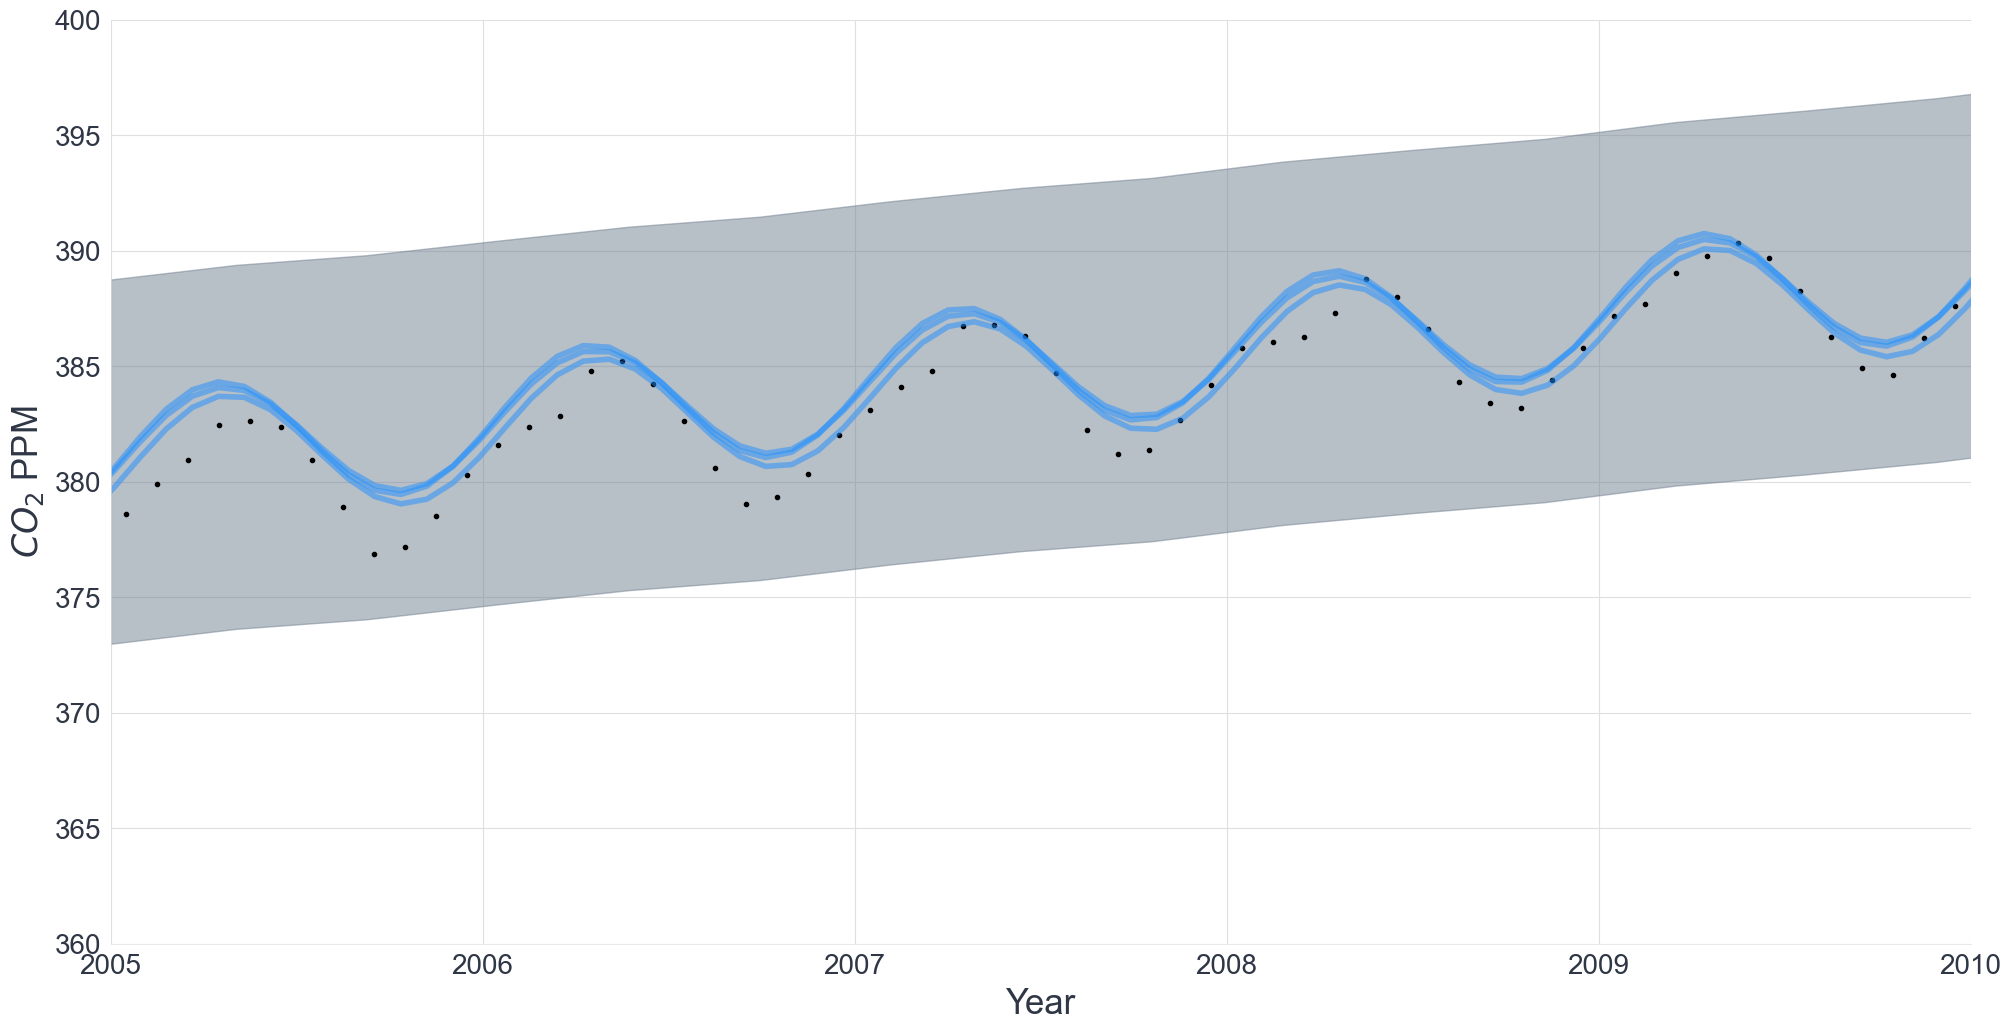

In [36]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), ax=ax, color="slategray")

mu_samples = idata.posterior_predictive.mu.stack(sample=["chain", "draw"]).isel(sample=[1,2,3]).values

ax.plot(data["decimal date"], data["average"], "k.");
ax.plot(xl + data["decimal date"].min(), mu_samples, color='dodgerblue', alpha=0.5);

ax.grid(True);
ax.set_xlim([2005, 2010]);
ax.set_ylim([360, 400]);
ax.set_ylabel("$CO_2$ PPM")
ax.set_xlabel("Year");

Even at the best looking part of the curve, there are still obvious issues still here.

What is wrong:
- Linear term seems insufficient.  Upward increasing trend
- "Cosine" seems insufficient.  Is it a perfect sine wave?  Or is something that's almost a sine wave, but still has a repeating pattern.
- How much more fine structure are we missing in the data?

Now you might say well lets go add another function, but where does it stop?

- With this functional approach, nothing stops us from forecasting infinitely far into the future.  Is that reasonable?

## The steps to our current approach

1. Guess at a functional form of the series
2. Estimate parameters for that function
3. See what's wrong
4. Go back to step 1

Continuing with this approach, what might we try?  Coming up with functional forms is difficult and it doesnt always work!  Also, how much do we care about these parameters? We might just to know what the CO2 levels might be, not necssarily care about the components of the model or their parameters

Now don't get us wrong, additive models are a valid approach in many situations, but that's not our case. Nor is this is the right course! The good news is there is another approach, but before we get ahead of ourselves lets talk through our section recap

## Section Recap
* Functions can be added together to create new models
  * Known as additive models
* The modeler still needs to decide what the functions are
  * And estimate the parameters even if they're not if interest
* With the C02 estimation even with an extended additive model there's issues

# Art a different way
There's more than one way to draw a curve

## Mondrian's Art Style

<center>
  <img src="img/Mondrian.jpg"  />
</center>

When we said art class we weren't kidding. Here's piece of art from Mondrian and as you can tell he had a very particular mindset when making this

## Jackson Pollock's Art Style

<center>
  <img src="img/Pollock.jpg" style="height:750px";/>
</center>

And here's one from Jackson Pollock. Its still art, but there's a very different mentality behind how it was created. Keep that in mind as we introduce a new "art" style for our Mauna Loa challege in this section

## Revisiting our linear fit

In [37]:
data = pd.read_csv("data/co2_mm_mlo.csv", header=51)

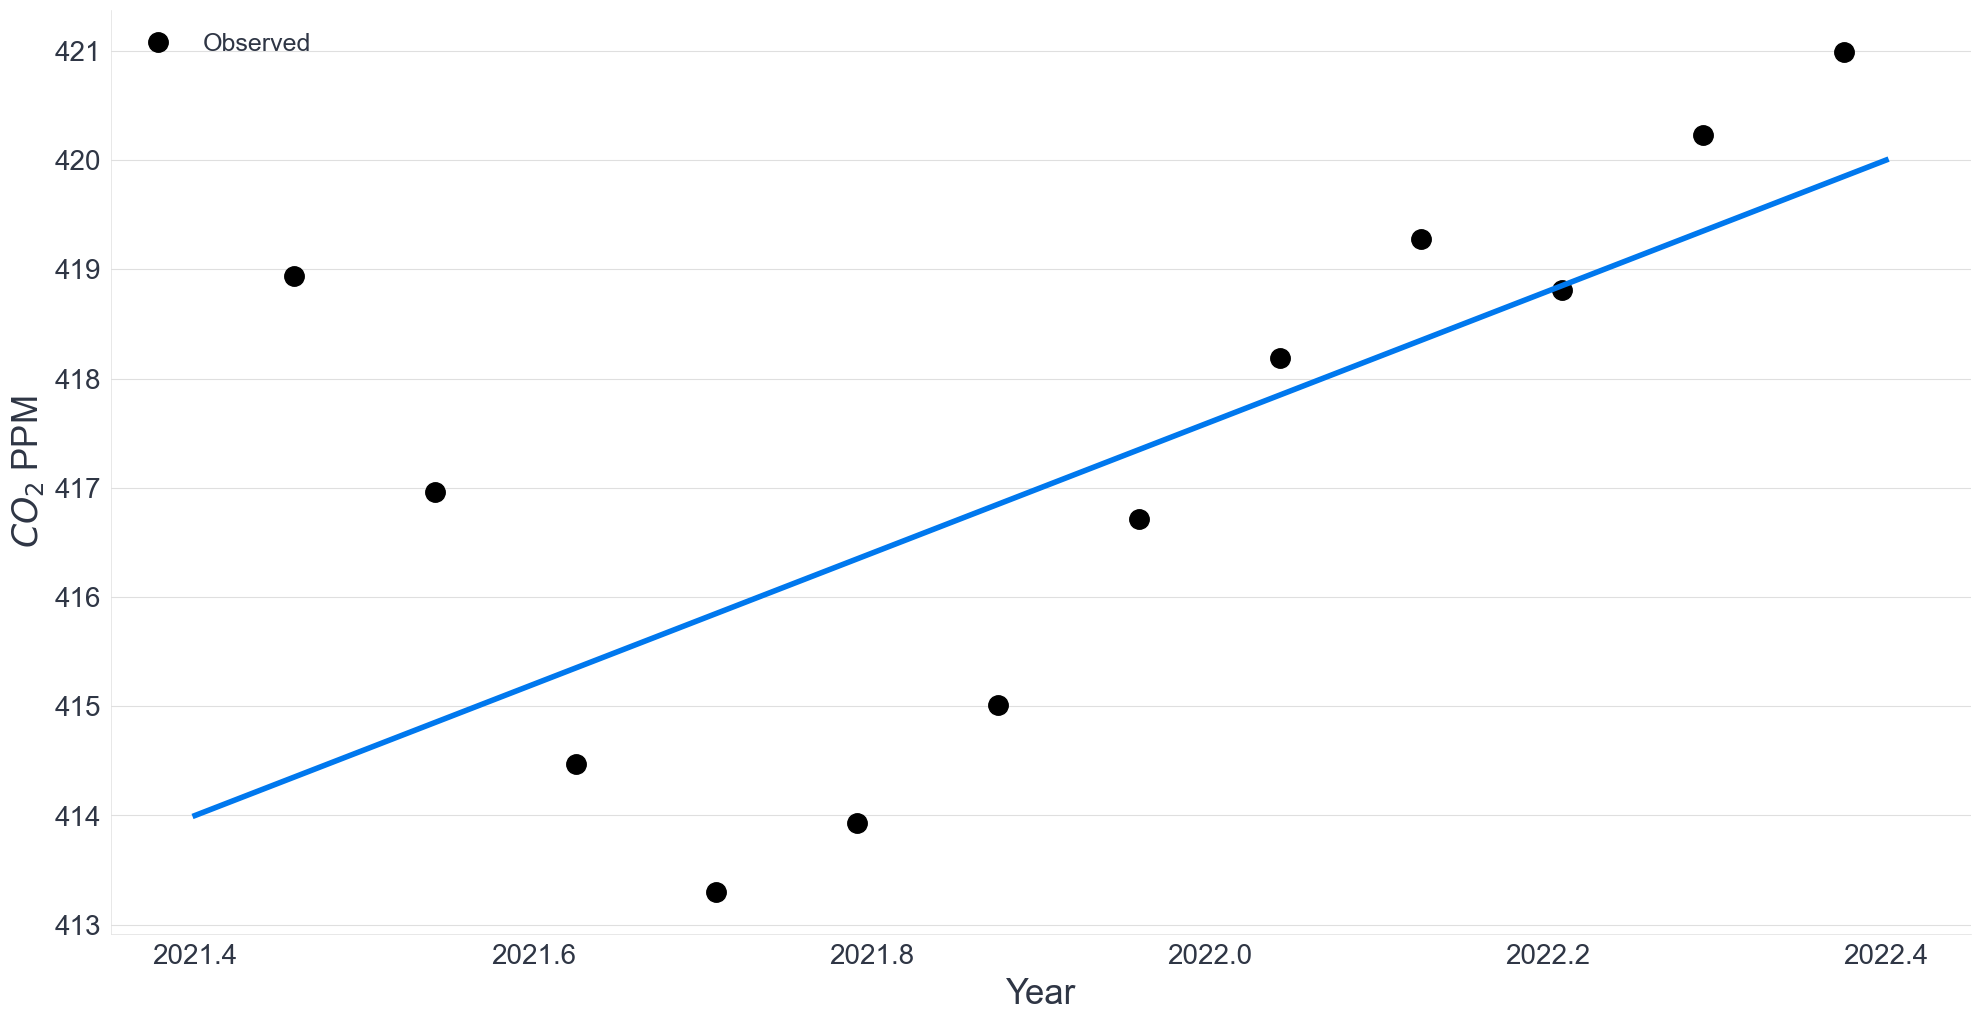

In [38]:
last_12_obs = data.sort_values("decimal date").tail(12)

# These are just guesses, need replace with the real OLD estimate
rise = 6
min_x, max_x = 2021.4, 2022.4
run = 2022.4 - min_x

m = rise/run
b = last_12_obs["average"].min()

fig, ax = plt.subplots(figsize=figsize)

def plot_data(ax):
    ax.plot(last_12_obs["decimal date"], last_12_obs["average"], "ko", markersize=14, label="Observed")
    ax.set_xlabel("Year")
    ax.set_ylabel("$CO_2$ PPM");
    return

def plot_best_fit_line(ax):
    x_est = np.linspace(min_x, max_x, 100)
    y_est = m*(x_est - min_x) + 414
    ax.plot(x_est, y_est)
    return

plot_data(ax)
plot_best_fit_line(ax)
plt.legend();

Let's revisit our Mondrian style analysis. Remember our goal here is to estimate the C02 levels on any date, not just the observed dates. 

We decided to use a line as our first model. Here's the line we fit we fit earlier. Because we're currently fitting lines like Mondrian we're fixed to a strict functional fit. Given that this is the best we could do.

## Revisiting *how* we got to this line

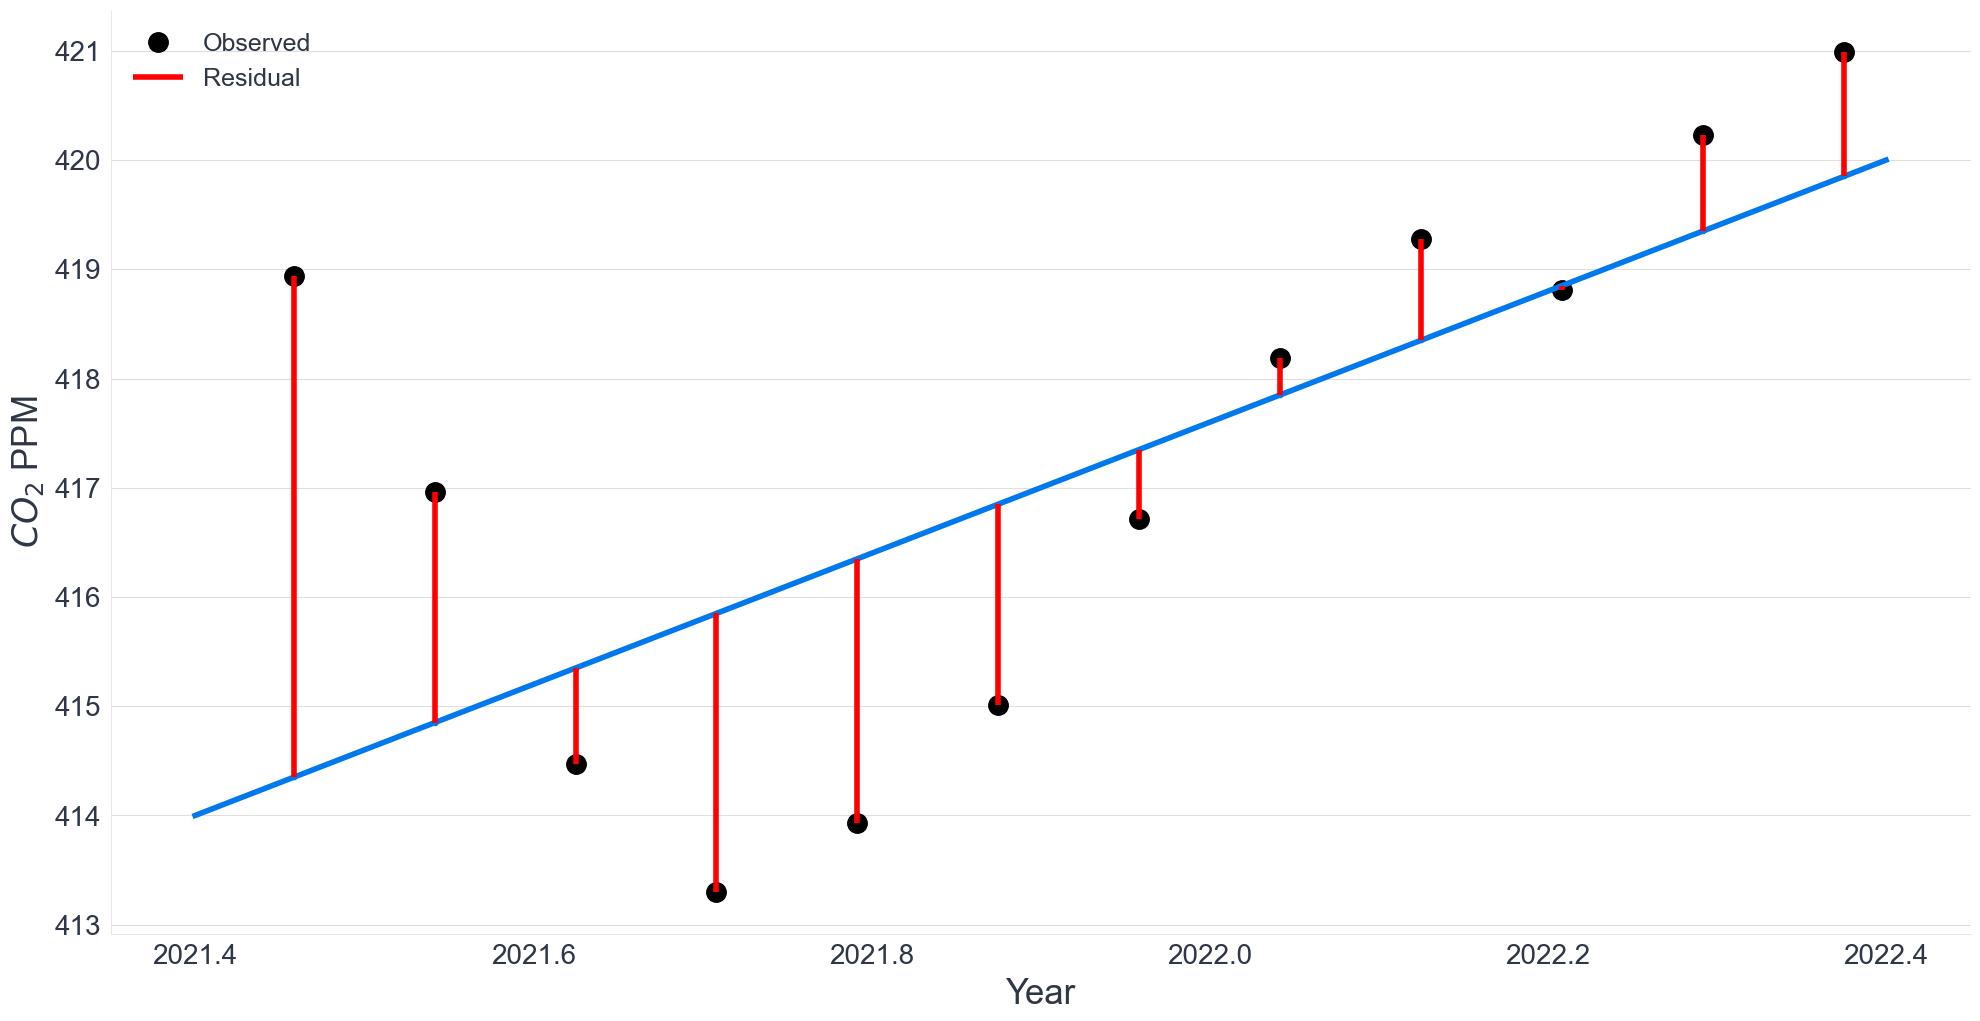

In [39]:
fig, ax = plt.subplots(figsize=figsize)

plot_data(ax)
plot_best_fit_line(ax)


# Plot Residuals
y_est_obs = m*(last_12_obs["decimal date"] - min_x) + 414

for x, y_obs, y_est in zip(last_12_obs["decimal date"].values, y_est_obs, last_12_obs["average"]):
    if x == last_12_obs["decimal date"].min():
        label = "Residual"
    else:
        label= ""
    plt.vlines(x, np.min([y_obs, y_est]), np.max([y_obs, y_est]), label=label, color="r")

ax.scatter(last_12_obs["decimal date"], y_est_obs)

plt.legend();

## The individual steps


1. Defined a functional model
  * $$\text{CO2 Level} = mx+b$$

2. Determined the "best" parameters given **all** the observed data
  * By using evaluating the "y" distance between our observation and our estimate

3. With the functional model and parameters we can make a prediction at **any** x'

Here's the steps for us to get here. We...

The red lines here are the residuals that we're trying to minimize so we can get the "tighest" line

## Our Prediction for 2021.916

In [40]:
date_of_interest = 2021.916

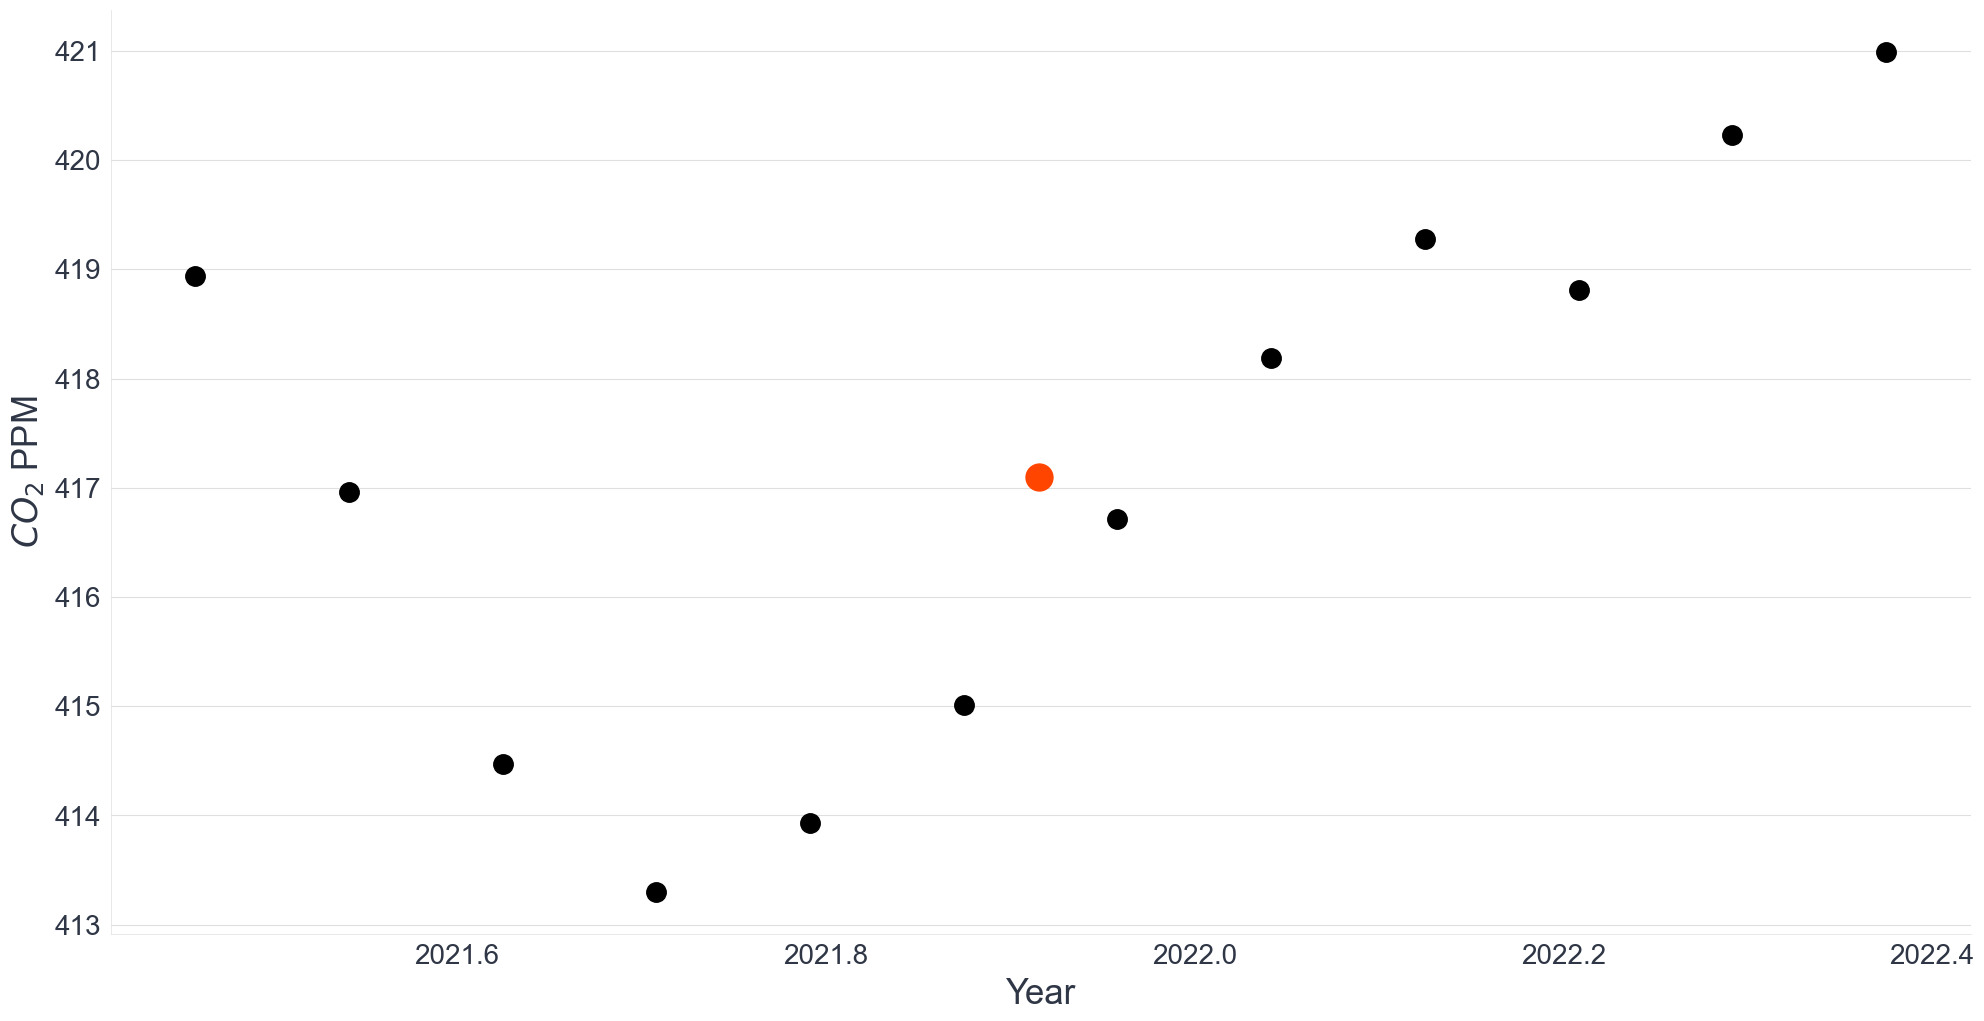

In [41]:
fig, ax = plt.subplots(figsize=figsize)
plot_data(ax)

est_2022 = m*(date_of_interest - min_x) + 414
plt.scatter(date_of_interest, est_2022, c="orangered", s=1500);

## Rethinking our estimate for 2021.916

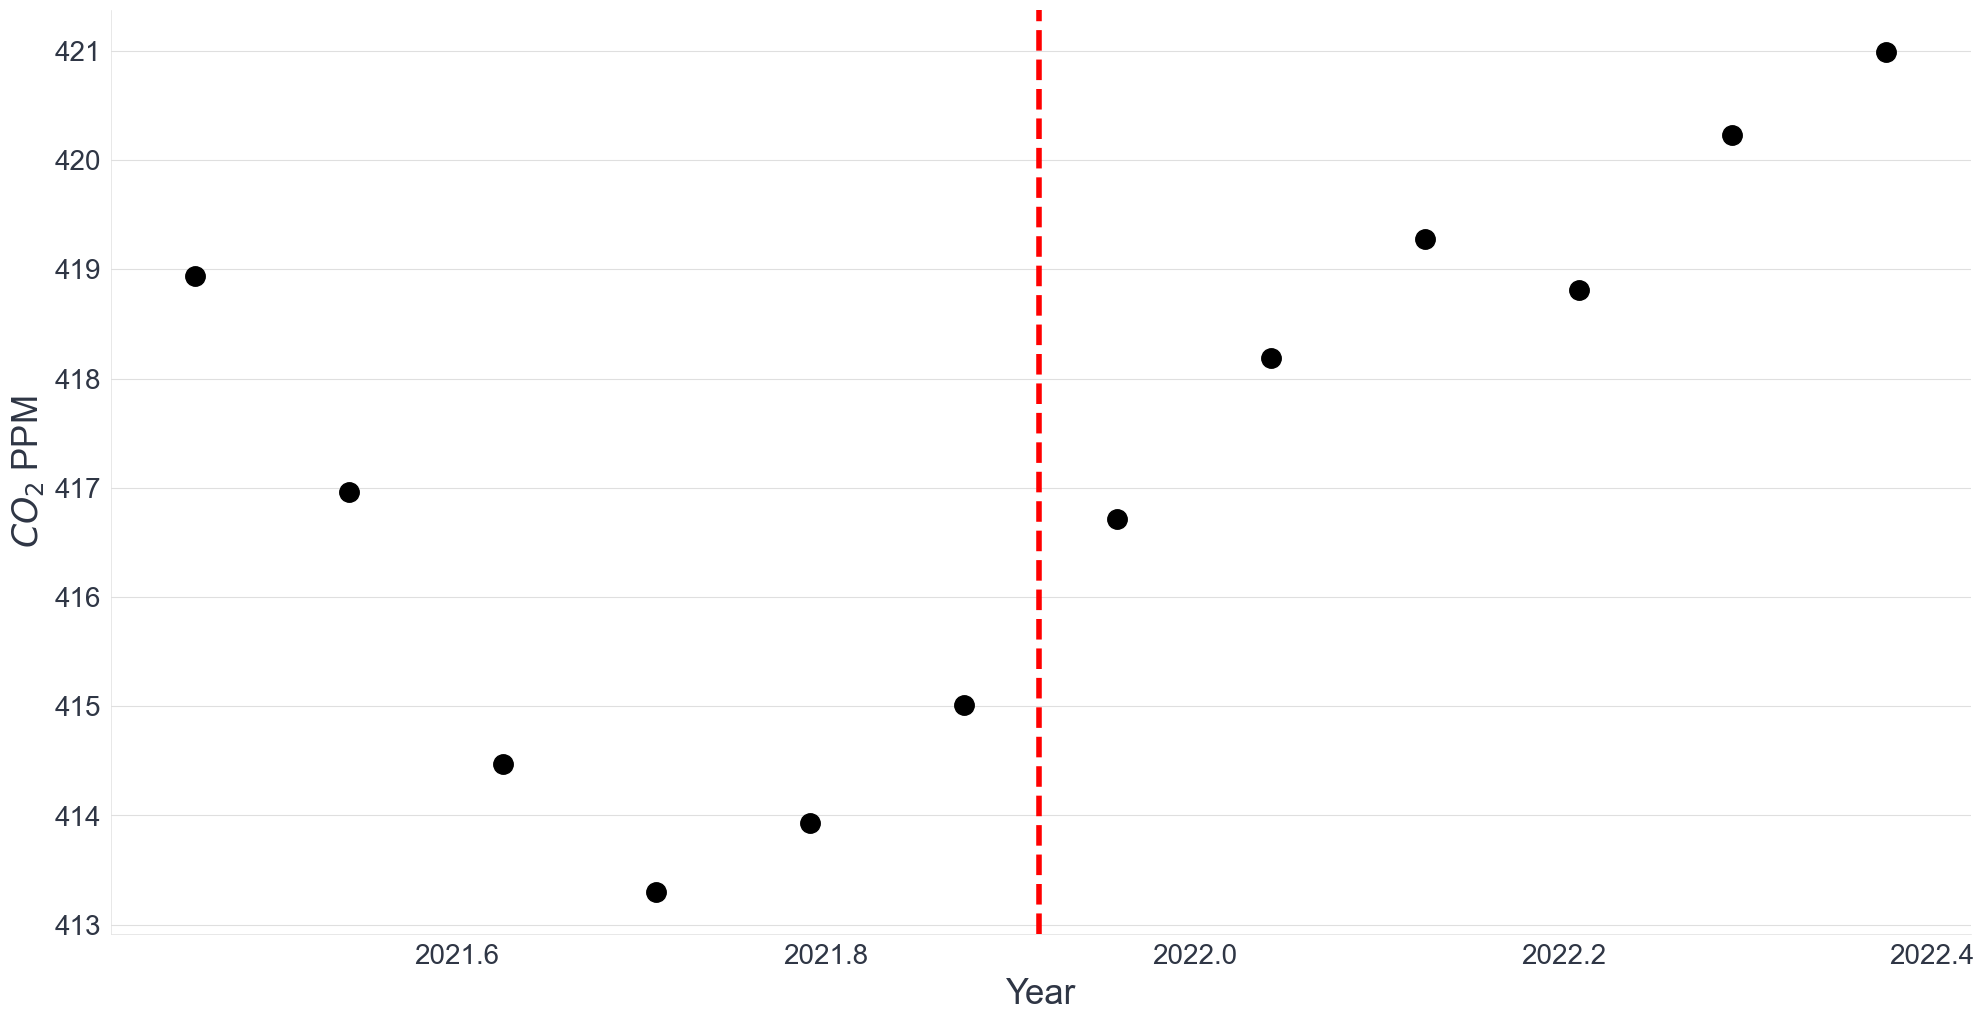

In [42]:
fig, ax = plt.subplots(figsize=figsize)

plot_data(ax)
ax.axvline(date_of_interest, linestyle="--", color="r");

Let's just focus on one date. 2021.916 If we needed pick a point for this what where would we put it?

If we use our previous approach, since were just minimizing sum of squares, the error for this dot way far on the left, can have a greater impact for our prediction at 2022, than the points right next to 2022 our point of interest.

** Fadi highlight dot all the way to the left, and then one right next

## Four possible estimated C02 Levels

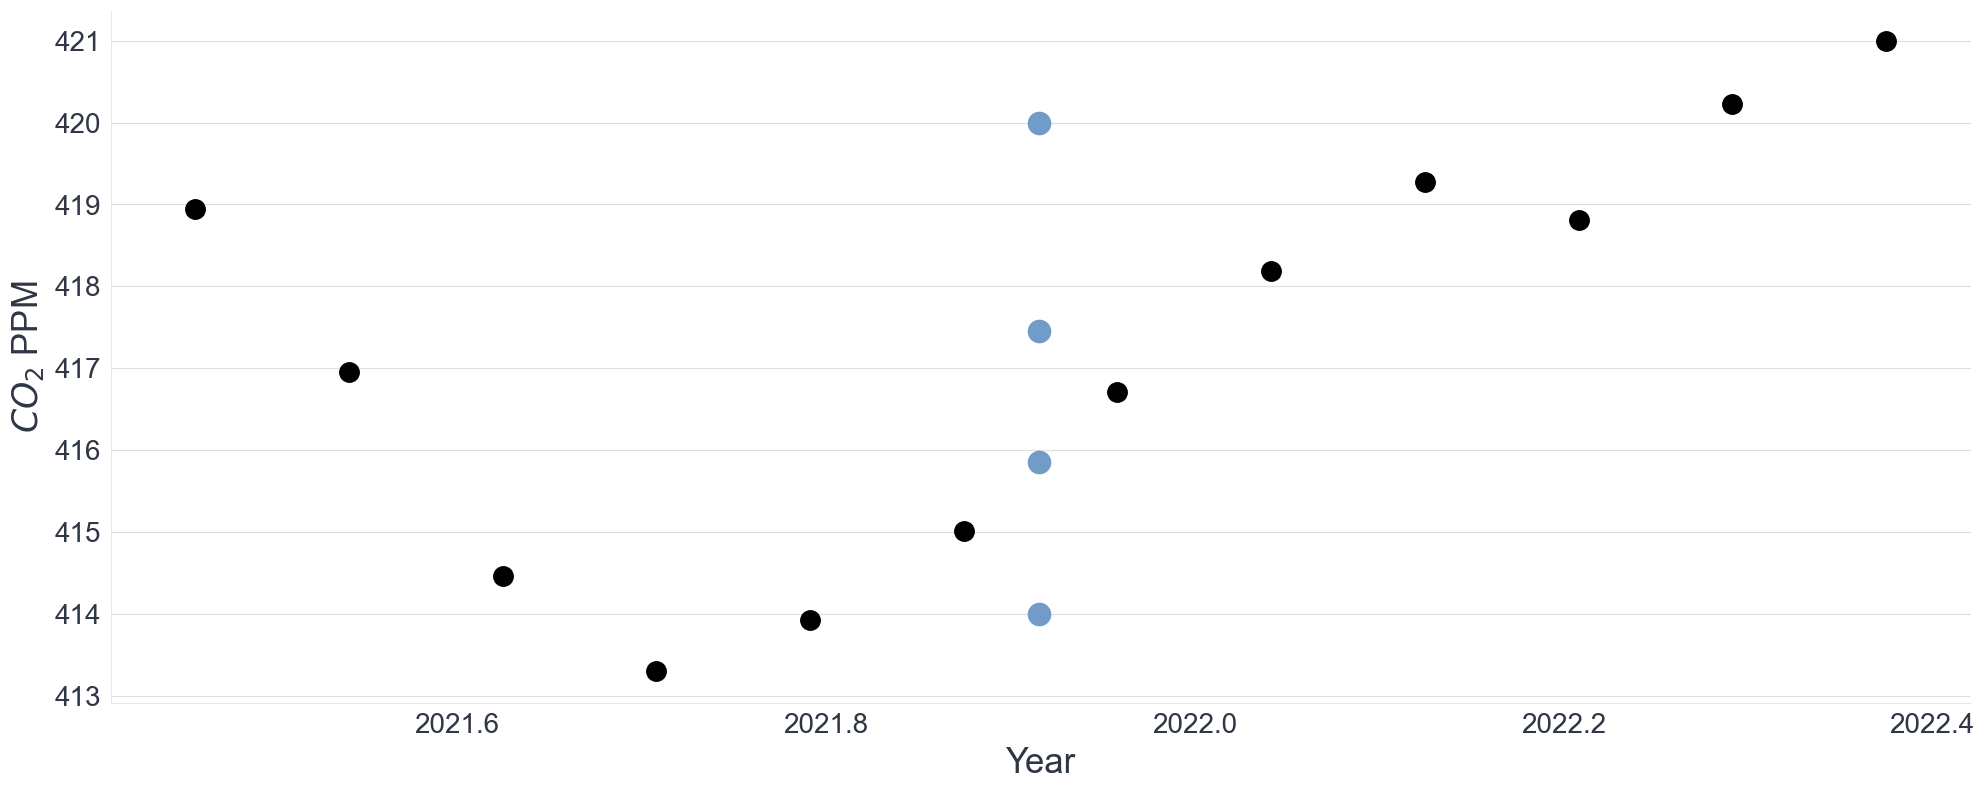

In [43]:
fig, ax = plt.subplots(figsize=(24,9))

plot_data(ax)

y_vals = (414, 415.86, 417.45, 420)
for y_val in y_vals:
    ax.plot(date_of_interest, y_val, marker="o", c="C5", markersize=16)

## Using our intuition to make estimates

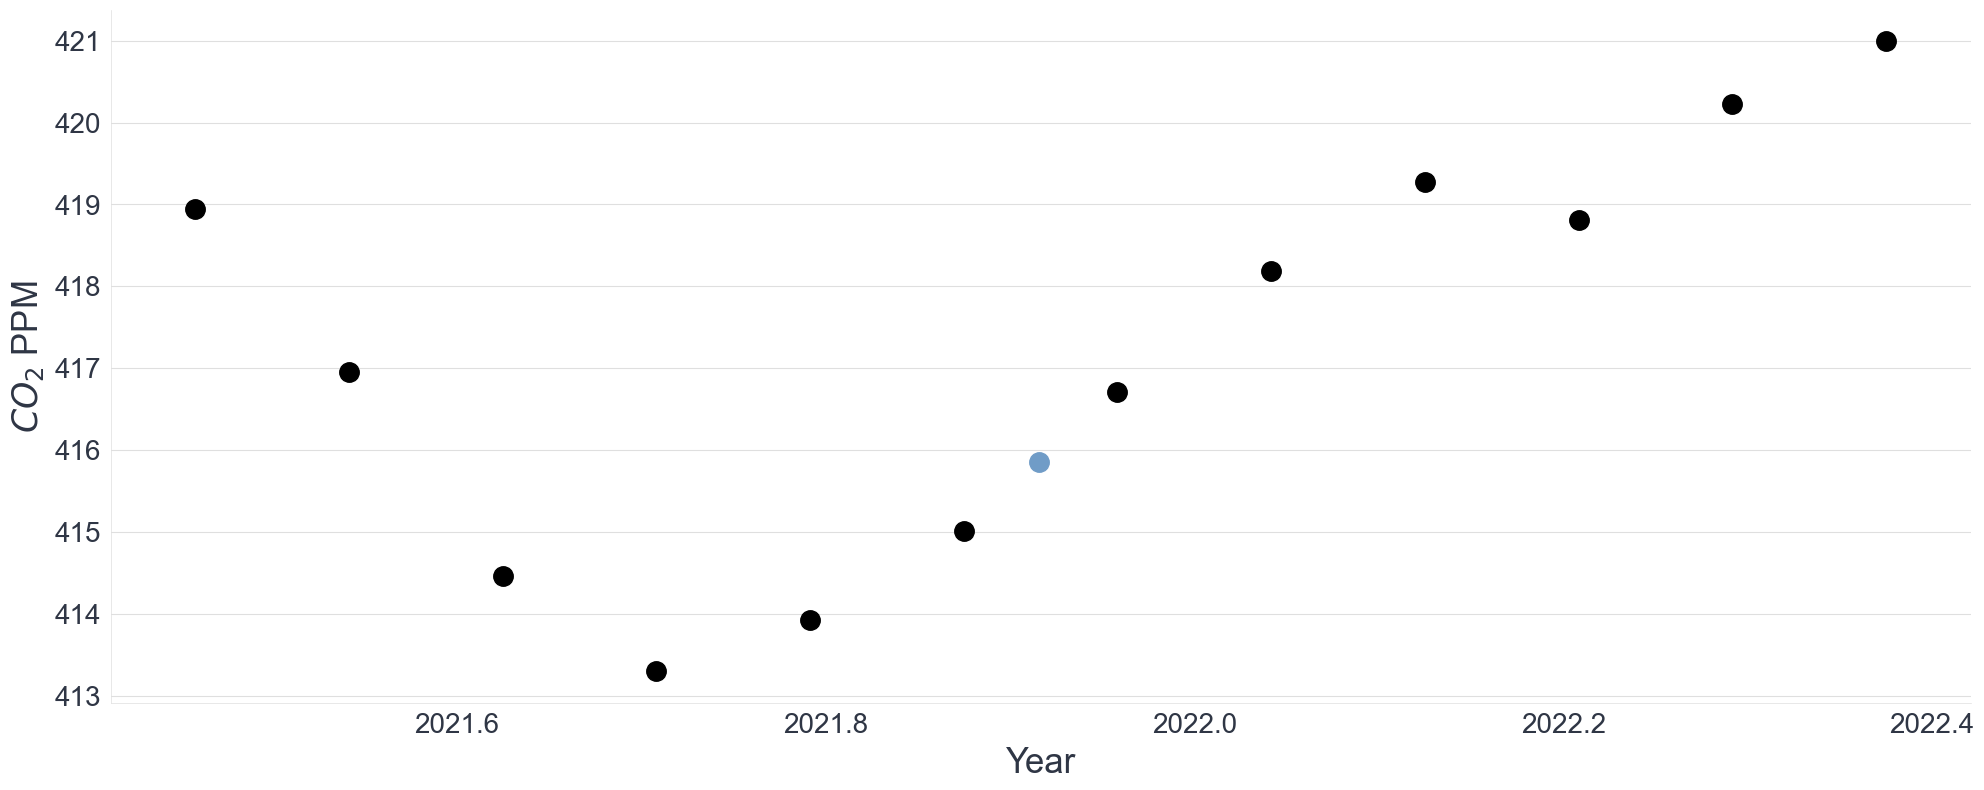

In [44]:
fig, ax = plt.subplots(figsize=(24,9))

plot_data(ax)

ax.plot(date_of_interest, y_vals[1], marker="o", c="C5", markersize=14);

Our guess is you took a look at the points that were closest to 2021.9. That would be the one to the left and the right of the out date of interest. You then "eyed out" where the correct placement was. That's what we did too.

We also believe you *did not* consider these points all the way to the left and the right, or if you did they mattered a lot less than the immediately adjacent points

## Formalizing our intuition

In [45]:
(last_12_obs
     # Get the distance to all other points
    .assign(distance=np.abs(last_12_obs["decimal date"] - date_of_interest))
     
     # Sort by distance
    .sort_values("distance")
 
     # Take the top two
    .head(2)
 
     # Get the average
     ["average"].mean())

415.86

Because were mathematicians we can formalize this. We can take the values of the two points closest and take the average to figure out the y distance.

Lets do that again here for this point and this point. So far so good right! 

Writing down our steps.

1. Look at the two closest points
2. Take the average

##  Freeing ourselves of the functional form


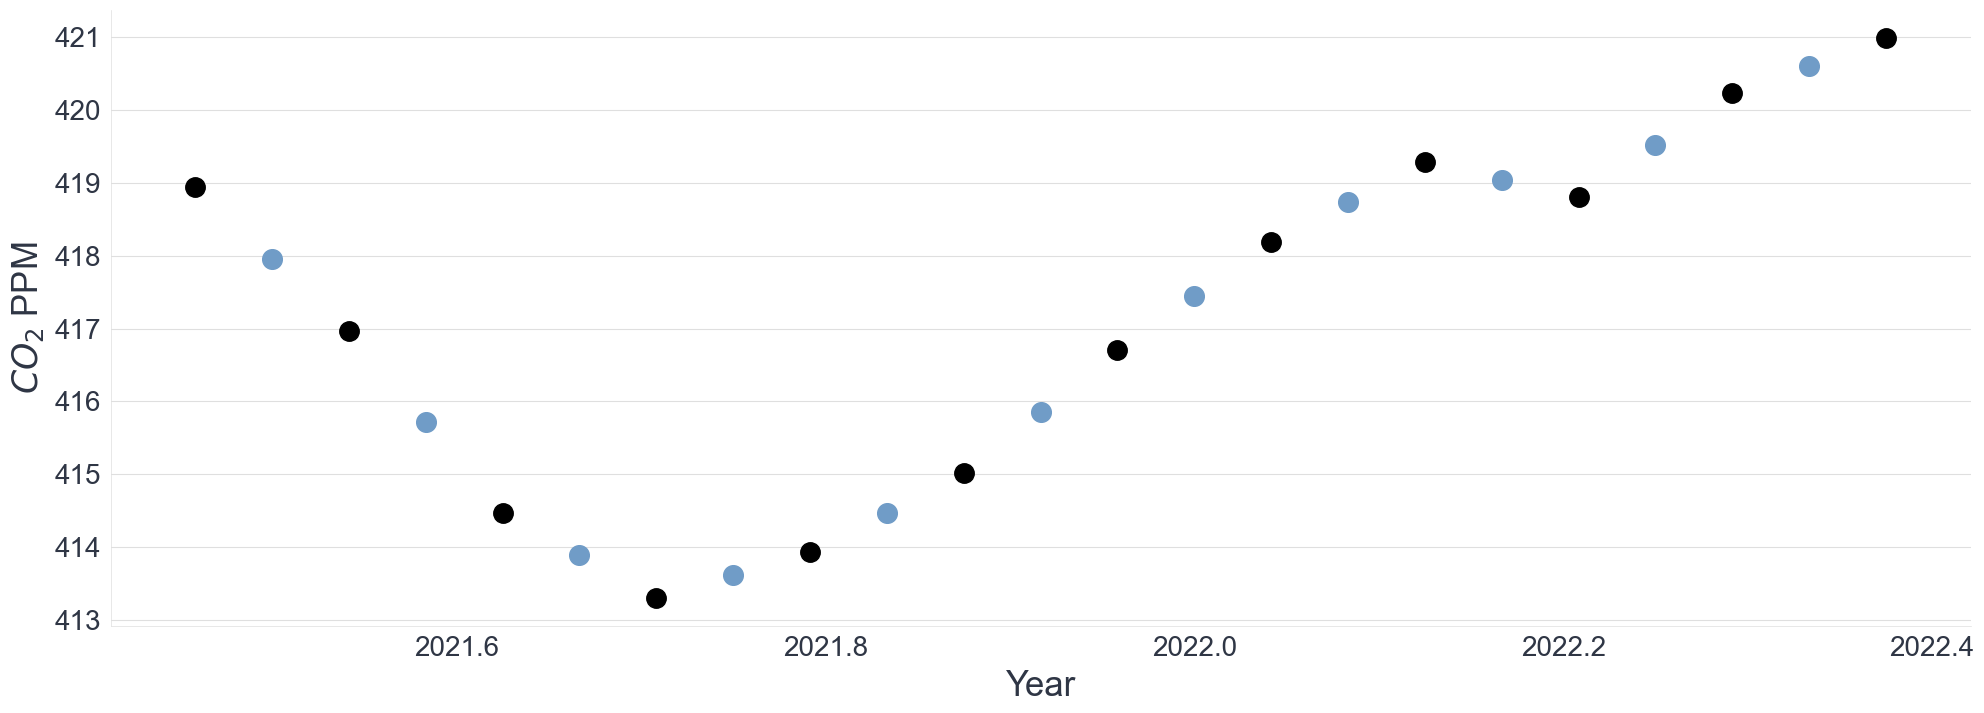

In [46]:
fig, ax = plt.subplots(figsize=(24,8))
plot_data(ax)

vals = last_12_obs[["decimal date", "average"]].rolling(window=2).mean()

ax.scatter(vals["decimal date"], vals["average"], marker = "o", s=200, color="C5");

This is amazing now we dont need to define a functional form. This method should work equally well on any arbitrary function. Lets now fill in all the other values

## Breaking our intuition



In [47]:
date_of_interest= 2021.945
y_val = (last_12_obs
    .assign(distance=np.abs(last_12_obs["decimal date"] - date_of_interest))
    .sort_values("distance")
    .head(2)
    ["average"].mean())

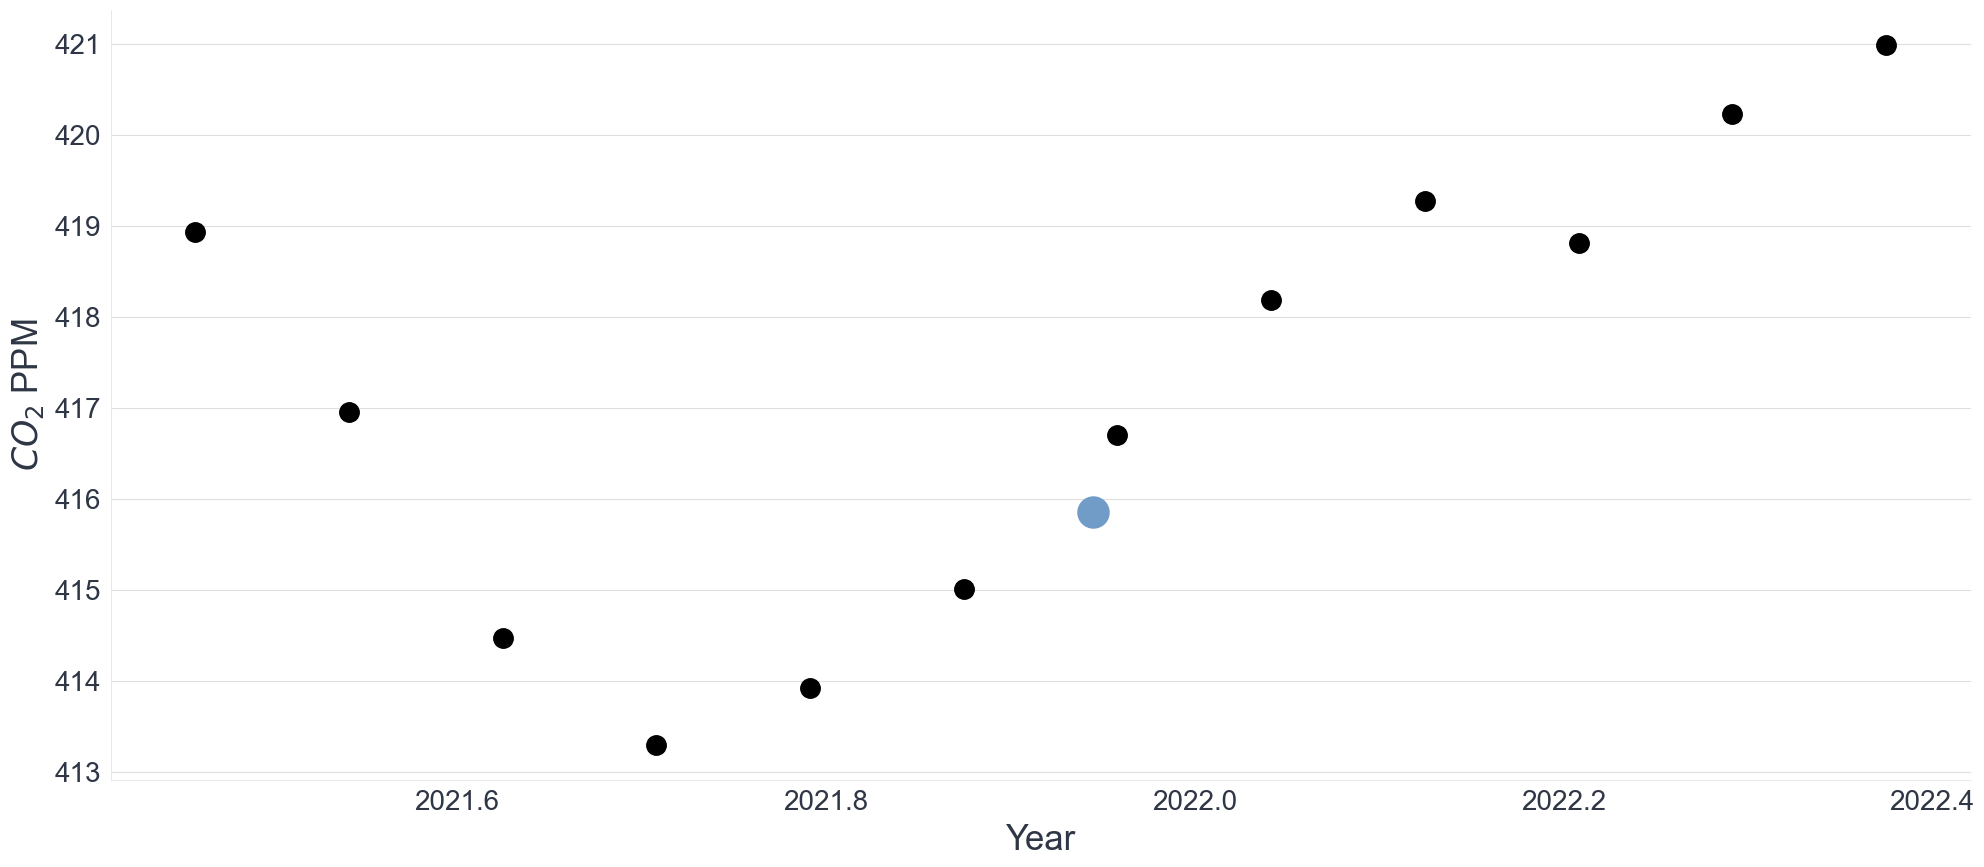

In [48]:
fig, ax = plt.subplots(figsize=(24,10))
plot_data(ax)
ax.scatter(date_of_interest, y_val, s=2000, color="C5");

As we move closer to the dot on the right, we'd assume that our estimated points would go up, since the dot on the right "matters more" as its closer. But because were just selecting the two closest points and averaging that doesn't work

## Moving average fit

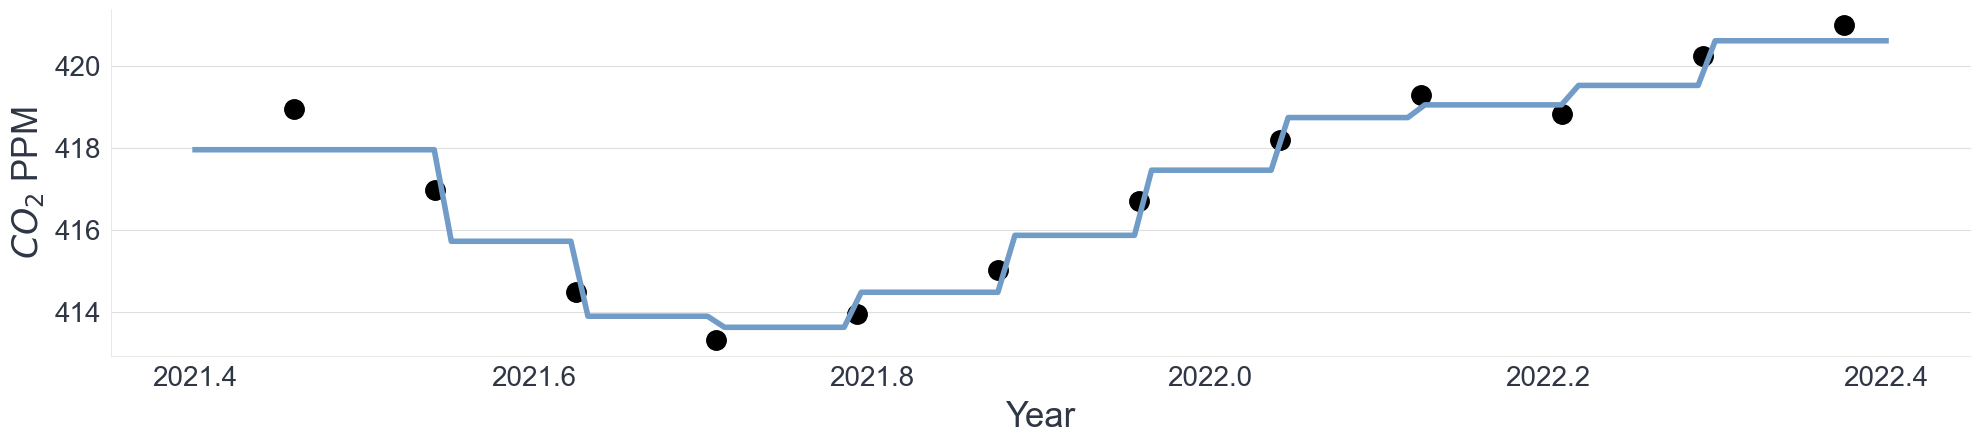

In [49]:
fig, ax = plt.subplots(figsize=(24,4.5))
plot_data(ax)
# Don't do this in real life, its very computationally wasteful
x = np.linspace(2021.4, 2022.4, 100)
y = []
for point_of_interest in x:
        
    y_val = (last_12_obs
        .assign(distance=np.abs(last_12_obs["decimal date"] - point_of_interest))
        .sort_values("distance")
        .head(2)
        ["average"].mean())

    y.append(y_val)
plt.plot(x, y, color="C5");

This is what the fit looks like if we plot more points between data points. Now nothing is inherently wrong with this, moving average fits are used in time series all the time, but its not what were looking for

## What if we include more data in the average?

In [50]:
y_vals = []

x = np.linspace(2021.4, 2022.4, 100)

for num_points_considered in (2, 4): 
    y_vals_temp = []
    for point_of_interest in x:  
        y_val = (last_12_obs
            .assign(distance=np.abs(last_12_obs["decimal date"] - point_of_interest))
            .sort_values("distance")
            .head(num_points_considered)
            ["average"].mean())

        y_vals_temp.append(y_val)    
    y_vals.append(y_vals_temp)

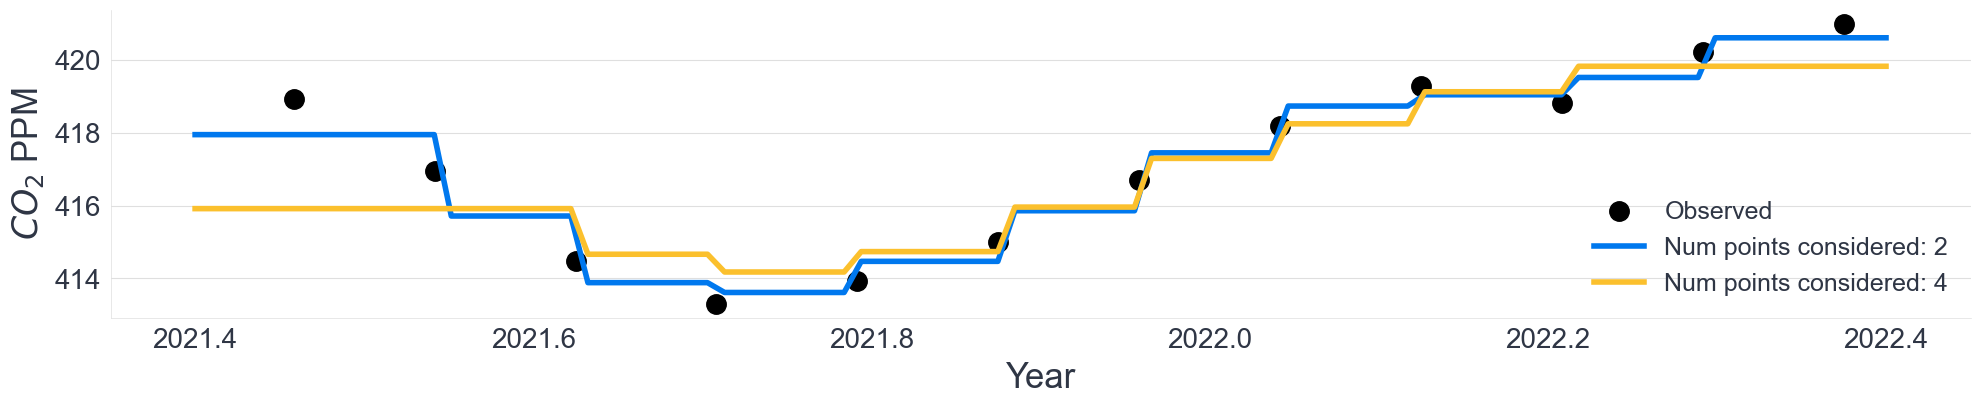

In [51]:
fig, ax = plt.subplots(figsize=(24,4))
plot_data(ax)

ax.plot(x, y_vals[0], label = f"Num points considered: 2")
ax.plot(x, y_vals[1], label = f"Num points considered: 4")
ax.legend();

You might say, why only two closet data points were throwing away information. Youre right we are and its a problem. Here we picked

We made an exercise so be sure to do it to see what were talking about 

In the next section we'll show you how to overcome these of a step wise fit, and adjusting the influence of the data, all with an neat mathematical trick. For now lets go to the section recap

## Same as equal weighting the data

In [52]:
y_vals = []

x = np.linspace(2021.4, 2022.4, 100)

for num_points_considered in (2, 4): 
    y_vals_temp = []
    for point_of_interest in x:  
        y_val = (last_12_obs
            .assign(distance=np.abs(last_12_obs["decimal date"] - point_of_interest))
            .sort_values("distance")
            .head(num_points_considered)
                 
            # Note the change here
            .sum()["average"]/num_points_considered)


        y_vals_temp.append(y_val)    
    y_vals.append(y_vals_temp)

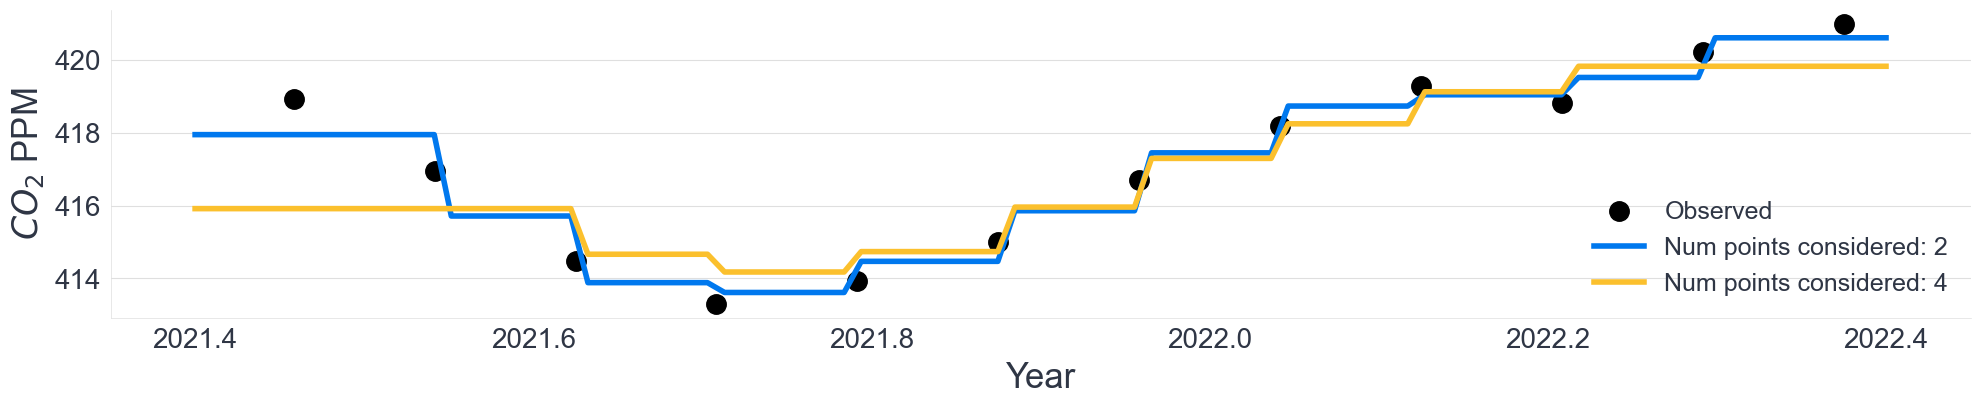

In [53]:
fig, ax = plt.subplots(figsize=(24,4))
plot_data(ax)

ax.plot(x, y_vals[0], label = f"Num points considered: 2")
ax.plot(x, y_vals[1], label = f"Num points considered: 4")
ax.legend();

We can equivalently think of our model as using a weighted average for the estimates.  In this last case where we chose 2 neighbors, those two neighbors each get a weight of 50%, or 0.5, and all the other data points get weights of zero.  

## Section Recap
* There are ways to make estimates that are *not* optimizing over hand selected functional models

* Nearest Neighbor averaging is one method
  * In this paradigm every data point whether close or far to a particular x value has the same weight
  * Works great when the x value of interest is at the midpoint of our selected observations
  * Does not work so great when we start moving closer to one point or another
* Intuitively it makes sense that closer observed data should be more influential

# Similarity Functions
Weighting the data

In the last section we started to think about modeling functions in a slightly different way.  We've freed ourselves from trying to come up with specific functional forms, but using the average of the y values of our nearest neighbor data points gives us a result that looks the most Mondrian of all! 

## Continued inspiration from Jackson Pollock

<center>
     <img src="img/Pollock-Everson.jpg"  />
</center>

In this section we'll keep going down the road to Jackson Pollacks stochastic processes.  Along the way, we'll build from the ground up a concept, aptly called a **kernel** that is at the core of many many machine learning algorithms, including Gaussian processes.  

## Location, location

<center>
     <img src="img/small-wooden-barn-built-large-field.jpg" style="height:750px";/>
</center>

We've seen that is hard to come up with a heuristic to pick the right number of neighboring data points for our aveage function.. Let's take one step further and reframe things in terms of **distance** and **similarity**.  What if all your neighbors are very far apart? 


If you were standing on the porch of the farmhouse how far would you have to walk until you reach your neighbor? How much influence would this neighbor have on you?



## Location,
## Location


<center>
     <img src="img/Stackedhouse.png"/>
</center>

What if our neighorhood looked like this? How much influence would you neighbors have then?
The number of neighbors that matter is clearly depends distance, or equivalently, similarity. 



## Similarity, aka, the Kernel

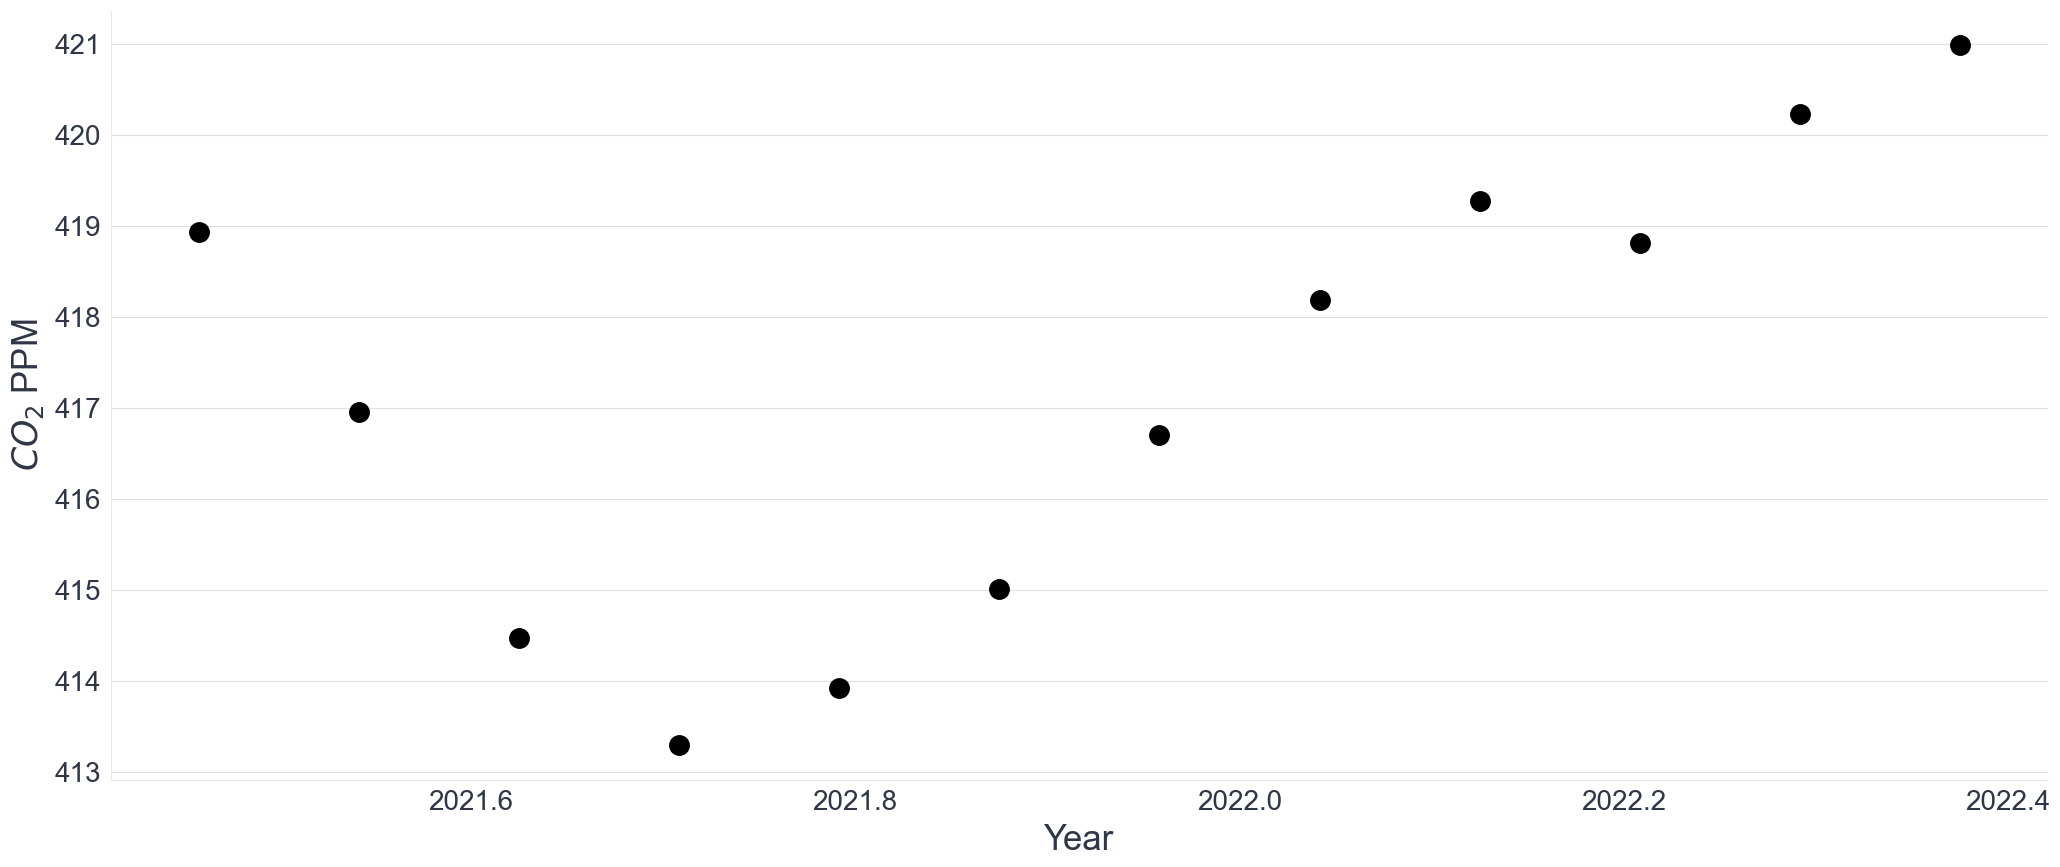

In [54]:
fig = plt.figure(figsize=(25,10))
ax = fig.gca()
plot_data(ax);

Let's go back to Mauna Loa and apply this concept to refine the nearest neighbor idea from the previous section.  We can actually start here and use our intuition to design a simple *kernel* function from the ground up.

## Distance Intuition

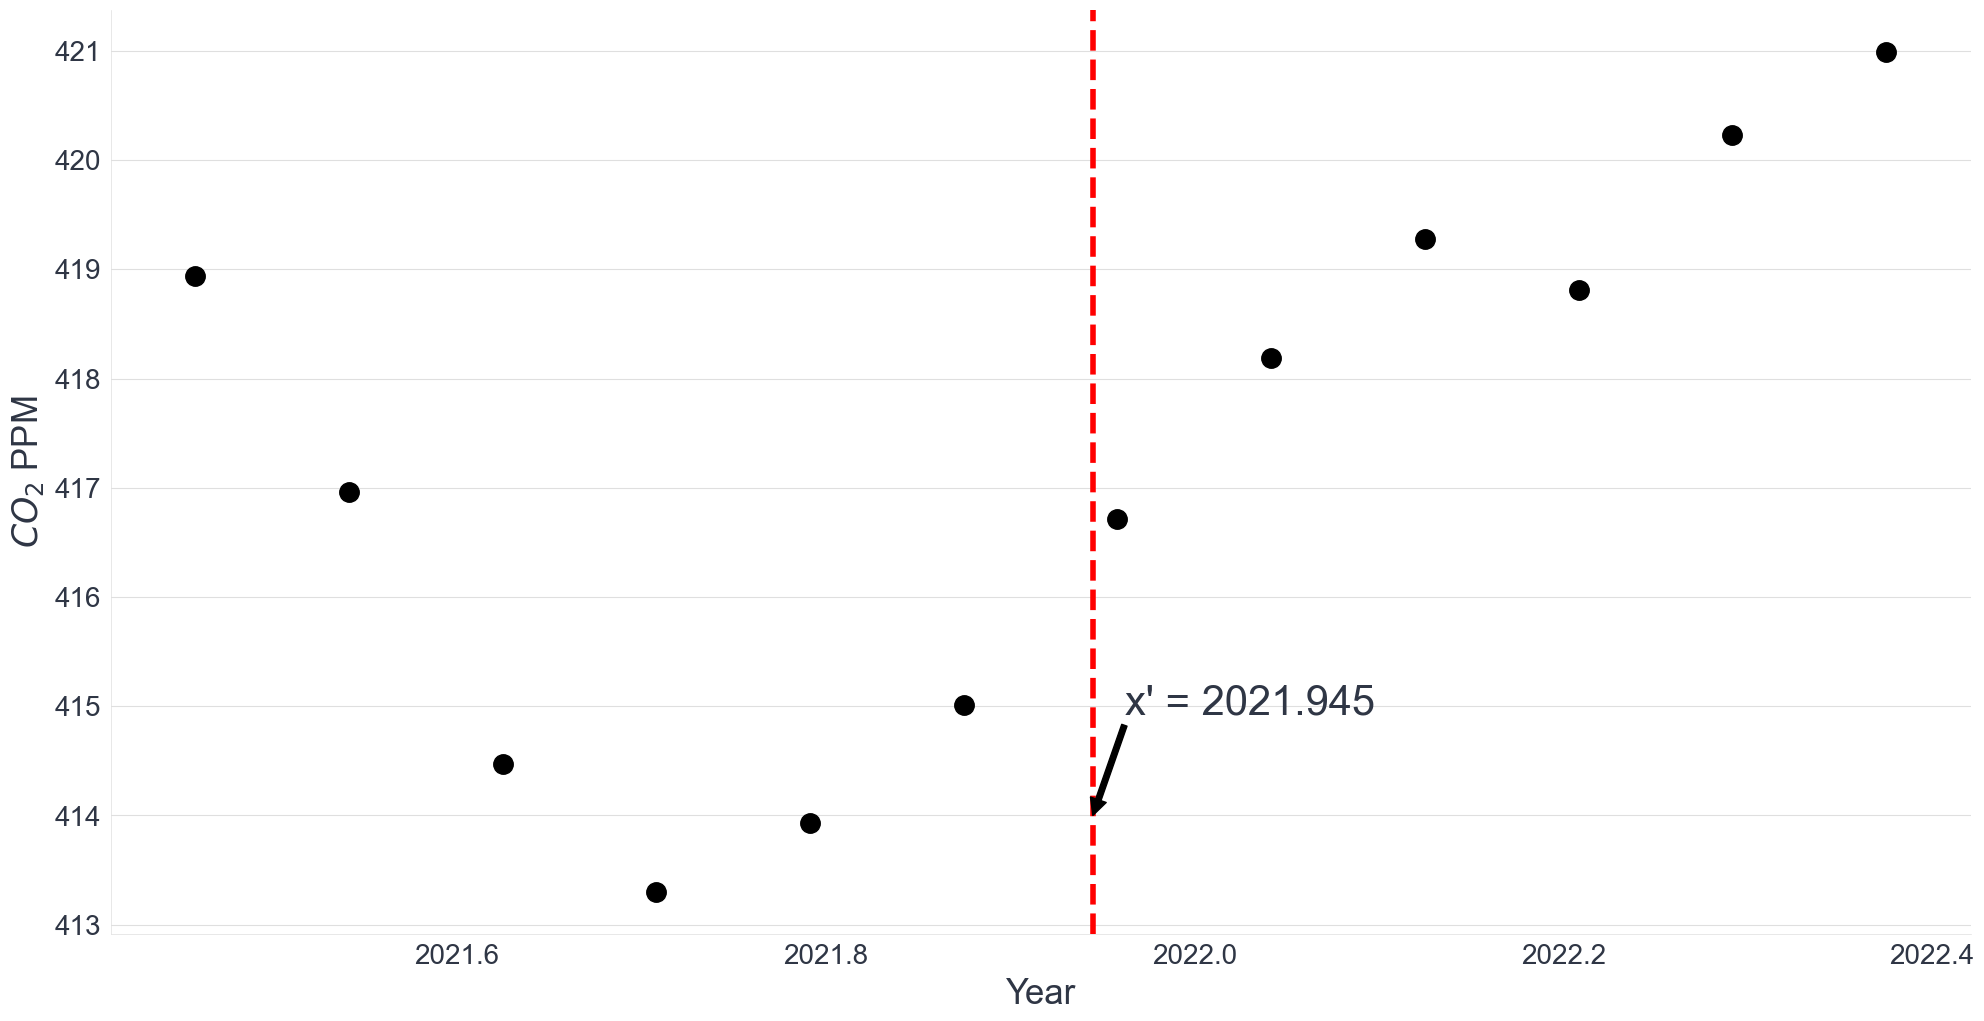

In [55]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

plot_data(ax);
ax.axvline(x=date_of_interest, color="r", linestyle="--")

ax.annotate(f"x' = {date_of_interest}", xy=(date_of_interest, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);

Distance, or similarity, in the CO2 data set isn't about walking or driving distance.  Instead, it's about time, which weve already called the x-axis.  
Let's pull up our data, and like we did before, let's start at 2022.946.  But this time let's also introduce a bit of notation.  Let's call this point $x'$, so $x' = 2021.945$.  We put a vertical red line here on the plot. 

## Distance in math

$$ 
\Huge
{d = ( x - x' )^2}
$$

Now let's define a distance mathematically which we'll call $d$. 

The distance we care about is the difference from our "test point" x', to anywhere else on the x axis. We need make it a positive number (does negative distance mean here?) by squaring it. Yes, we could have also used the absolute value here to make it positive as well but for now lets start with this

## Calculating the distance in code

In [56]:
distance_func = lambda x: np.square(x["decimal date"] - date_of_interest)

print(f"Date of interest: {date_of_interest}")
(last_12_obs
     # Get the distance to all other points
    .assign(unsquared_distance = lambda x: x["decimal date"] - date_of_interest)
    .assign(distance=distance_func)
    .head(12))[["decimal date", "unsquared_distance", "distance"]]

Date of interest: 2021.945


decimal date  unsquared_distance  distance
759     2021.4583             -0.4867  0.236877
760     2021.5417             -0.4033  0.162651
761     2021.6250             -0.3200  0.102400
762     2021.7083             -0.2367  0.056027
763     2021.7917             -0.1533  0.023501
764     2021.8750             -0.0700  0.004900
765     2021.9583              0.0133  0.000177
766     2022.0417              0.0967  0.009351
767     2022.1250              0.1800  0.032400
768     2022.2083              0.2633  0.069327
769     2022.2917              0.3467  0.120201
770     2022.3750              0.4300  0.184900

Notice how the distance calculation between the two points here. The difference in the final value means were weighting one of the points more than the other. Also note how even though the calculation within the parans is negative, when we square it it turns positive. 

## Plotting the distance to from x' *every* x

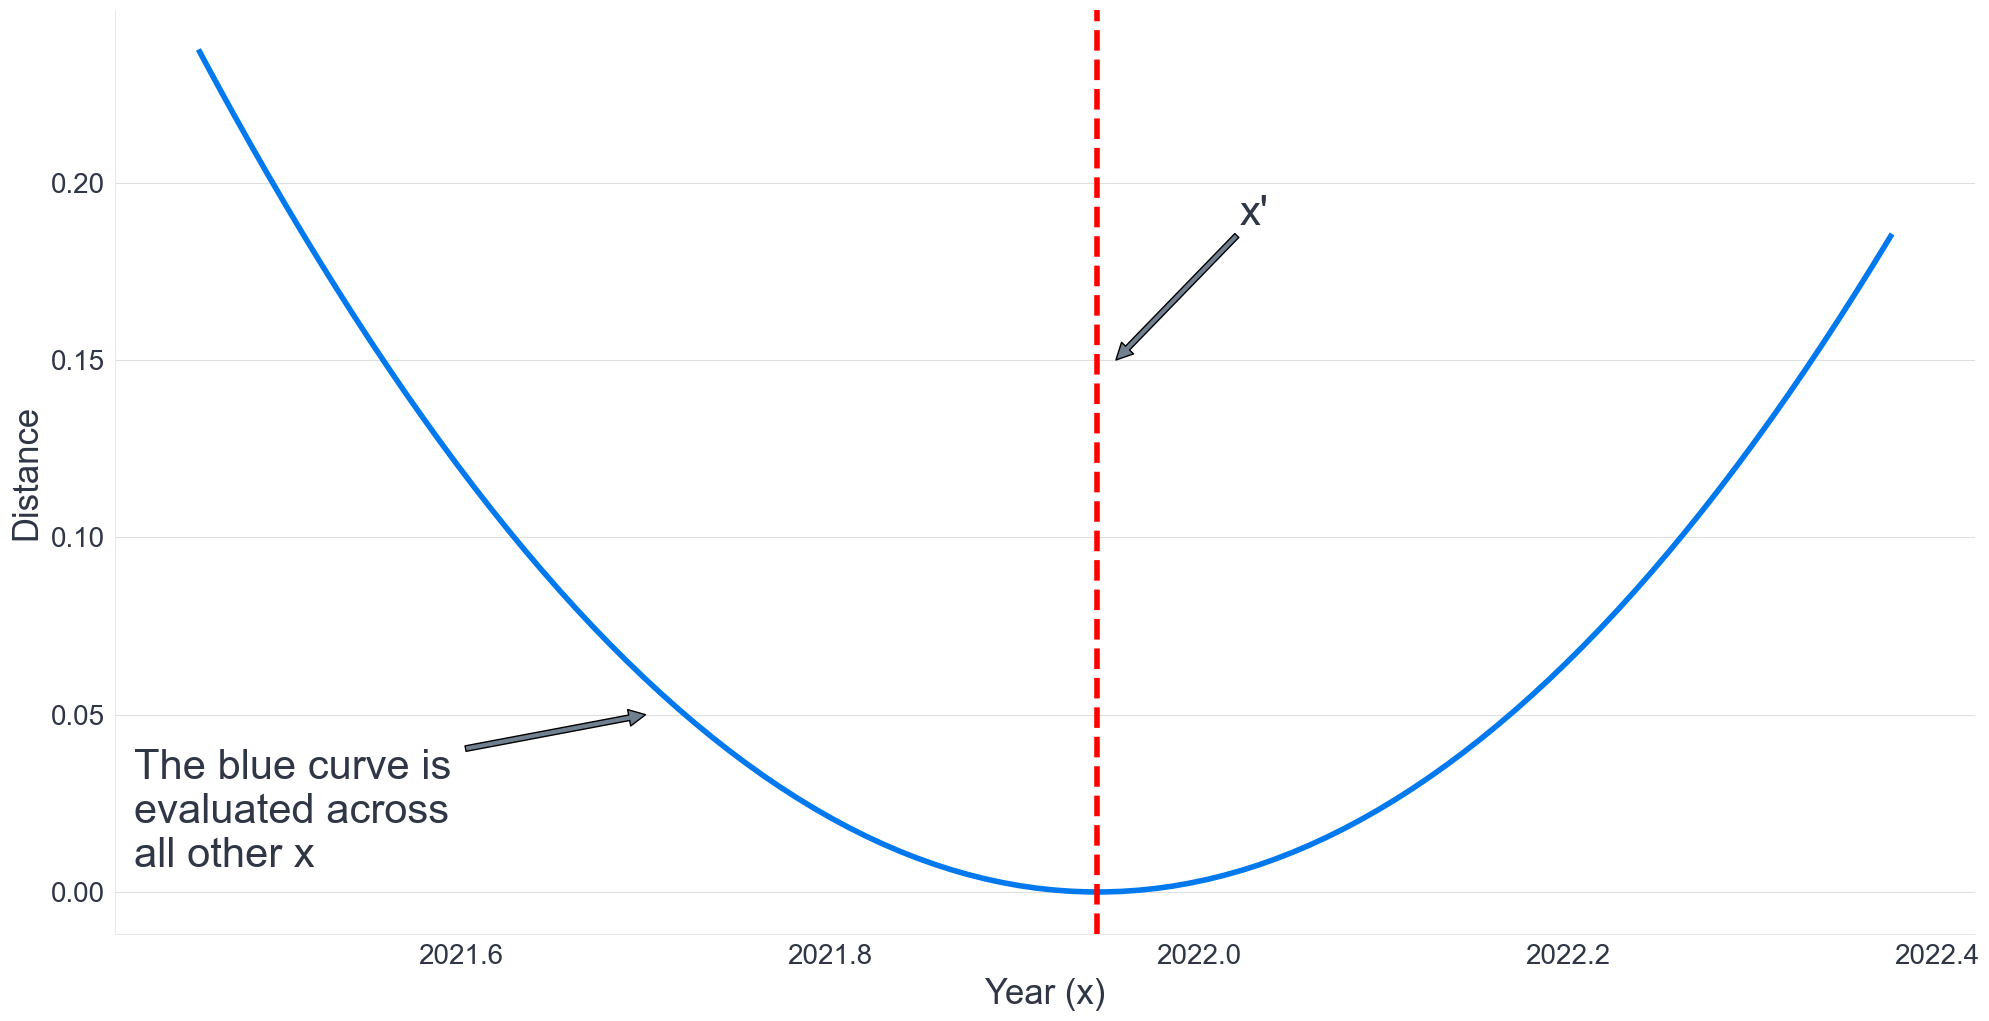

In [57]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()

x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 100)
x_prime = date_of_interest

ax.plot(x, np.square(x - x_prime), lw=4);

ax.axvline(x=date_of_interest, color="r", linestyle="--", lw=4)
ax.annotate("x'", xy=(date_of_interest + 0.01, 0.15),  xycoords='data',
    xytext=(0.62, 0.8), textcoords='axes fraction', 
    arrowprops=dict(facecolor='slategray'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
)
ax.annotate("The blue curve is \nevaluated across \nall other x", xy=(2021.7, 0.05),  xycoords='data',
    xytext=(0.01, 0.2), textcoords='axes fraction', 
    arrowprops=dict(facecolor='slategray'), fontsize=30,
    horizontalalignment='left', verticalalignment='top',
)

ax.set_ylabel("Distance")
ax.set_xlabel("Year (x)");

To help build our intuition, this is a plot of $d$ as a function of $x$, where $x' = 2022.0$.  You can see that as we get further and further away from our test point $x'$, the distance increases.  That's kind of obvious right?  But also think about the *way* the distance increases. 

## How far is far?

$$
\begin{align}
\ell &= \text{lengthscale parameter}  \\
d &= \left( \frac{x}{\ell} - \frac{x'}{\ell} \right)^2 \\
  &= \left( \frac{x - x'}{\ell} \right)^2 \\
  &= \frac{(x - x')^2}{\ell^2}  \\
\end{align}
$$


Lets now talk about length scale
Its our first, and very important, parameter $\ell$, called the *lengthscale*. It's used to scale the distance, and it answers the question of, what exactly counts as close, and what exactly counts as far?  It's role is to sort of standardize the distances by scaling each $x$, and $x'$ pair.


As we'll see later, the idea of a lengthscale is very common in GP modeling -- we'll be talking about it a lot in the future.


## Another distance function

$$
\huge
\begin{align}
d &= \frac{|x - x'|}{2\ell^2}  \\
\end{align}
$$

And aside from length scale why is this formula the one? Well we have the choice of square, or absolute value, or as we'll see later, use other types of measures entirely will be the crux the model. There isn't a "right" distance to use, that's determined by the data and you.  



## The most common distance function


$$
\huge
\begin{align}
d &= \frac{(x - x')^2}{2\ell^2}  \\
\end{align}
$$


The one is usually how it's written. We want to show it to you because you'll often see it in literature and we 'd like you to be prepared.  You'll notice we snuck in the factor of 2 in the denominator.  Why?  I don't know!  You'll see it around  in literature.  It doesn't change the meaning of lengthscale, which is a representation "how far is far".

We're done with the mathematical definition of distance function now!

## The effect of the length scale parameter

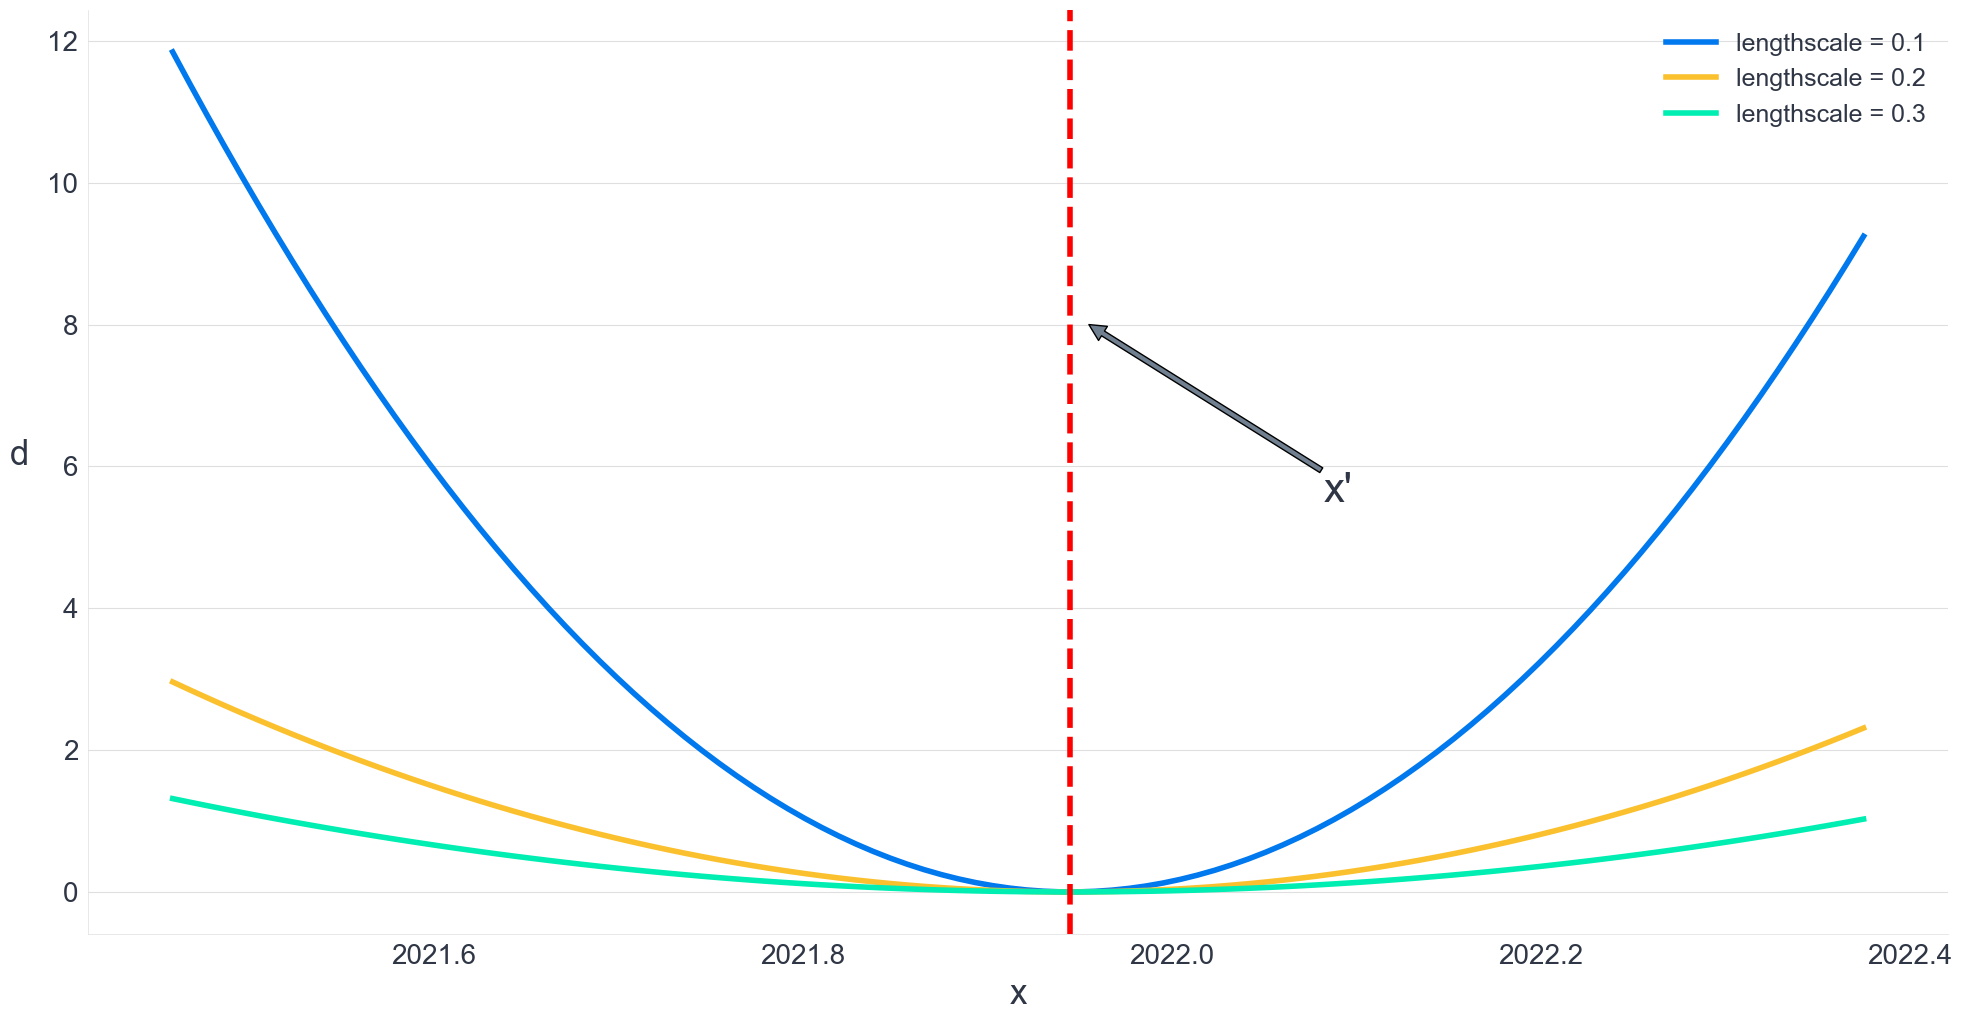

In [58]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 100)
x_prime = date_of_interest

lengthscales = [0.1, 0.2, 0.3]

for ell in lengthscales:
    plt.plot(x, np.square((x - x_prime)) / (2 * ell**2), label=f"lengthscale = {ell}", lw=4);

ax.axvline(x=x_prime, color="r", linestyle="--", lw=4)
ax.annotate("x'", xy=(x_prime + 0.01, 8),  xycoords='data',
    xytext=(0.68, 0.5), textcoords='axes fraction', 
    arrowprops=dict(facecolor='slategray'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);
ax.set_ylabel("d", rotation=0, labelpad=20)
ax.set_xlabel("x");
ax.legend();

Let's play with what we have in code.  We'll remake the previous plot, but try a few different lengthscales. For you sticklers out there, you could've said that we already had a lengthscale, just that it was equal to one! Now we'll try some others

By scaling $x$ with $\ell$, we're changing what counts as "far".  

* When $\ell$ is large, like 0.3 here, the distance increases slowly, it's almost flat.  It means we think of points to the far left or far right of $x'$ as not really being that far away.  You've got to go pretty far, relatively, to make the distance $d$ large. 
* When $\ell$ is small, like 0.1 here, the distance increases rapidly.  It doesn't take much distance, to get far away.  

Keep in mind that this is all relative to the scale of x.

## Short Length Scale: Walking from LA to New York 

<center>
     <img src="img/LatoNYWalk.png" style="height:800px"/>
</center>

Lets talk through an intuitive example. The distance from LA so NY is fixed as 2794 miles. Doesn't matter how you get there, its the distance

The length scale is like your mode of transportation.  It's very, very far from New York to LA.  Google says it would take 918 hours to walk there.  That's like a short length scale -- small steps.  Looking at a map of America, everything is far if you're walking.  

## Medium Length Scale: Walking from LA to New York 

<center>
     <img src="img/LaToNYDrive.png" style="height:800px"/>
</center>

If you drive however, Google says it would take 41 hours.  Better! The distance in miles is the same, but now by taking a car it "feels" closer together

## Long Length Scale: Flying from LA to New York 

<center>
     <img src="img/LatoNYFly.png" style="height:800px"/>
</center>


Flying is like a long lengthscale.  For that one Google says 5 hours and 35 minutes.  Whether you're flying to LA, or Florida, or Chicago, it's all about the same more or less -- a few hours.  You wouldn't say that if you were walking! 

That's the intuition, by picking our mode of transportation we can expand or compress our "perceived" distance, even if the geographical distance stays fixed.

## Distance function to Similarity function
$$ \large
Similarity(x, x', \ell) = \exp \left[ -\frac{(x - x')^2}{2\ell^2} \right]
$$


Also known as RBF (radial basis function) or **exponentiated quadratic** kernel.  

How can we use our new distance function help us estimate CO2 values?

For this (and so many other ML algorithms!) we want things in terms of similarity instead of distance. Lets talk through why

## Distance versus Similiarity

In [59]:
distance_func = lambda x, x_prime: np.square(x-x_prime)
similarity_func = lambda x, x_prime: np.exp(-np.square(x-x_prime))

x_prime = 1
close_x = 1.1
far_x = 30

print(f"Distance close X   {distance_func(x_prime, close_x)}")
print(f"Distance far X     {distance_func(x_prime, far_x)}")
print(f"Similarity close X {similarity_func(x_prime, close_x)}")
print(f"Similarity far X   {similarity_func(x_prime, far_x)}")

Distance close X   0.010000000000000018
Distance far X     841
Similarity close X 0.990049833749168
Similarity far X   0.0


You can think of distance and similarity as siblings, but opposite.

The range of our distance function goes from  zero (close) to infinity (far). We'd rather it go from a value of 1 being really close, and a value of 0 if its far.

Remember, we need our data points that are close together to have a higher weight, or similarity, than those that are far apart.  So the way accomplish this is to exponentiate $d$, and stick a minus sign up in there and suddenly the math works out! 

## Distance function to ~~Similarity Function~~ Kernel

$$ \large
k(x, x', \ell) = \exp \left[ -\frac{(x - x')^2}{2\ell^2} \right]
$$

Now within GP literature similarity functions are called kernels. Due to this precedent we'll switch both the symbol and nomenclature here to help reinforce this for you. But don't get confused, when we say kernel moving forward were not talking about kernels of corn, we're talking about a function that takes takes two points

Later on in the course you'll see other kernels as well but lets not get ahead of ourself

It's mainly function of $x$, but if you think about it, $x'$ too.  Also, the lengthscale is a parameter in there too.  It's a bit different than $x$ and $x'$ or course, so we'll separate it a bit for readability. 


You might notice the semicolon on the left side too.  The reason it's there is to separate the two types of parameters.  **Every** kernel is a function of $x$ and $x'$.  They are always going to be there.  The lengthscale, or other parameters, are specific to this kernel.  Don't worry too much about this notation, it doesn't mean anything other than to highlight which parameters are specific to this particular kernel.  In this case, it's not $x$ or $x'$, but $\ell$.

## Aside: Almost Gaussian, but not Gaussian



$$ \large
\overbrace{
k(x, x'\, \ell) = \exp \left[ -\frac{(x - x')^2}{2\ell^2} \right]
}^{Kernel\ Function}
$$

$$ \large
\overbrace{
f(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left( -\frac{1}{2} \frac{(x - \mu)^2}{\sigma^2} \right).
}^{Gaussian\ Probability\ Density\ Function}
$$


You might recognize this as *almost* the formula normal, or Gaussian distribution. It has the same "form" as a gaussian pdf, but you don't interpret the parameters that way. It's a coincidence. And note this is not where the  name "Gaussian" in Gaussian process from. We'll tell you where the G in GP comes from later

## How far apart are New York and LA using our kernel and varying length scale?

In [60]:
def kernel(x, x_prime, lengthscale):
    return np.exp( -0.5 * np.square(x - x_prime) / np.square(lengthscale))

Let's now revist our LA to NY analysis but this time use a kernel, or similarity function

In [61]:
gold_status = kernel(0, 2794, lengthscale=20000)
print("Gold status, NY/LA similarity: %0.4f" % gold_status)

Gold status, NY/LA similarity: 0.9903


In [62]:
hiking = kernel(2794, 0,  lengthscale=15)
print("If you're hiking, NY/LA similarity: %0.10f" % hiking)

If you're hiking, NY/LA similarity: 0.0000000000


## Distance is symmetrical in this case (but not for every kernel)

Clearly NY and LA are very, very far apart if you want to walk, but not so much if you fly indicated by the big length scale.  

In [63]:
gold_status1 = kernel(0, 2794, 20000)
gold_status2 = kernel(2794, 0, 20000)
gold_status1, gold_status2

(0.9902894102388888, 0.9902894102388888)


If 10k miles is no big deal, then it's no big deal to go from NY to LA.  The kernel gives a similarity of nearly Let's try a couple calculations, first with a large, or long, lengthscale (large and long, small and short, you'll see these descriptions used interchangeably when talking about lengthscale parameters).

Google says its 2794 miles between NY and LA walking.  Let's say that you travel **a lot** and you collect frequent flyer miles, gold status.  Someone might say "10,000 miles", and you think, "no big deal that's not that far".    Let's use 20k as our lengthscale then, and see how similar NY and LA are to you:1.0.

Now let's say you're an avid hiker.  Maybe a good hike for you is maybe 10 or 15 miles.  Well, how far is from LA to NY?

Since it's a distance, this ordering doesn't matter. Notice one thing, we get the same result if we swap x and x'.   This isn't true for all kernels, as we'll see in later lessons.

## Using our kernel to weight our data

In [72]:
# Quadratic Kernel in code
x_prime = date_of_interest

def kernel(x, x_prime, lengthscale):
    return np.exp( -0.5 * np.square(x - x_prime) / np.square(lengthscale))

x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 200)
weights = kernel(x, x_prime, 0.1)

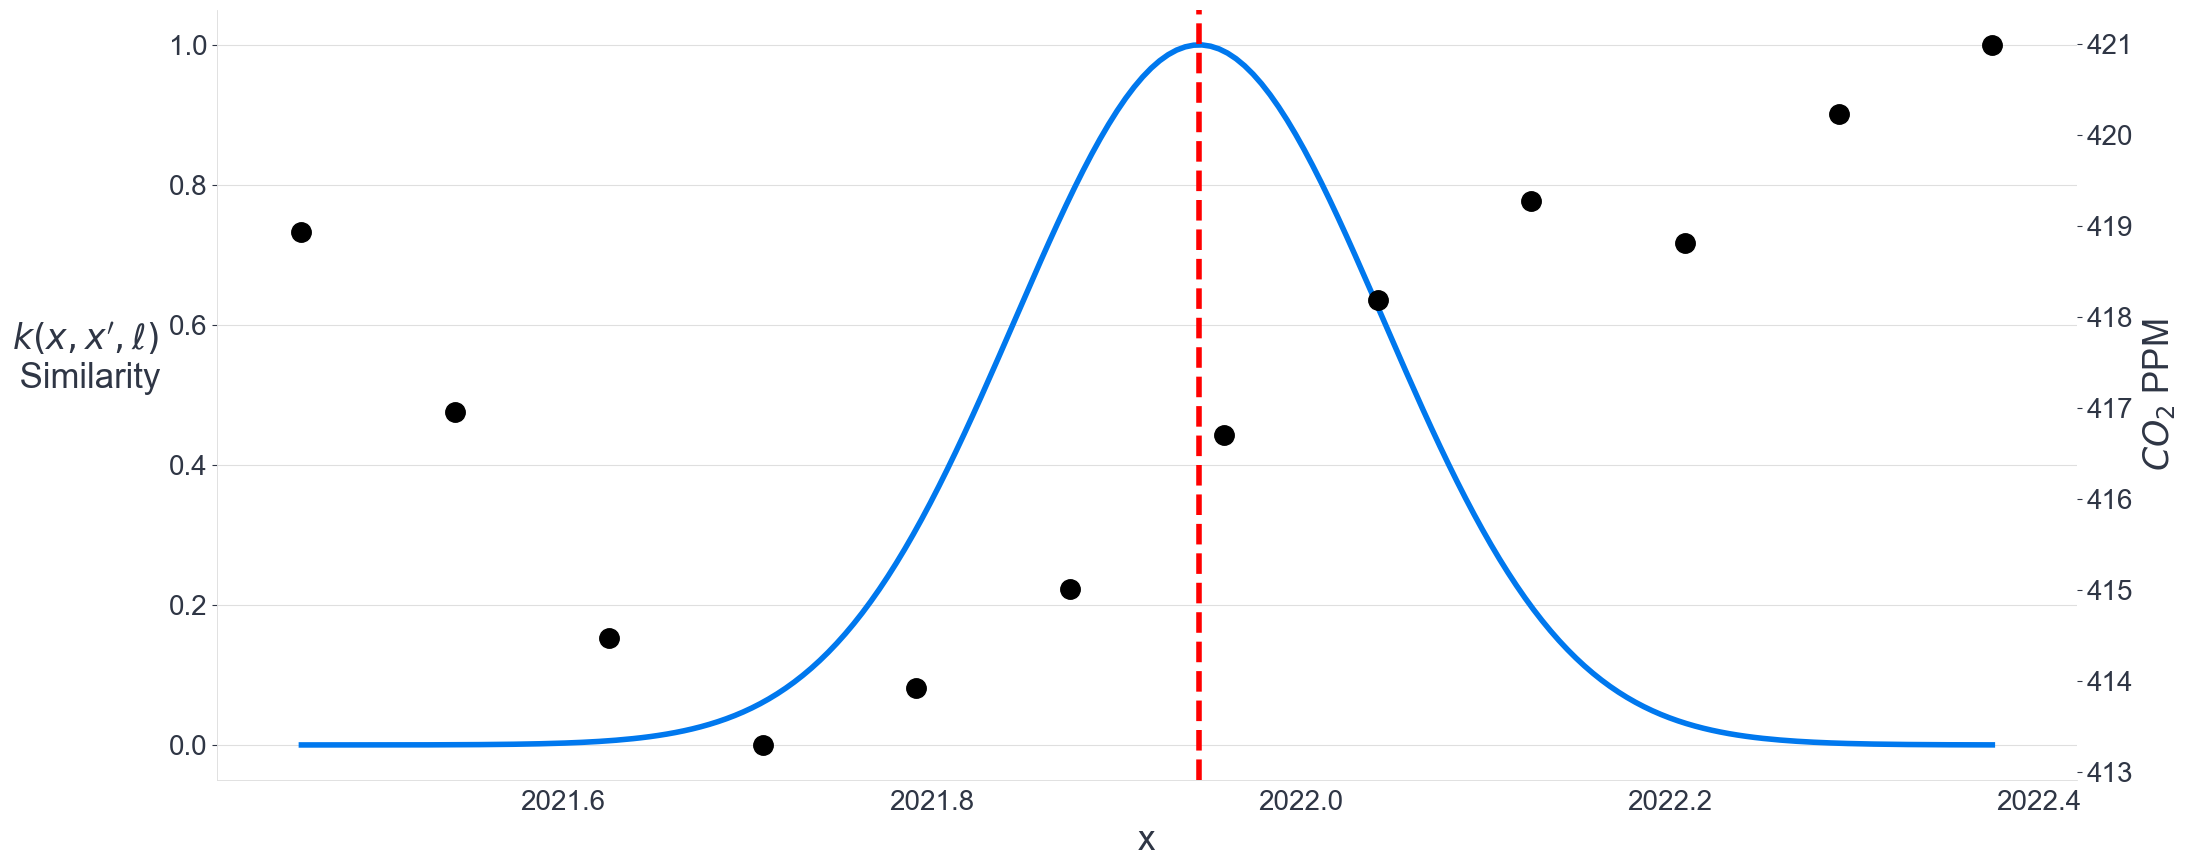

In [74]:
fig = plt.figure(figsize=(24,10))
ax = plt.gca()

ax.plot(x, weights, label=f"lengthscale = {ell}", lw=4);

ax.axvline(x=date_of_interest, color="r", linestyle="--", lw=4)
ax.annotate("x'", xy=(2022, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);

ax.set_ylabel("$k(x, x', \ell)$\n Similarity", rotation=0, loc="center", labelpad= 60);
ax.set_xlabel("x")

ax2 = ax.twinx()
plot_data(ax2)
ax2.grid(False);

Let's make the same kinds of plots we did with distance, except using the kernel function, which also sometimes is called the weighting function.  Also, we'll overlay our data, so we can see the similarities assigned to the points near $x'$.   

Note again how the x values close to our point of interest have high similarity, and the ones farther away have less. Flip back a couple of slides to compare to the plot of the distance function to see how these two differ

## Building the kernel machine

In [75]:
def kernel_machine(x, y, x_prime, lengthscale):
    
    # Calculate the similarity between our point of interest 
    # and every other observed point based on x distance
    k = kernel(x, x_prime, lengthscale)
    
    # Normalize our similarity vector
    w = k / np.sum(k)
    
    # Calculate our estimated_y using our similarity weighting
    y_estimate = np.dot(w, y)

    return y_estimate

Now the last step.  Let's make a super simple kernel regression machine which 

Our kernel to calculate weights for each data point, then, we'll normalize them so that they all sum to 1.  Our estimator at $x'$, will be given by this weighted average.  We'll make the same plot, but show the estimate our kernel machine gives.  The kernel machine's estimate is the weighted sum of the datapoints under the "umbrella" of the kernel function.

## Using our kernel machine to make an estimate 

In [78]:
x_prime = date_of_interest
lengthscale = 0.1

## Use our kernel machine to 
estimate = kernel_machine(
    last_12_obs["decimal date"].values, 
    last_12_obs["average"].values, 
    x_prime, # The point we care about
    lengthscale
)

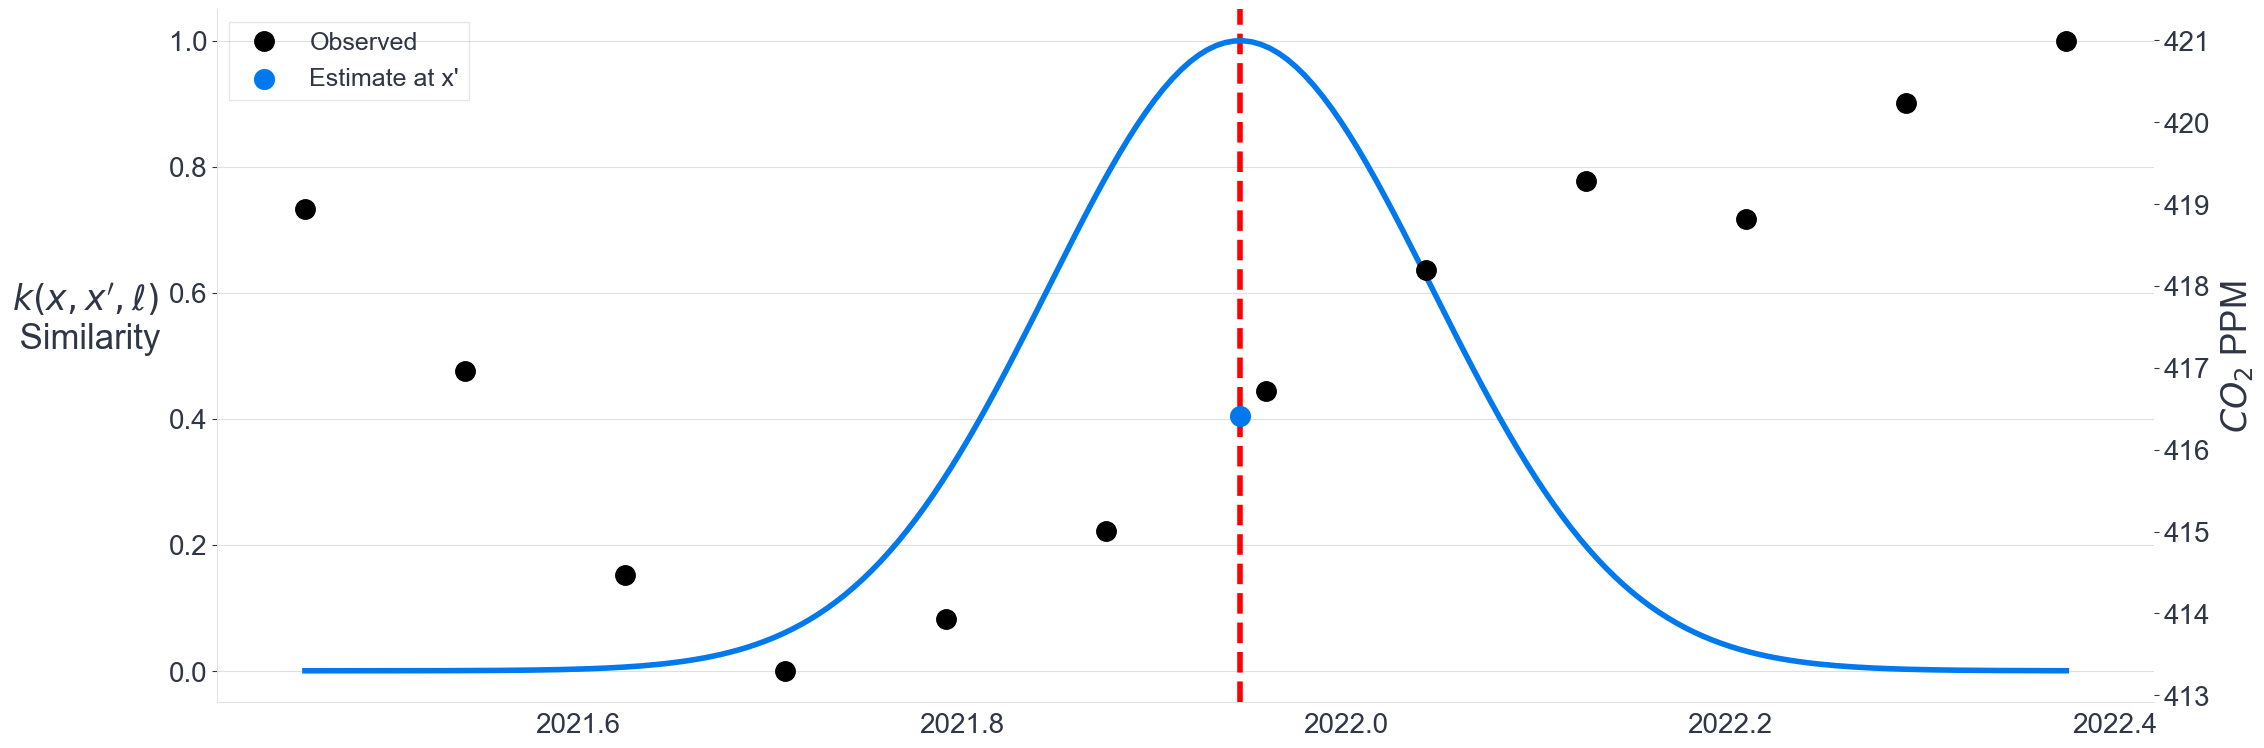

In [81]:
x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 200)

fig = plt.figure(figsize=(25,9))
ax = plt.gca()
ax2 = ax.twinx()


# plot vertical line at x_prime = date_of_interest
ax.axvline(x=x_prime, color="r", linestyle="--", lw=4)

## overlay real data, new scale
ax2.grid(False);
plot_data(ax2)

ax.plot(x, kernel(x, x_prime, lengthscale), label=f"Lengthscale = {ell}", lw=4);
ax.set_ylabel("$k(x, x', \ell)$\n Similarity", rotation=0, loc="center", labelpad= 60);


ax2.scatter([x_prime], [estimate], marker="o", s=200, label="Estimate at x'", alpha=1);
ax2.legend(frameon=True);

Looks pretty good!  Now lets drop the plot of the kernel function itself, and look at the fit the kernel machine gives at many $x'$ values across the domain.

We have our observed data which youve seen many times. Lets now focus on the blue curve. Again this may look like a Gaussian probability distribution but it is NOT one. It it simply the weight were applying to each observed data point, when we calculate our estimate.  So start at a datapoint, move up or down to the blue line, and that's the weight that the data point gets in our estimate at the red dotted line.

The new weighted average is the red dot, which also happens to be our estimate for our point of interest!


## Similarity Weighted C02 estimates for *every* x'

In [82]:
x_range = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 200)

estimates = []
for x_prime in x_range:
    estimates.append(kernel_machine(
        last_12_obs["decimal date"].values, 
        last_12_obs["average"].values, 
        x_prime, 
        lengthscale,
    ))

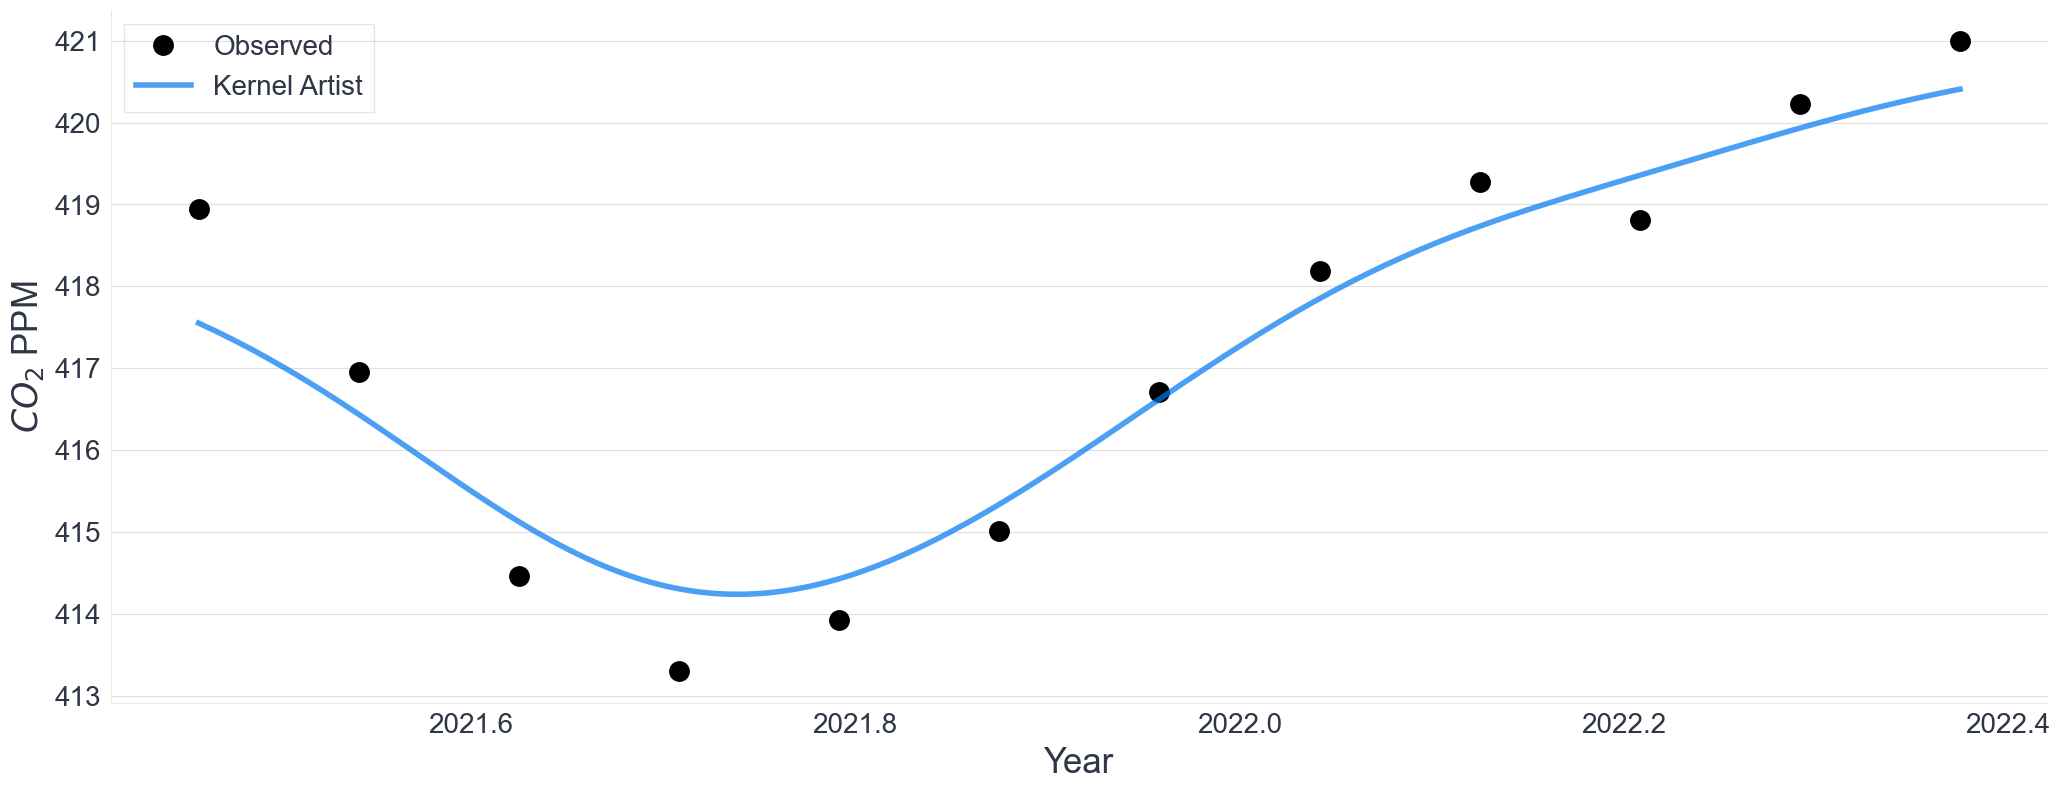

In [83]:
fig = plt.figure(figsize=(25, 9))
ax = fig.gca()
plot_data(ax)

lengthscale = 0.1

x_range = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 200)

ax.plot(x_range, estimates, alpha=0.7, lw=4, label="Kernel Artist")
ax.legend(fontsize=20, frameon=True);

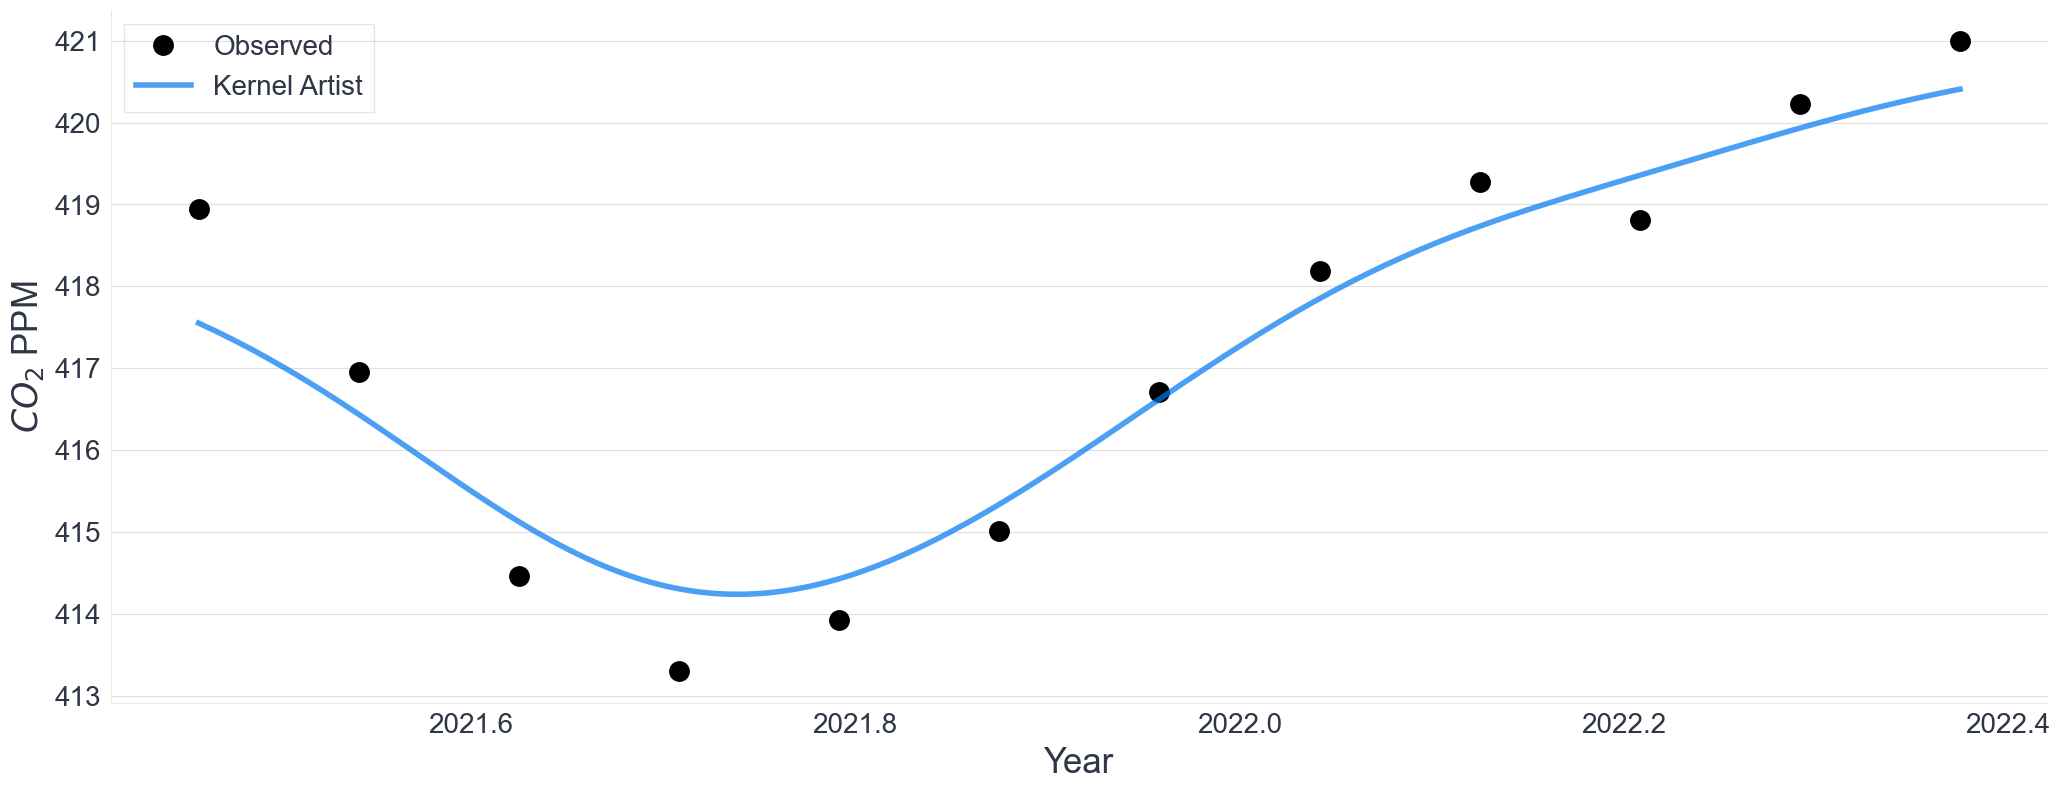

In [84]:
fig = plt.figure(figsize=(25, 9))
ax = fig.gca()
plot_data(ax)

lengthscale = 0.1

x_range = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 200)

ax.plot(x_range, estimates, alpha=0.7, lw=4, label="Kernel Artist")
ax.legend(fontsize=20, frameon=True);

Much better!  This is clearly the best fit we've been able make so far, whether we are using specific functional forms, or nearest neighbors.  

## Kernel fit on all our C02 measurements

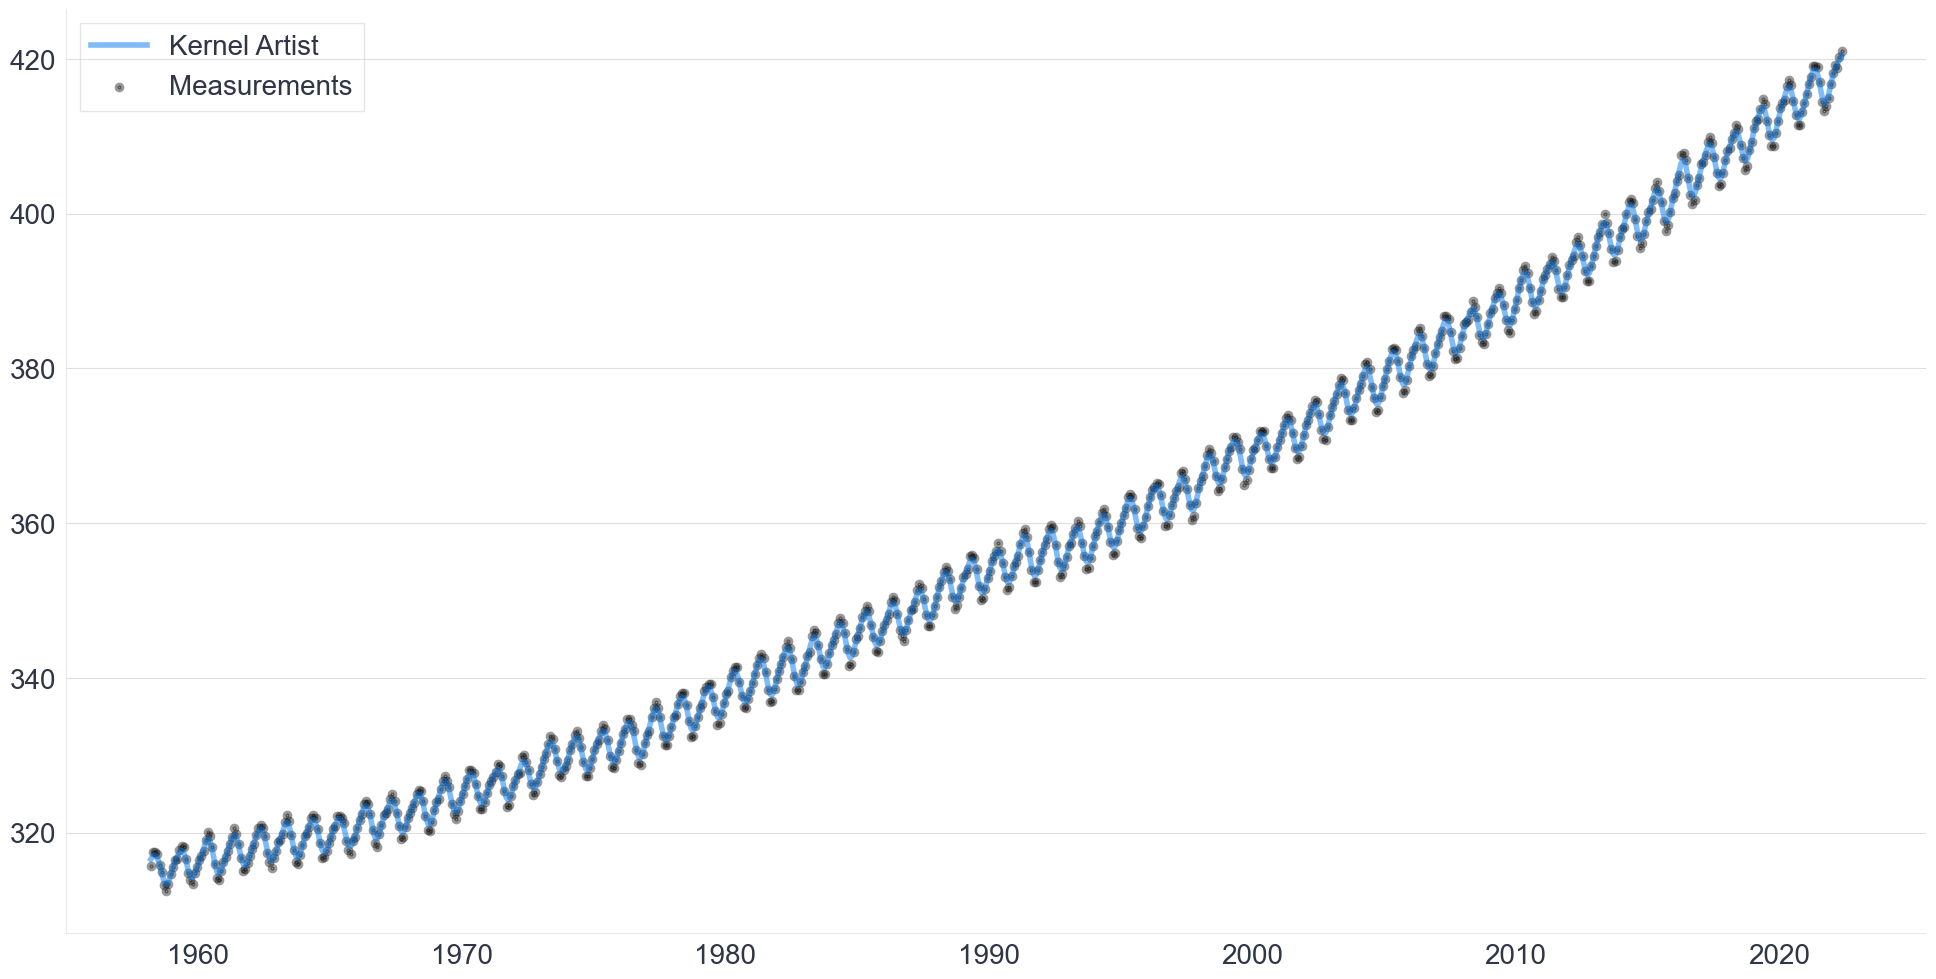

In [85]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

lengthscale = 0.1

x_range = np.linspace(data["decimal date"].min(), data["decimal date"].max(), 1000)
estimates = []
for x_prime in x_range:
    estimates.append(kernel_machine(
        data["decimal date"].values, 
        data["average"].values, 
        x_prime, 
        lengthscale,
    ))

ax.plot(x_range, estimates, alpha=0.5, lw=4, label="Kernel Artist")
ax.scatter(data["decimal date"], data["average"], alpha=.4, lw=4, label="Measurements", c="black")

ax.legend(fontsize=20, frameon=True);

Looking at the whole series we can make the same conclusion, this is the best fit so far. Better than our functional fits for sure. The concept of a kernel is quite powerful

## Kernels are everywhere

<br>
<center>
    <div>
       <img src="img/kernel_corn.jpg" style="height:650px";/>
    </div>
</center>

Kernels are a **really, really** important concept in machine learning and statistics.  So much theory is built on them.  It's really a much larger and broader topic than Gaussian processes themselves!  All the intuition we've picked up here, applies just as well to any kernel-based method as it does to GPs.  There are also many, many other fascinating kernels out there -- each describing some other notion of similarity, that allows us to build really effective models.  We'll learn a lot more about them too later in the course. 

## Are kernels GPs?

<br>
<center>
    <div>
       <img src="img/No.gif" style="height:550px";/>
    </div>
</center>

This still isn't a Gaussian process though (the full, stochastic, Jackson Pollock)!  Maybe right now, we kind of know how to make the brush strokes, but not the full picture.  

Still, this is an important milestone. The kernel **is** one of the major parts. However there are other such as multivariate normal probability distribution which we'll learn about in the next lesson. But we don't want to make you wait much longer. In the next section we'll show you a GP

## Section Recap

* Distance matters
  * But what we specifically care about is similarity
* The distance from our x', point of interest, to the observed x defines their weight
* Can control the effect of distance with length scale
  * Larger length scales compress the distance
* The **kernel functions** define this mathematically
  * And is one of the key ideas in machine learning, not just GPs

# Your first Gaussian process
The artist you've been waiting for

## It's going to be overwhelming
<br>
<center>
    <div>
       <img src="img/Math.gif" style="height:450px";/>
    </div>
</center>

Now a warning, you very likely will feel overwhelmed and confused in section. If that's the case, it's a good sign. You're in the right course. 

This may seem like a lot of moving pieces, but taken together, the result is simple and I think, pretty elegant, and very useful.  

The goal here is just to show you what a full GP looks like on our dataset so you have a frame of reference for the next lessons as we build up the maths and code that power practical and modern GP workflows.

## Load and standardize the data

In [86]:
import pymc as pm
import aesara.tensor as at

## Prepare data
x = data["decimal date"].values - data["decimal date"].min()

y_mu = data["average"].mean()
y_sd = data["average"].std()
y = (data["average"].values - y_mu) / y_sd

y = data["average"].values

So far nothing Here we load and standardize the data 

## Define a Random Walk Kernel

In [87]:
# Make a new kernel!
class RandomWalk(pm.gp.cov.Covariance):
    def __init__(self):
        super().__init__(input_dim=1, active_dims=[0])

    def full(self, X, Xs=None):
        if Xs is None:
            Xs = X
        return at.minimum(X, at.transpose(Xs)) 

    def diag(self, X):
        return at.reshape(X, (-1, ))

Now previously we defined one kernel and now this is the second one you'll see, the RandomWalk Kernel. We'll talk more about kernels in a future lesson. For now just note the implementation of this looks different because we need this kernel to plug into the PyMC and Aesara GP framework

## The full PyMC Model

In [88]:
coords = {'time': data['decimal date'].values}
with pm.Model(coords=coords) as model:
    
    # annual periodic component that decays over time
    eta_per = pm.HalfNormal("eta_per", sigma=10)
    ell_pdecay = pm.Gamma("ell_pdecay", alpha=10, beta=0.075)
    ell_psmooth = pm.Gamma("ell_psmooth", alpha=4, beta=3)
    period = 1.0 # annual cycles
    cov_seasonal = (
        eta_per**2 * pm.gp.cov.Periodic(1, period, ell_psmooth) * pm.gp.cov.ExpQuad(1, ell_pdecay)
    )
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)

    # small/medium term irregularities
    eta_med = pm.HalfNormal("eta_med", sigma=10.0)
    ell_med = pm.Gamma("ell_med", alpha=2, beta=0.5)
    cov_medium = eta_med ** 2 * pm.gp.cov.Matern32(1, ell_med)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)

    # long term trend
    eta_trend = pm.HalfNormal("eta_trend", sigma=50.0)
    ell_trend = pm.Gamma("ell_trend", alpha=12.0, beta=0.1)
    cov_trend = eta_trend**2 * pm.gp.cov.ExpQuad(1, ell_trend)
    c = pm.Gamma("c", mu=400, sigma=300.0)
    gp_trend = pm.gp.Marginal(mean_func=pm.gp.mean.Constant(c), cov_func=cov_trend)
    
    # short term random walk
    eta_rw = pm.HalfNormal("eta_rw", sigma=1.0)
    cov_rw = eta_rw**2 * RandomWalk()
    gp_rw = pm.gp.Marginal(cov_func=cov_rw)
    
    # The Gaussian process is a sum of these three components
    gp = gp_seasonal + gp_trend + gp_medium + gp_rw 

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    likelihood = gp.marginal_likelihood("likelihood", X=x[:, None], y=y, noise=sigma, dims="time")

In PyMC, coding up a non-trivial GP model for the complete Mauna Loa data looks like this:  If you feel overwhelmed, good, you're still in the right course!

There is quite a bit going on in this model, some you've seen before, things like trends and component addition and length scale. But also something you haven't such as covariance and and the various GP methods.

All these extra pieces are the GP machinery you came here for

## Fit with ADVI

In [89]:
# Inference using ADVI

with model:
    mean_field = pm.fit(
        n=3000,
        method="advi", 
        callbacks=[pm.callbacks.CheckParametersConvergence(diff="absolute")],
        obj_optimizer=pm.adamax(learning_rate=0.1),
    )

Finished [100%]: Average Loss = 220.46


Now that we've defined a model we call a fit. We're using a different inference method here than MCMC. Why? Depending on the data and the GP the computational complexity can go from easy to impossible really fast. It has to do with that dreaded word, infinity, which is what makes GPs so cool theoretically, challenging to fit in practice.

In [90]:
idata = mean_field.sample(1000)

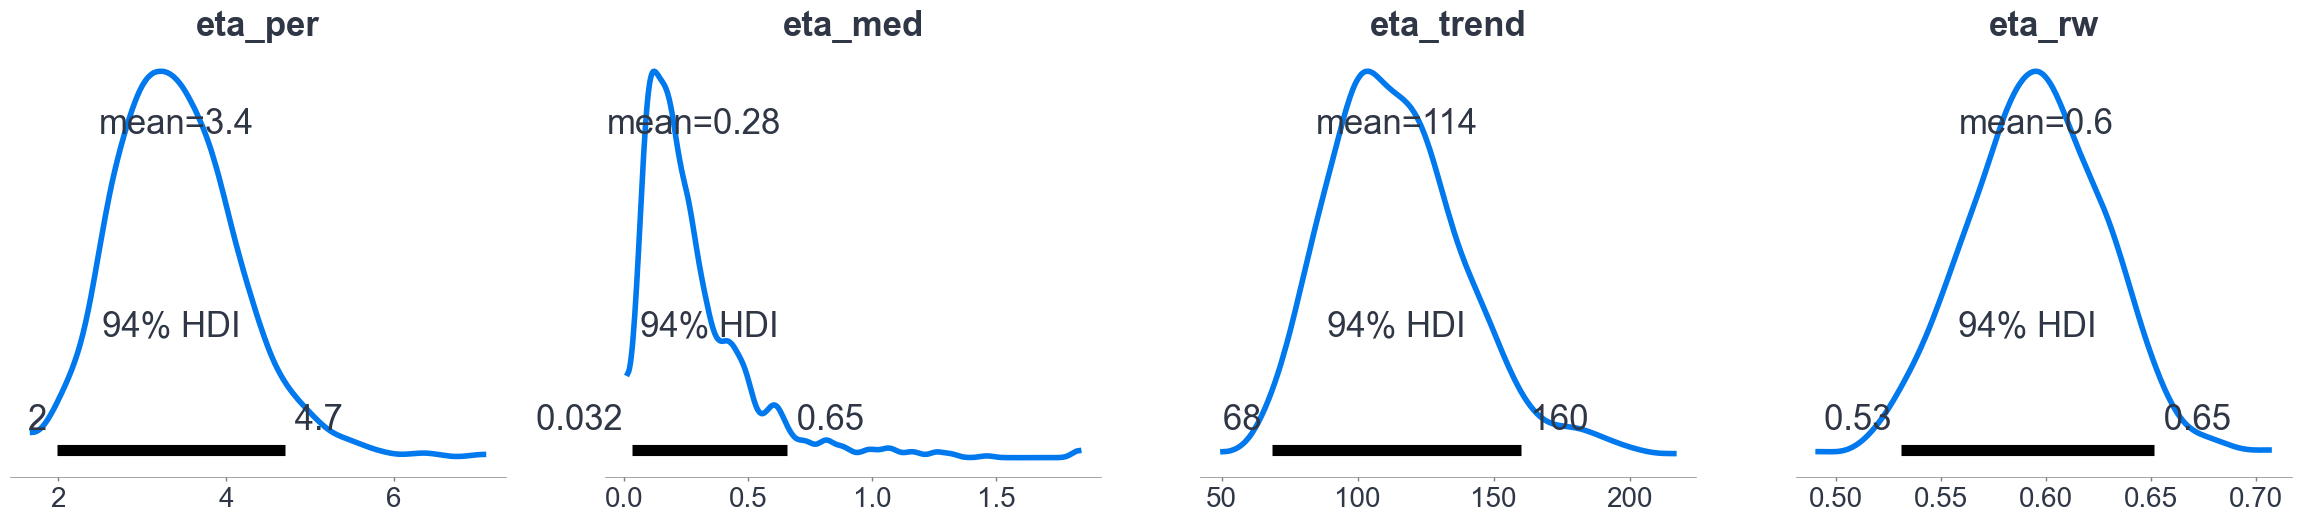

In [91]:
az.plot_posterior(idata, var_names=['eta_per', 'eta_med', 'eta_trend', 'eta_rw']);

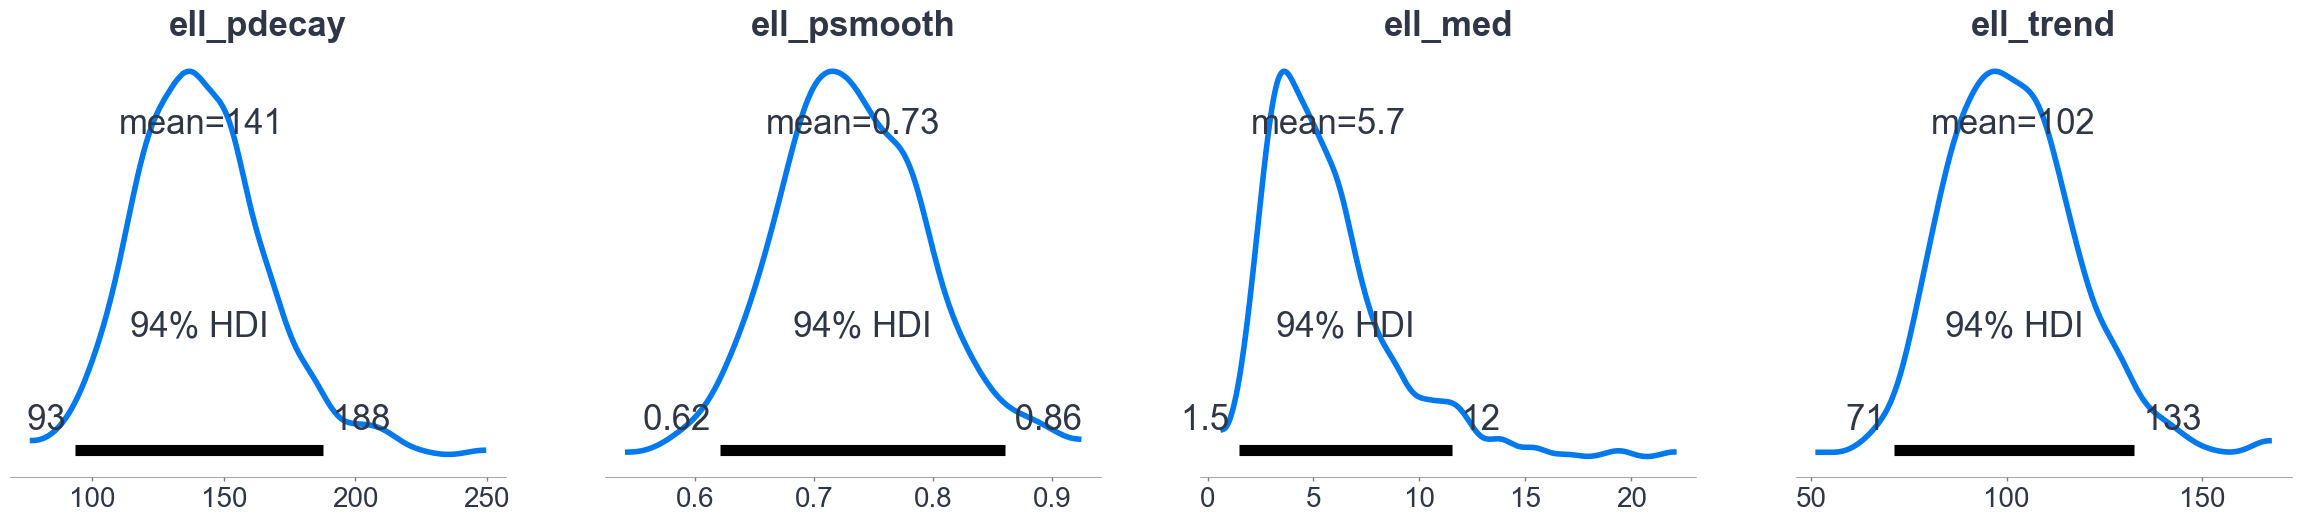

In [92]:
az.plot_posterior(idata, var_names=['ell_pdecay', 'ell_psmooth', 'ell_med', 'ell_trend']);

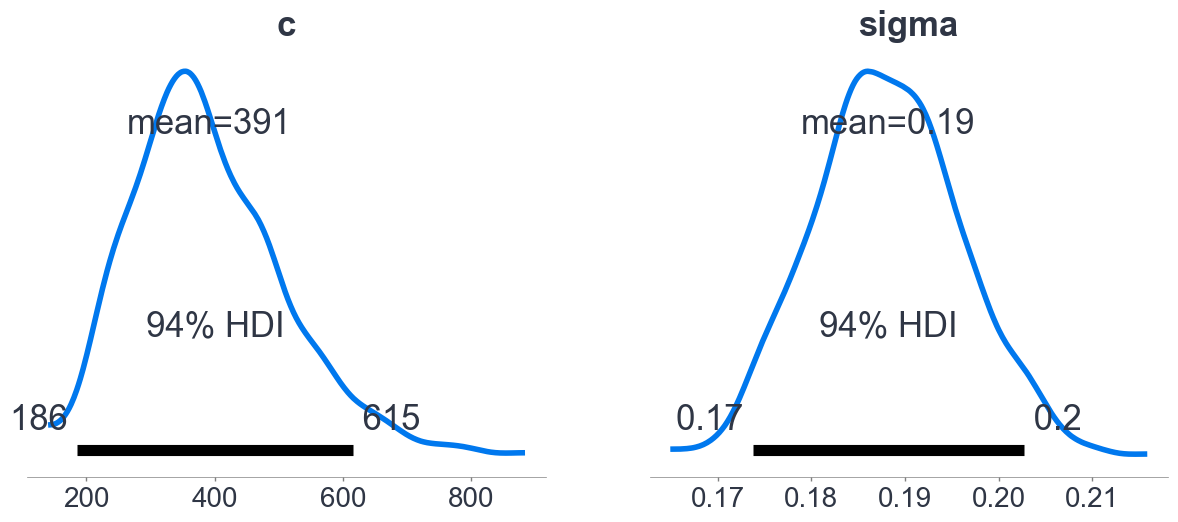

In [93]:
az.plot_posterior(idata, var_names=['c', 'sigma']);

## Predict new values

In [94]:
## Generate fit and forecast

xnew = np.linspace(2000, 2040, 700)
xnew = xnew - data["decimal date"].min()
with model:
    f = gp.conditional('f', Xnew=xnew[:, None])
    ppc = pm.sample_posterior_predictive(idata, samples=200, var_names=['f'], return_inferencedata=False)

/tmp/ipykernel_104265/1077669894.py:7: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  ppc = pm.sample_posterior_predictive(idata, samples=200, var_names=['f'], return_inferencedata=False)


## GP Forecast

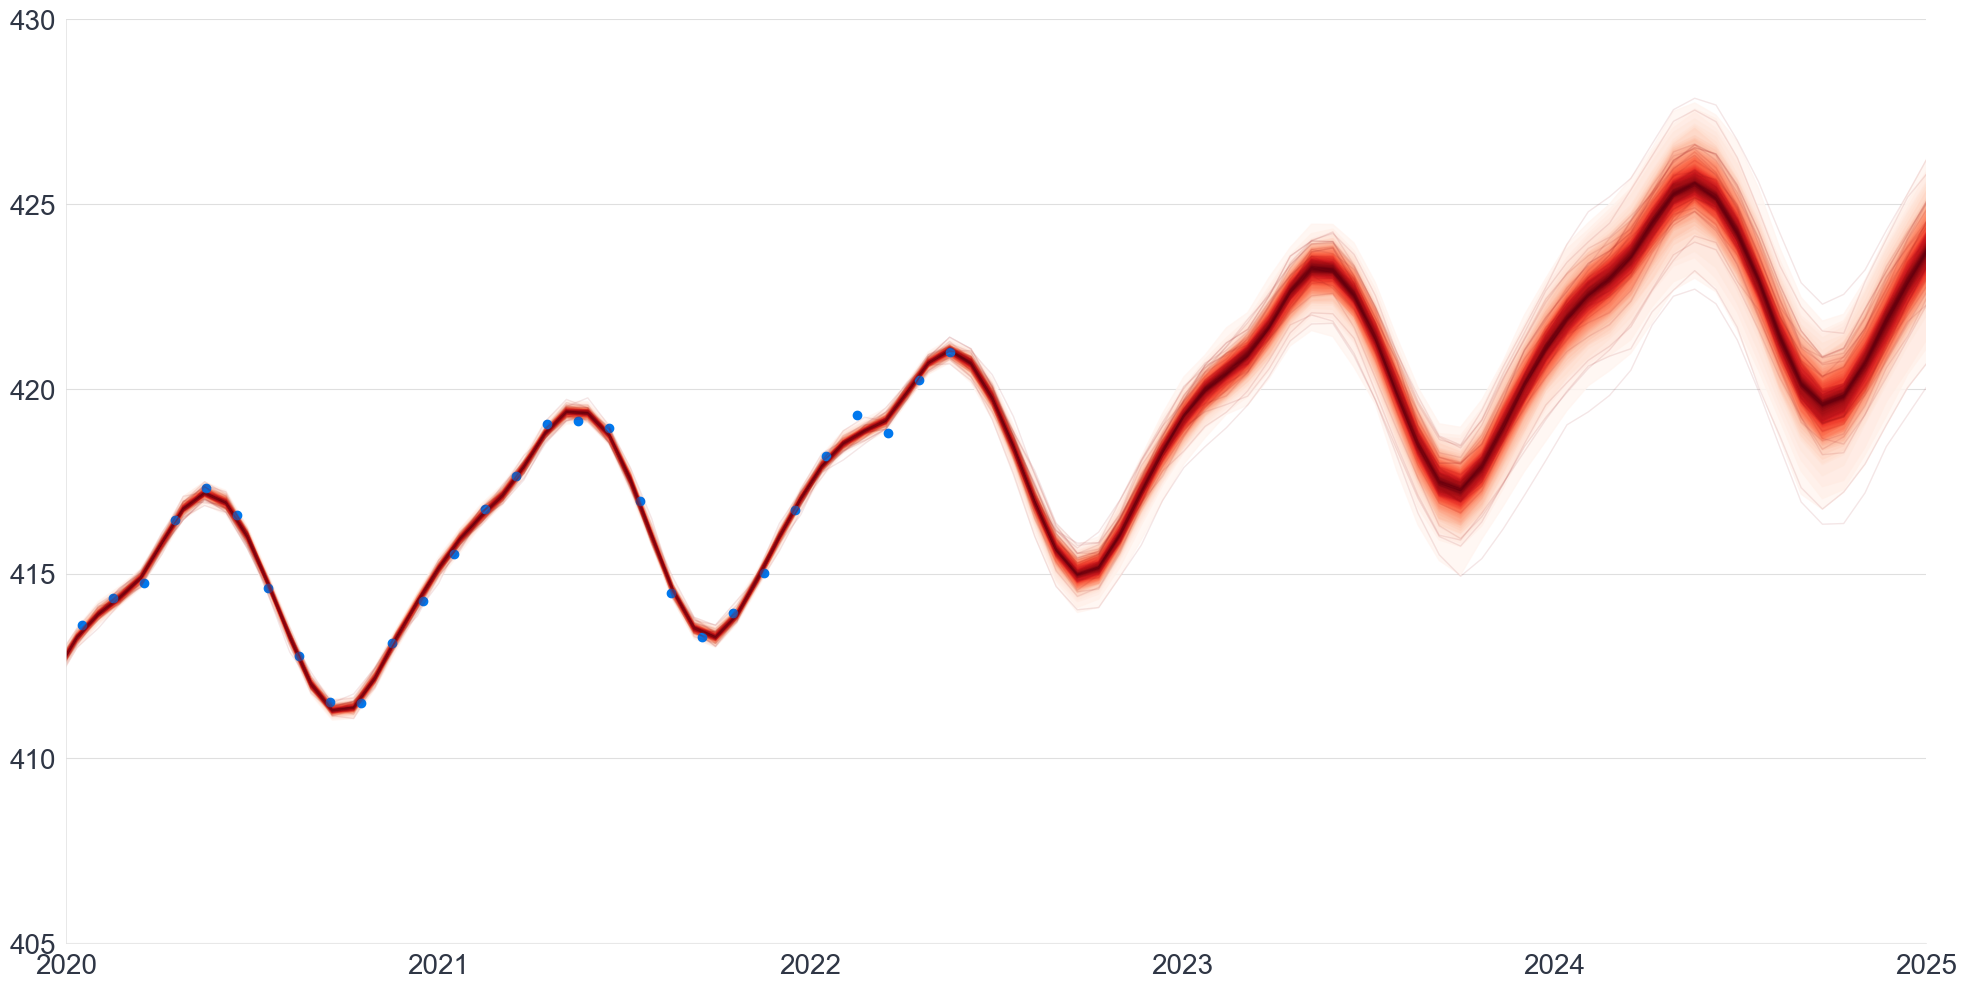

In [95]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
plt.plot(data['decimal date'], data['average'], 'o');

pm.gp.util.plot_gp_dist(ax, ppc['f'], xnew + data["decimal date"].min());

plt.xlim([2020, 2025]);
plt.ylim([405, 430]);

The great part is once we've made it through all that we get something really cool, this fit and forecast. Check out out the GP looks like our kernel fit from earlier, which is no accident, but now also includes uncertainty. Also take a look at how the uncertainty naturally increases as we extrapolate into the future.

This is what we came here for, we wanted to know what C02 levels would be at any point, both within the observed data, and when we move past the observed data. 

## The full GP on the full series

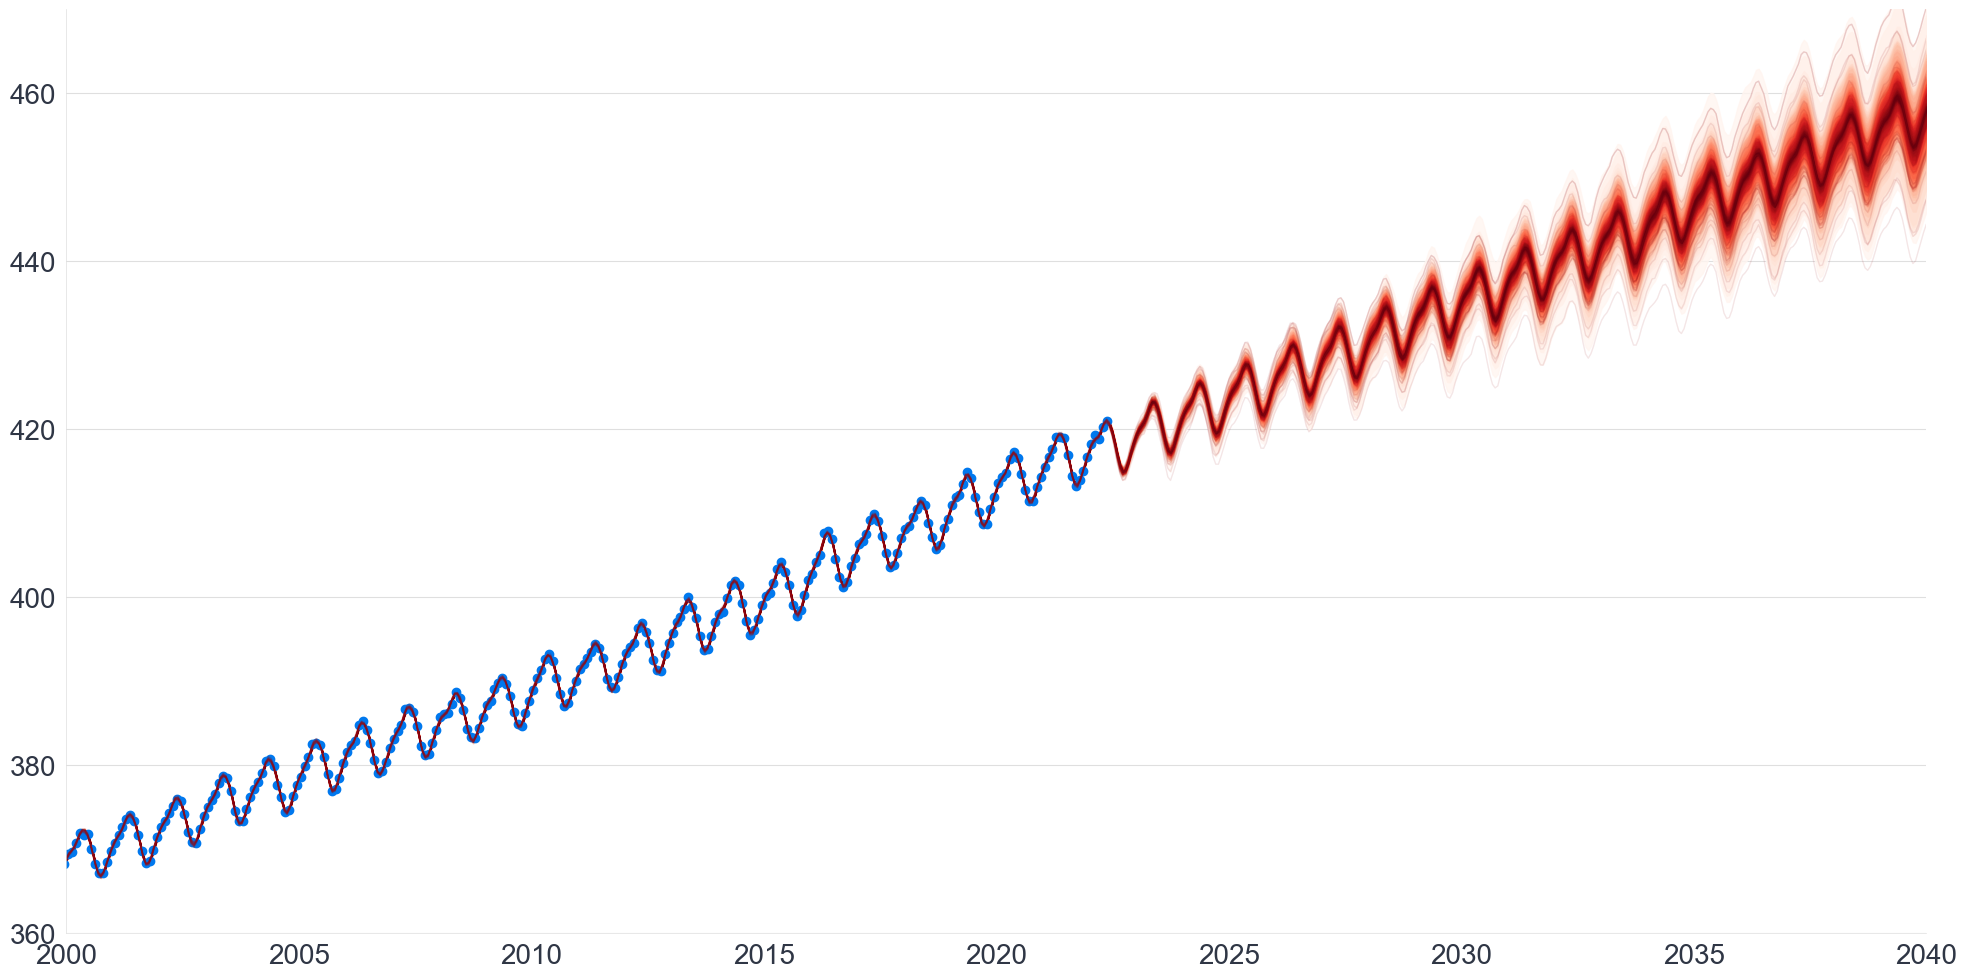

In [96]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
plt.plot(data['decimal date'], data['average'], 'o');
pm.gp.util.plot_gp_dist(ax, ppc['f'], xnew + data["decimal date"].min());
plt.xlim([2000, 2040]);
plt.ylim([360, 470]); 

If we zoom out we can see the same thing, this GP is able to fit our series quite well and extrapolate out into the future.

## Each component of the GP

In [97]:
## Calculate the MAP (maximum a-posteriori) point from our ADVI fit 
mp = {name: float(val) for name, val in dict(idata.posterior.mean()).items()}

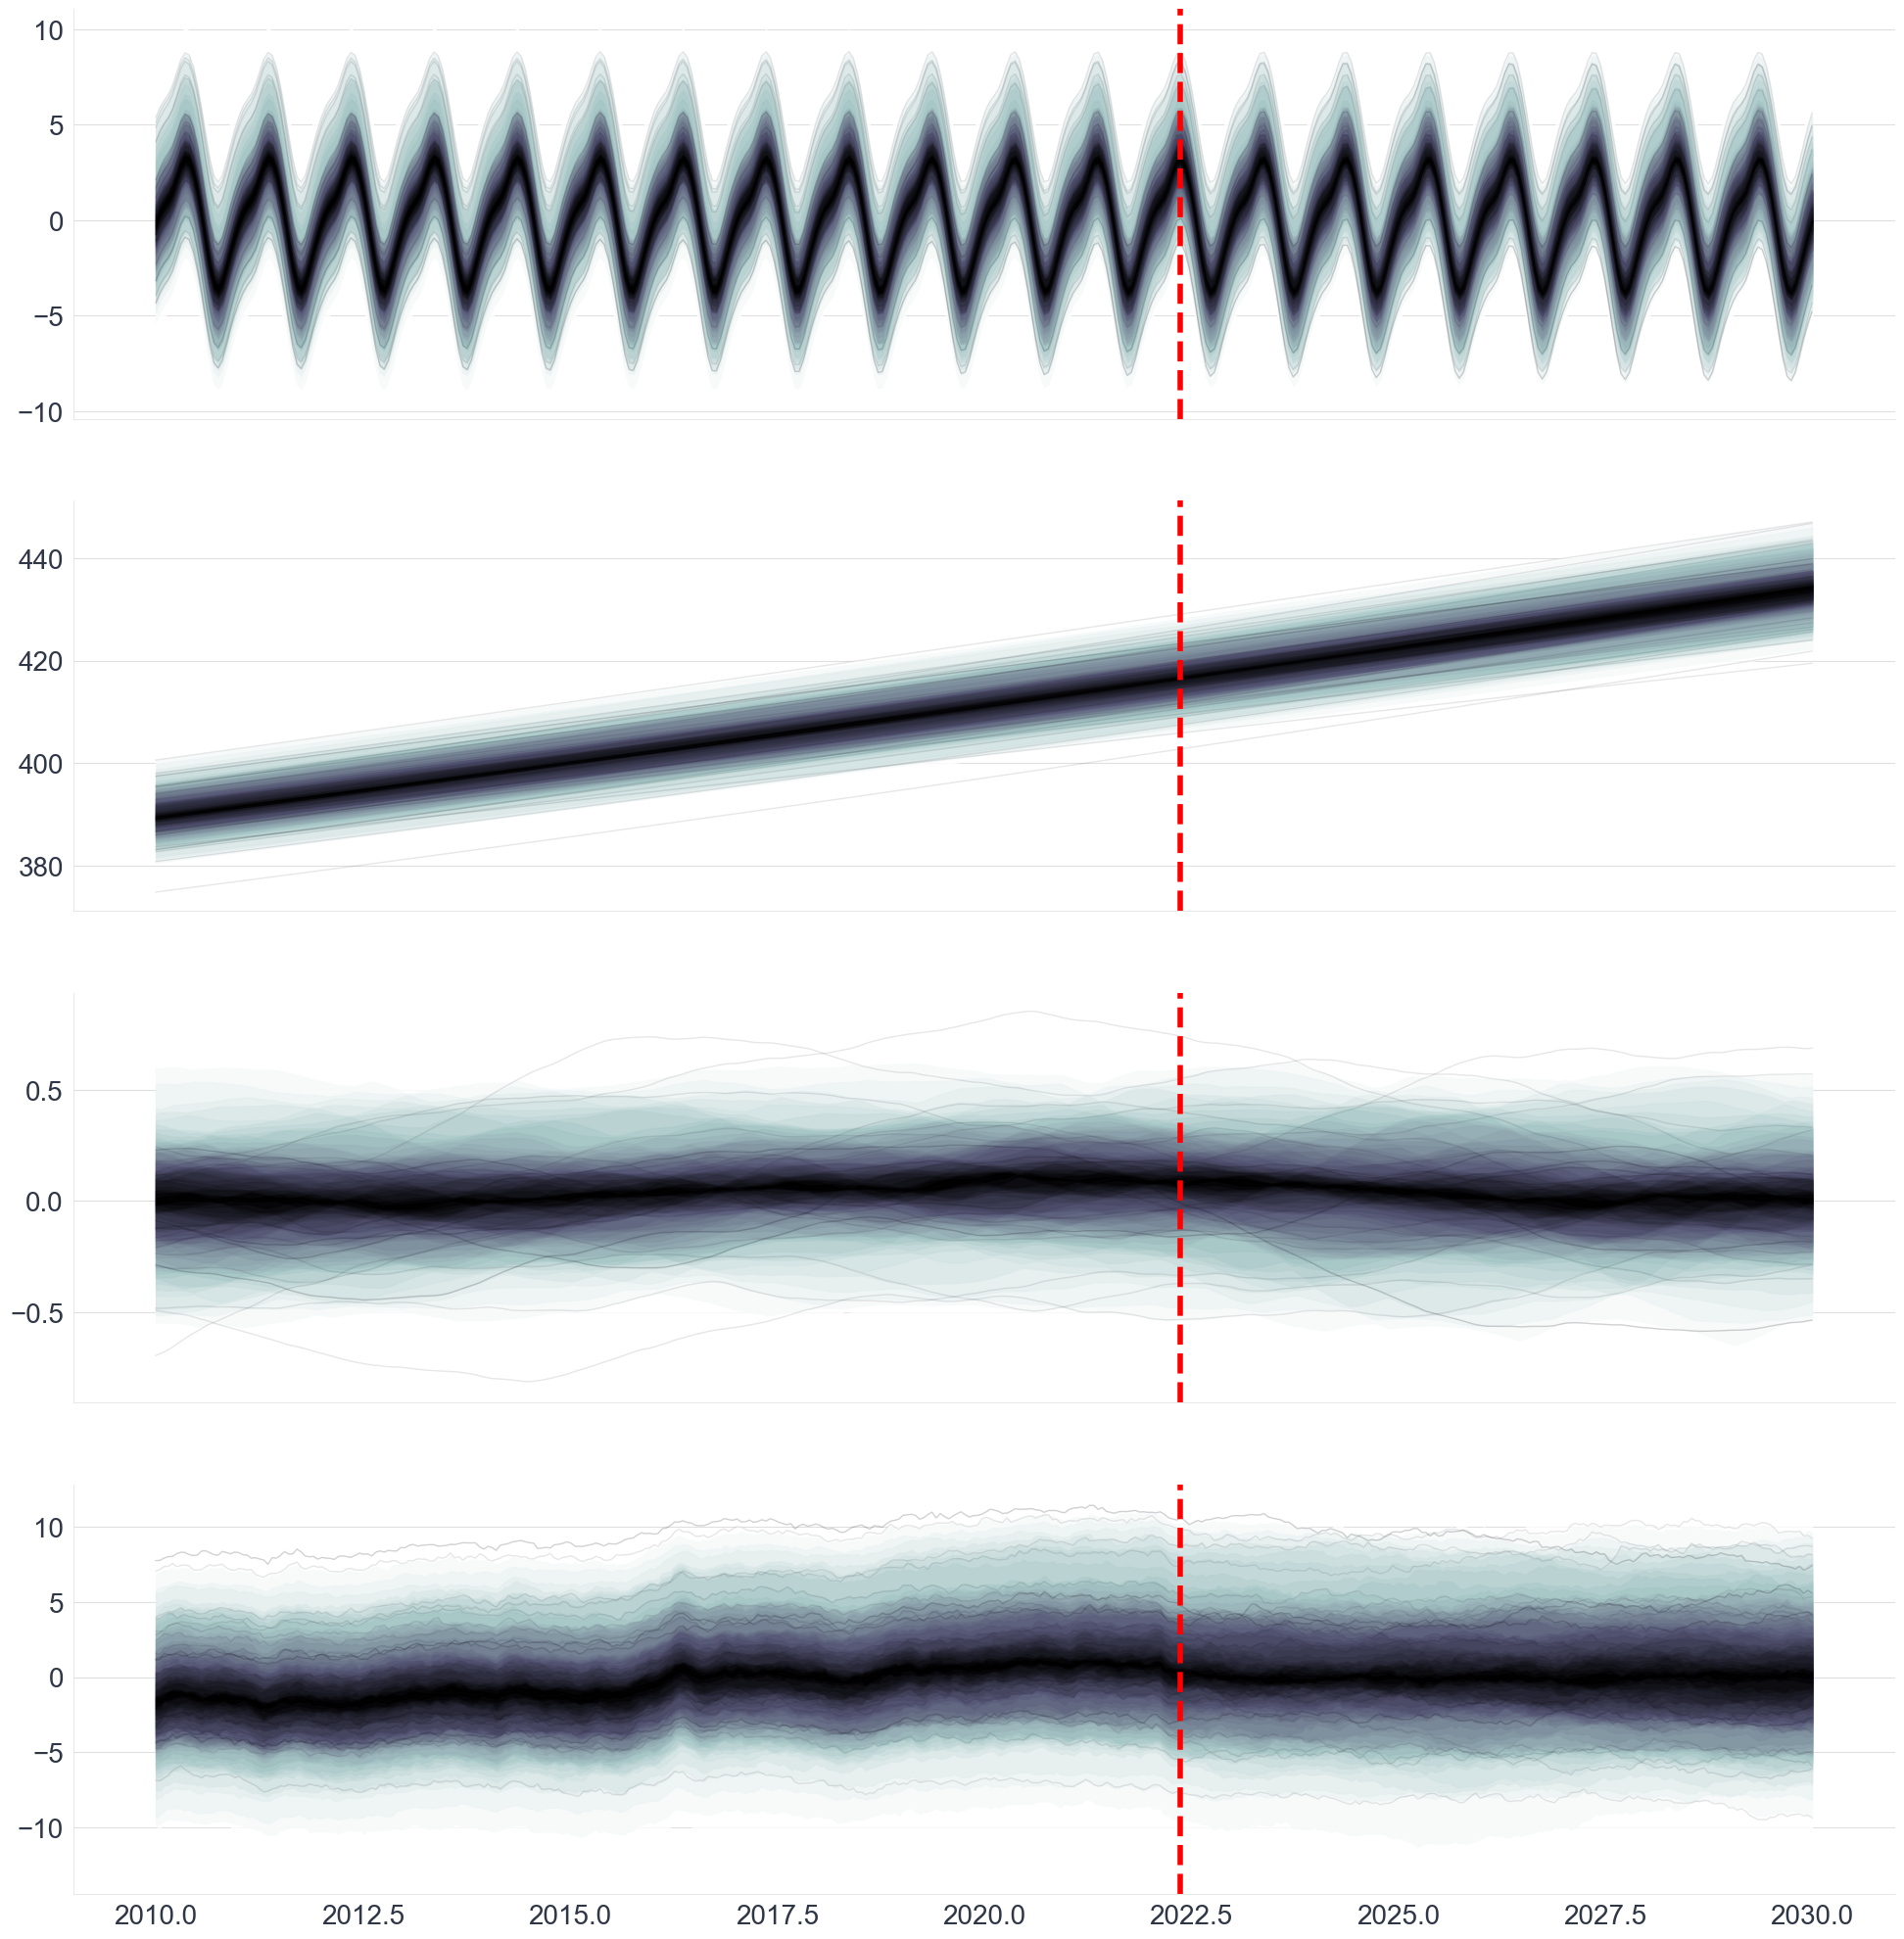

In [98]:
fig, axs = plt.subplots(4, 1, figsize=(24, 25), sharex=True)
axs = axs.flatten()

xnew = np.linspace(2010, 2030, 400)
xnew = xnew - data["decimal date"].min()
with model:
    ## plot seasonal
    mu, K = gp_seasonal.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": sigma}, diag=False
    )
    s = pm.draw(pm.MvNormal.dist(mu=mu, cov=K), 100)
    pm.gp.util.plot_gp_dist(axs[0], s, xnew + data["decimal date"].min(), palette="bone_r");
    axs[0].axvline(x=data["decimal date"].max(), color="r", linestyle="--");
    
    
    ## plot trend
    mu, K = gp_trend.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": sigma}, diag=False
    )
    s = pm.draw(pm.MvNormal.dist(mu=mu, cov=K), 100)
    pm.gp.util.plot_gp_dist(axs[1], s, xnew + data["decimal date"].min(), palette="bone_r");
    axs[1].axvline(x=data["decimal date"].max(), color="r", linestyle="--");
    
    ## plot medium/short term irregularity component
    mu, K = gp_medium.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": sigma}, diag=False
    )
    s = pm.draw(pm.MvNormal.dist(mu=mu, cov=K), 100)
    pm.gp.util.plot_gp_dist(axs[2], s, xnew + data["decimal date"].min(), palette="bone_r");
    axs[2].axvline(x=data["decimal date"].max(), color="r", linestyle="--");
    
    ## plot random walk component
    mu, K = gp_rw.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": sigma}, diag=False
    )
    s = pm.draw(pm.MvNormal.dist(mu=mu, cov=K), 100)
    pm.gp.util.plot_gp_dist(axs[3], s, xnew + data["decimal date"].min(), palette="bone_r");
    axs[3].axvline(x=data["decimal date"].max(), color="r", linestyle="--");

And one other great feature of GPs, we can plot each component separately,m really allowing us to introspect into the model and see where our final predictions are coming from.


## Section Recap
* Now you've seen you first GP!
* GPs are based on kernels
  * There's a couple more pieces included such as Covariance
* GPs give us what we were looking for
  * An estimate of the observed data with uncertainty
  * Without needing be constrained to traditional functional forms


# Lesson Recap

Alright you made it. LEts talk through what we learned in this lesson

<br>
<center>
    <div>
       <img src="img/FullGPMeme.jpeg" style="height:900px";/>
    </div>
</center>

## Fit data using functional forms
* Functional forms take an x and output a y
  * Not surprising if you're in this course
* Functional forms are typically strict artists
* All data is evenly weighted
  * In most cases

## Functions can be added
* To fit extra nuance we can add functions together
* In the Keeling Curve case we need both a trend and seasonality

## Similarity Functions and Kernels
* Instead of strict functional forms we can use similarity to estimate points
  * The points closest to our point of interest have the most weight
* Introduced kernels
  * Specifically the exponentiated quadratic kernel
* Kernels can more "flexibly" fit the data
* Lengthscale is an important parameter of exponentiated quadratic kernel
  * Short lengthscale is like walking from LA to New York
  * Long lengthscale is like flying
    * Distance is compressed

## Gaussian processes
* Gaussian processes 
  * Flexibly fit data by using kernels at their core
  * Include uncertainty in their estimation
  * Have additive behavior like the functional models
* Can take a long time to estimate computationally depending on the model and data
  * We'll see more practical tips on this later